# Artificial Neural Networks and Deep Learning

---

## Homework 2: Semantic Segmentation
This notebook contains one possible structure for the second homework of the AN2DL course. The goal is to perform semantic segmentation on a specific set of images, collected from Mars surface.

## TODO:
* Il test set non presenta particolari augmentations, le immagini sembrano le stesse del train set
* La classe di Background (label = 0) non è inclusa nella valutazione del MeanIoU e pertanto è da escludersi.

* Da questo video (https://www.youtube.com/watch?v=azM57JuQpQI&list=PLZsOBAyNTZwbR08R959iCvYT3qzhxvGOE) si nota che viene anche usato un layer di dropout con rate piccolo (0.1) durante la convoluzione: può aiutare?

## ⚙️ Import Libraries

In [20]:
import os
from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import regularizers

import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import keras_cv as kcv
from sklearn.model_selection import train_test_split

seed = 42
# np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [21]:
## ⏳ Load the Data

In [22]:
# Load the entire dataset

data = np.load("/kaggle/input/mars-for-students/mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## 👀 Inspect the dataset
Dataset inspection is meant to find possible outliers in the images, detect duplicates and, more in general, to do everything connected to data cleaning and pre-processing.

[1622 1135 1844 1081 1733  698  509 1467 1248 1523]


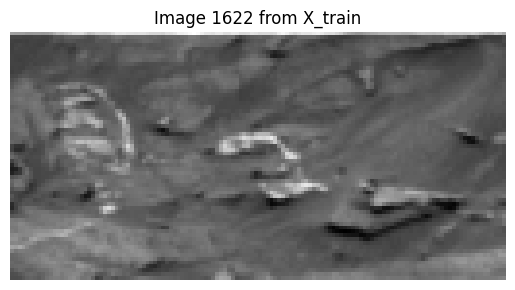

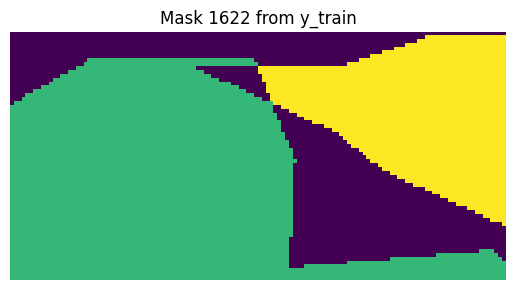

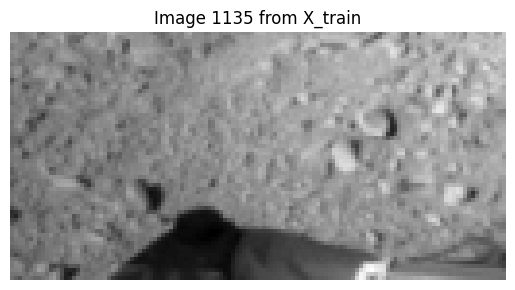

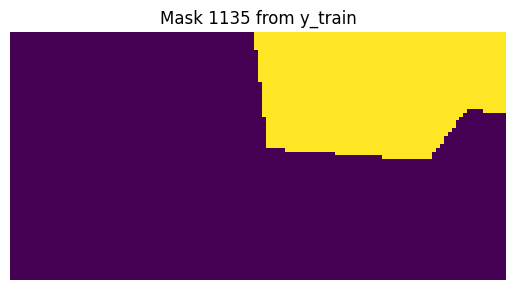

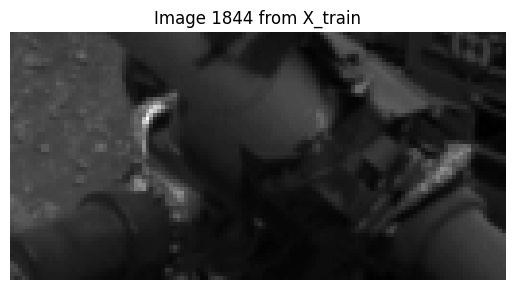

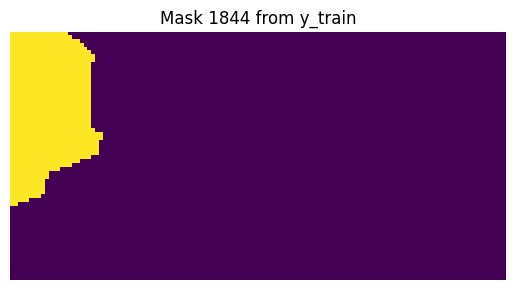

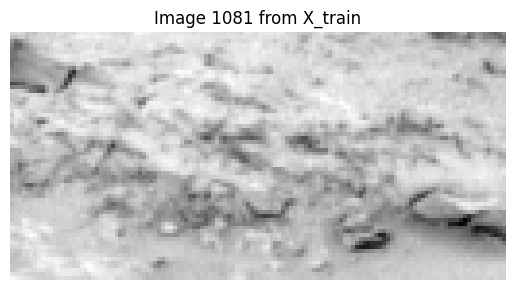

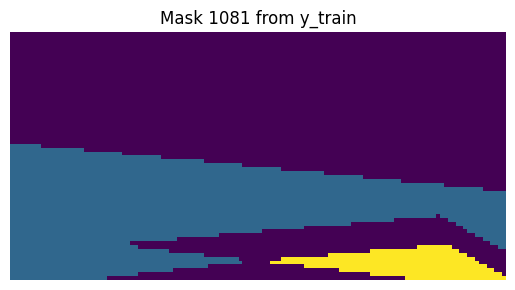

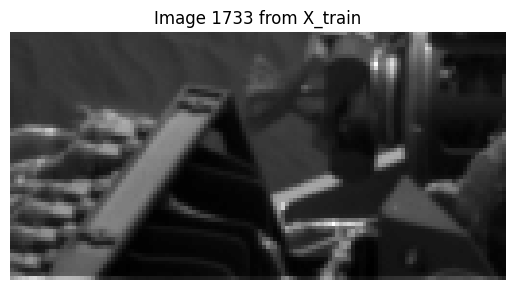

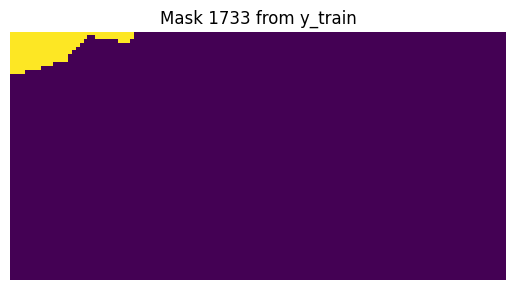

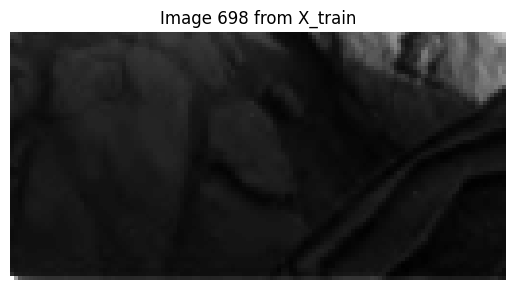

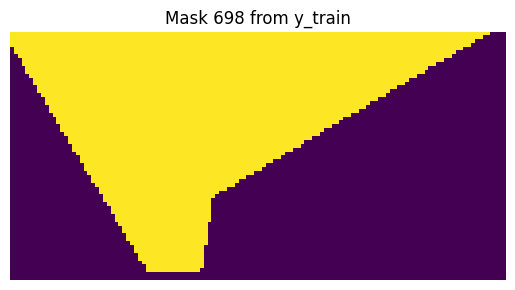

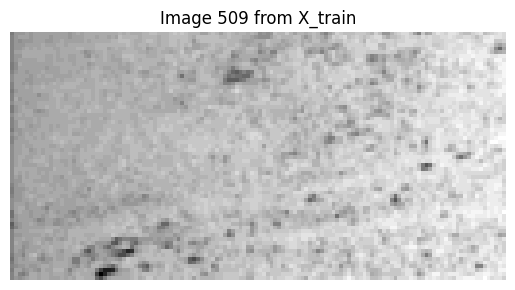

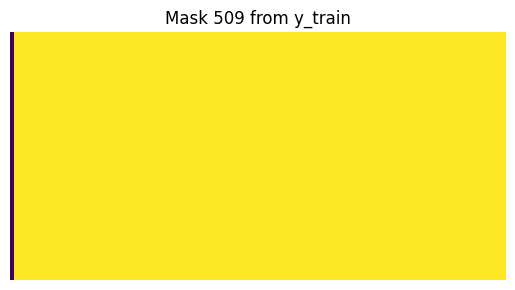

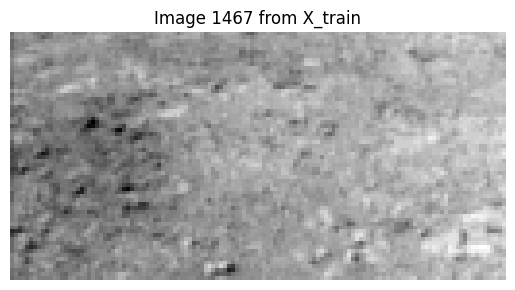

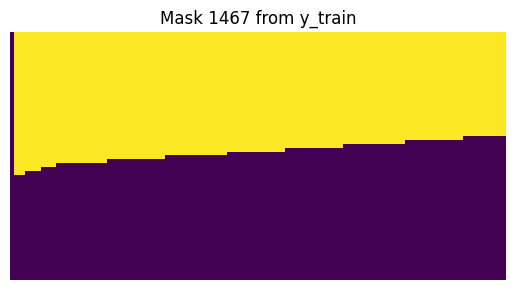

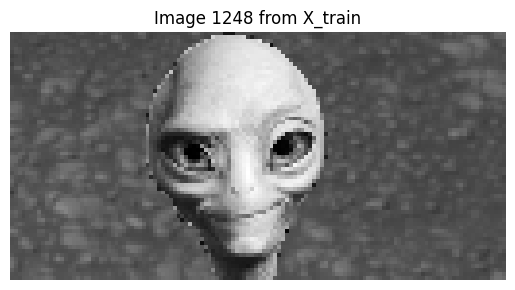

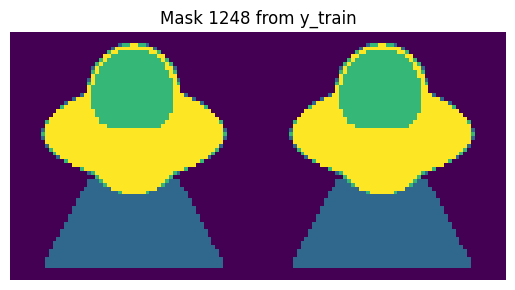

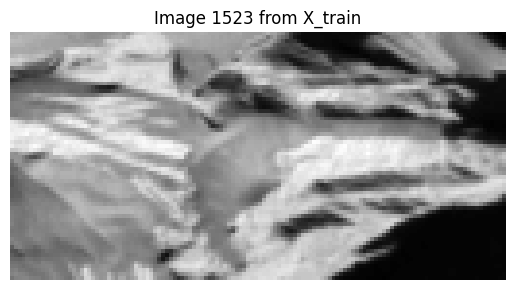

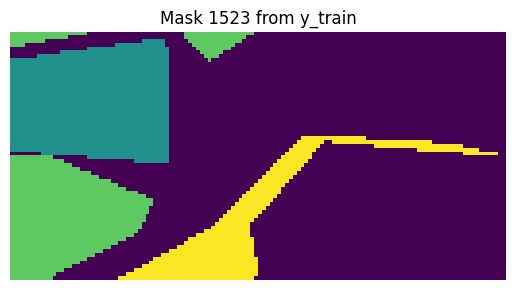

In [23]:
# Create a random index to display every time a different set of images
X_train_size = X_train.shape[0]
random_indices = np.random.randint(0, X_train_size, size = 10)
print(random_indices)

# Plot the image
for index in random_indices:
    plt.imshow(X_train[index], cmap='gray')
    plt.title(f"Image {index} from X_train")
    plt.axis('off')
    plt.show()
    
    plt.imshow(y_train[index])
    plt.title(f"Mask {index} from y_train")
    plt.axis('off')
    plt.show()

### 🧹 Remove the Outliers
Analysing the *X_train* and *y_train* sets, it is possible to notice some outliers. For example, there are some pictures (e.g. the one with index 62) contains the picture of an alien. 

By understanding both the pictures and the masks, the masks seems to be the same even if the alien picture is flipped. So we can scan all the masks that are the same of picture 62 and then remove them from the dataset.

In [24]:
# This function establish if image1 and image2 are the same images, pixel-wise.
def are_same_mask (image1, image2):
    if image1.shape != image2.shape:
        print("[ERROR] The images are not the same size.")
        return False
    return np.array_equal(image1, image2)

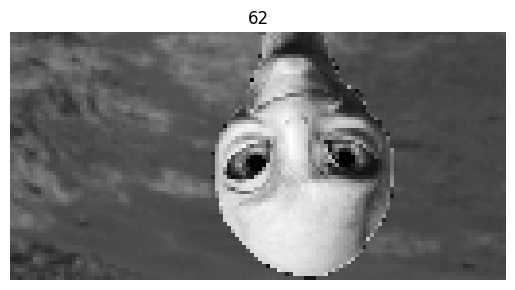

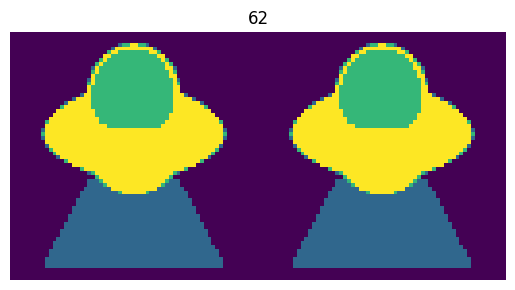

In [25]:
# Show the first picture of an alien
first_alien_index = 62
alien_indices = []
alien_indices.append(first_alien_index)

plt.imshow(X_train[first_alien_index], cmap='gray')
plt.title(first_alien_index)
plt.axis('off')
plt.show()

plt.imshow(y_train[first_alien_index])
plt.title(first_alien_index)
plt.axis('off')
plt.show()

In [26]:
# Detect all the images with the same masks as of the first alien
for i in range(X_train_size):
    if i != first_alien_index and are_same_mask(y_train[first_alien_index], y_train[i]):
        alien_indices.append(i)

print(f"{len(alien_indices)} images have the same mask of the first alien picture:")
print(alien_indices)

110 images have the same mask of the first alien picture:
[62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]


In [27]:
# Delete from X_train and y_train all the images with index in alien_indices
X_train = np.delete(X_train, alien_indices, axis=0)
y_train = np.delete(y_train, alien_indices, axis=0)

print("Shape of X_train without aliens: ", X_train.shape)
print("Shape of y_train without aliens: ", y_train.shape)

Shape of X_train without aliens:  (2505, 64, 128)
Shape of y_train without aliens:  (2505, 64, 128)


## 🪓 Split into training and validation set
The training set provided via the arrays *X_train* and *y_train* should be splitted into a new effective training set and a validation set.

In [28]:
# Split into training and validation set with a 80/20 ratio.
X_train, X_val, y_train, y_val = train_test_split (
    X_train, y_train, test_size = 0.2, random_state = seed
)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  (2004, 64, 128)
y_train shape:  (2004, 64, 128)
X_val shape:  (501, 64, 128)
y_val shape:  (501, 64, 128)


## ☀️ Augmenting the training set
In this section we perform some static augmentations to the training set.

In [29]:
import numpy as np
import random

def apply_random_crop_to_new_image(image, ground_truth, min_crop_size=(16, 32), max_crop_size=(64, 128)):
    # Ottieni le dimensioni dell'immagine originale
    h, w = image.shape
    
    # Genera dimensioni casuali per la porzione da copiare
    crop_h = random.randint(min_crop_size[0], max_crop_size[0])
    crop_w = random.randint(min_crop_size[1], max_crop_size[1])
    
    # Assicurati che la porzione scelta possa stare dentro l'immagine
    if crop_h > h or crop_w > w:
        raise ValueError("La porzione da copiare è più grande dell'immagine")

    # Scegli una posizione casuale per la porzione da copiare nell'immagine
    top = random.randint(0, h - crop_h)
    left = random.randint(0, w - crop_w)
    
    # Crea le nuove immagini vuote
    new_image = np.zeros((h, w), dtype=np.uint8)  # Immagine vuota
    new_ground_truth = np.zeros((h, w), dtype=np.uint8)  # Ground truth vuoto
    
    # Copia la porzione di immagine e ground truth nella posizione scelta
    new_image[top:top+crop_h, left:left+crop_w] = image[top:top+crop_h, left:left+crop_w]
    new_ground_truth[top:top+crop_h, left:left+crop_w] = ground_truth[top:top+crop_h, left:left+crop_w]
    
    return new_image, new_ground_truth

def create_new_datasets(images, ground_truths):
    new_images = []
    new_ground_truths = []
    
    # Itera su ogni immagine e ground truth
    for i in range(images.shape[0]):
        image = images[i]
        ground_truth = ground_truths[i]
        
        new_image, new_ground_truth = apply_random_crop_to_new_image(image, ground_truth)
        
        new_images.append(new_image)
        new_ground_truths.append(new_ground_truth)
    
    # Converti le liste in array NumPy
    new_images = np.array(new_images)
    new_rn_ground_truths = np.array(new_ground_truths)
    
    return new_images, new_ground_truths

# Esempio di utilizzo:
# Supponiamo che `images` e `ground_truths` siano i tuoi dataset (entrambi con shape (2500, 64, 128))
# images = np.random.randint(0, 256, size=(2500, 64, 128), dtype=np.uint8)
# ground_truths = np.random.randint(0, 6, size=(2500, 64, 128), dtype=np.uint8)

# Nuovi dataset con porzioni random
X_train_crop, y_train_crop = create_new_datasets(X_train, y_train)

# new_images e new_ground_truths conterranno i nuovi dataset creati


In [30]:
# Define a custom function for random horizontal/vertical flip
def random_flip (train_img, train_mask, threshold=0.5):
    for i in range(train_img.shape[0]):
        h_or_v = 0 if np.random.uniform(0, 1) < threshold else 1
        train_img[i] = cv2.flip(train_img[i], h_or_v)
        train_mask[i] = cv2.flip(train_mask[i], h_or_v)
    return train_img, train_mask

In [31]:
X_train_len = int(X_train.shape[0] * 1)

# Perform random horizontal/vertical flip on a copy of the first half of the dataset
X_train_flip = np.array(X_train[:X_train_len], copy = True)
y_train_flip = np.array(y_train[:X_train_len], copy = True)
X_train_copy, y_train_copy = random_flip(X_train_flip, y_train_flip)

In [32]:
# Apply Solarization to a portion of the dataset
X_train_solar = np.array(X_train[:X_train_len], copy = True)
y_train_solar = np.array(y_train[:X_train_len], copy = True)

solarization = kcv.layers.Solarization(value_range=(0, 255))
X_train_solar = solarization(X_train_solar)

In [33]:
'''# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_flip], axis=0)
y_train = np.concatenate([y_train, y_train_flip], axis=0)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_solar], axis=0)
y_train = np.concatenate([y_train, y_train_solar], axis=0)

# Concatenate the obtained results
X_train = np.concatenate([X_train, X_train_crop], axis=0)
y_train = np.concatenate([y_train, y_train_crop], axis=0) '''

'# Concatenate the obtained results\nX_train = np.concatenate([X_train, X_train_flip], axis=0)\ny_train = np.concatenate([y_train, y_train_flip], axis=0)\n\n# Concatenate the obtained results\nX_train = np.concatenate([X_train, X_train_solar], axis=0)\ny_train = np.concatenate([y_train, y_train_solar], axis=0)\n\n# Concatenate the obtained results\nX_train = np.concatenate([X_train, X_train_crop], axis=0)\ny_train = np.concatenate([y_train, y_train_crop], axis=0) '

In [34]:
# Apply RandomContrast to the entire dataset
# rand_contrast = tfkl.RandomContrast(factor=0.3, seed=seed)
# X_train = rand_contrast(X_train)

In [35]:
# Apply RandomBrightness to the entire dataset
# rand_bn = tfkl.RandomBrightness(factor=0.2, value_range=(0, 255), seed=seed)
# X_train = rand_bn(X_train)

In [36]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_val = X_val[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

# Retrieve the shape of the input
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


## 🛠️ Models and Experiments
A first experiment of the model is done by building from scratch the U-Net architecture.

In [37]:
# Define network hyperparameters
batch_size = 64
learning_rate = 1e-3
epochs = 100

print("Batch size: ", batch_size)
print("Initial learning rate: ", learning_rate)
print("Epochs: ", epochs)

Batch size:  64
Initial learning rate:  0.001
Epochs:  100


In [38]:
# Defining the Convolutional Block
from tensorflow.keras.constraints import MinMaxNorm

def conv_block(inputs, num_filters):
	# Applying the sequence of Convolutional, Batch Normalization
	# and Activation Layers to the input tensor
	x = tf.keras.Sequential([
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu'),
		# Convolutional Layer
		tf.keras.layers.Conv2D(num_filters, 3, padding='same'),
		# Batch Normalization Layer
		tf.keras.layers.BatchNormalization(),
		# Activation Layer
		tf.keras.layers.Activation('relu'),
        
	])(inputs)

	# Returning the output of the Convolutional Block
	return x


In [39]:

def unet_plus_plus_model(input_shape=(64, 128, 1), num_classes=5, deep_supervision=True):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoding Path
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(tf.keras.layers.MaxPooling2D()(x_00), 128)
    x_20 = conv_block(tf.keras.layers.MaxPooling2D()(x_10), 256)
    x_30 = conv_block(tf.keras.layers.MaxPooling2D()(x_20), 512)
    x_40 = conv_block(tf.keras.layers.MaxPooling2D()(x_30), 1024)
    x_40 = tfkl.Dropout(0.5)(x_40)

    # Nested Decoding Path
    x_01 = conv_block(tf.keras.layers.concatenate(
        [x_00, tf.keras.layers.UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(tf.keras.layers.concatenate(
        [x_10, tf.keras.layers.UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(tf.keras.layers.concatenate(
        [x_20, tf.keras.layers.UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(tf.keras.layers.concatenate(
        [x_30, tf.keras.layers.UpSampling2D()(x_40)]), 512)

    x_02 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, tf.keras.layers.UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(tf.keras.layers.concatenate(
        [x_10, x_11, tf.keras.layers.UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(tf.keras.layers.concatenate(
        [x_20, x_21, tf.keras.layers.UpSampling2D()(x_31)]), 256)

    x_03 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, x_02, tf.keras.layers.UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(tf.keras.layers.concatenate(
        [x_10, x_11, x_12, tf.keras.layers.UpSampling2D()(x_22)]), 128)

    x_04 = conv_block(tf.keras.layers.concatenate(
        [x_00, x_01, x_02, x_03, tf.keras.layers.UpSampling2D()(x_13)]), 64)

    # Deep Supervision Path
    if deep_supervision:
        outputs = [
            tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(x_01),
            tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(x_02),
            tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(x_03),
            tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(x_04)
        ]
        
        channel_weights = [tf.Variable(initial_value=0.25, trainable=True, dtype=tf.float32, constraint=tf.keras.constraints.MinMaxNorm(min_value=0.1, max_value=0.5, axis=0)) for _ in range(4)]
        normalized_weights = tf.nn.softmax(channel_weights)
        weighted_outputs = [w * o for w, o in zip(normalized_weights, outputs)]
        outputs = tf.keras.layers.Add()(weighted_outputs)

    else:
        outputs = tf.keras.layers.Conv2D(num_classes, 1, activation="softmax")(x_04)

    model = tf.keras.Model(inputs=inputs, outputs=outputs, name='Unet_plus_plus')
    return model

if __name__ == "__main__":
    # Creazione del modello
    model = unet_plus_plus_model(input_shape=(64, 128, 1), num_classes=5, deep_supervision=True)

    # Stampare il sommario del modello
    model.summary()


Model: "Unet_plus_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 128,   │     75,264 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ sequential[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 64,    │    370,560 │ max_pooling2d[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 32,    │          0 │ sequential_1[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 32,    │  1,478,400 │ max_pooling2d_1[… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 16,     │          0 │ sequential_2[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 16,     │  5,905,920 │ max_pooling2d_2[… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 8, 512) │          0 │ sequential_3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 8,      │ 23,608,320 │ max_pooling2d_3[… │
│ (Sequential)        │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4, 8,      │          0 │ sequential_4[0][… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 8, 16,     │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 16, 32,    │          0 │ sequential_3[0][… │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 8, 16,     │          0 │ sequential_3[0][… │
│ (Concatenate)       │ 1536)             │            │ up_sampling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 32, 64,    │          0 │ sequential_2[0][… │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 16, 32,    │          0 │ sequential_2[0][… │
│ (Concatenate)       │ 768)              │            │ up_sampling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 8, 16,     │ 11,804,160 │ concatenate_3[0]

 Total params: 53,361,940 (203.56 MB)

 Trainable params: 53,340,052 (203.48 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [40]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

In [41]:
# Define custom Mean Intersection Over Union metric
# By default, no classes are excluded.
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_io_u", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [42]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tfk.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [43]:
# Generalized Dice Loss
def generalized_dice_loss(y_true, y_pred):
    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)
    
    # Compute per-class weights
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(0, 1, 2))
    denominator = tf.reduce_sum(y_true + y_pred, axis=(0, 1, 2))
    weights = 1 / (tf.reduce_sum(y_true, axis=(0, 1, 2)) ** 2 + 1e-6)
    
    # Generalized Dice Score
    dice_score = tf.reduce_sum(weights * numerator) / tf.reduce_sum(weights * denominator)
    
    # Loss is 1 - Dice Score
    return 1 - dice_score
    
def combined_loss(y_true, y_pred, num_classes=5, alpha=0.5, beta=0.4, gamma=0.1):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    
    # Exclude the background class (label 0)
    y_true_one_hot = y_true_one_hot[..., 1:]  # Ignore background in ground truth
    y_pred = y_pred[..., 1:]  # Ignore background in predictions

    # Ensure predictions are normalized
    y_pred = tf.keras.backend.clip(y_pred, 1e-7, 1 - 1e-7)

    # 1. Generalized Dice Loss
    gen_dice_loss = generalized_dice_loss(y_true_one_hot, y_pred)
    
    # 2. Focal Loss
    gamma_focal = 2.0
    focal_loss = -tf.reduce_mean(
        tf.reduce_sum(
            y_true_one_hot * ((1 - y_pred) ** gamma_focal) * tf.math.log(y_pred), axis=-1
        )
    )
    
    #4. Boundary loss
    def erosion2d_custom(tensor, d=1):
            kernel = tf.ones((d, d, tensor.shape[-1]), dtype=tf.float32)  # Create kernel
            kernel = tf.expand_dims(kernel, axis=-1)  # [d, d, channels, 1]
            eroded = tf.nn.depthwise_conv2d(
                input=tensor,
                filter=kernel,
                strides=[1, 1, 1, 1],
                padding="SAME"
            )
            return tf.cast(eroded == tf.reduce_sum(kernel), dtype=tf.float32)
    
    def boundary_dou_loss(y_true, y_pred, d=1):
        
        # Ensure predictions are between 0 and 1
        y_pred = tf.clip_by_value(y_pred, 0, 1)
        
        # Create the boundary mask
        kernel = tf.ones((d, d, 4), dtype=tf.float32)
        y_true_eroded = erosion2d_custom(y_true)
        y_pred_eroded= erosion2d_custom(y_pred)
    
        # Boundary regions are the difference between original and eroded masks
        y_true_boundary = y_true - y_true_eroded
        y_pred_boundary = y_pred - y_pred_eroded
    
        # Calculate Intersection and Union on the boundary
        intersection = tf.reduce_sum(y_true_boundary * y_pred_boundary, axis=[1, 2])
        union = tf.reduce_sum(y_true_boundary + y_pred_boundary, axis=[1, 2]) - intersection
    
        # Calculate area and circumference for weighting term
        area = tf.reduce_sum(y_true, axis=[1, 2])
        circumference = tf.reduce_sum(y_true_boundary, axis=[1, 2])
    
        # Compute alpha
        alpha = 1 - 2 * (circumference / (area + 1e-6))
        alpha = tf.clip_by_value(alpha, 0, 1)
    
        # Compute Boundary DoU loss
        loss = (union - intersection) / (union - alpha * intersection + 1e-6)
    
        # Reduce mean over the batch
        return tf.reduce_mean(loss)

    boundary_loss = boundary_dou_loss(y_true_one_hot, y_pred)
    
    # Combine the losses with weights
    total_loss = alpha * gen_dice_loss + beta * focal_loss + gamma * boundary_loss
    
    return total_loss

In [44]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, original_image, original_mask, num_classes, frequency=1):
        super().__init__()
        self.original_image = original_image   # Define the original image
        self.original_mask = original_mask     # Define the original mask
        self.num_classes = num_classes         # Define the number of classes
        self.frequency = frequency             # Define the visualization frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image = np.expand_dims(self.original_image, axis=0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)            
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(self.original_image, cmap='gray')
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(apply_colormap(self.original_mask, colormap))
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred, colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()            

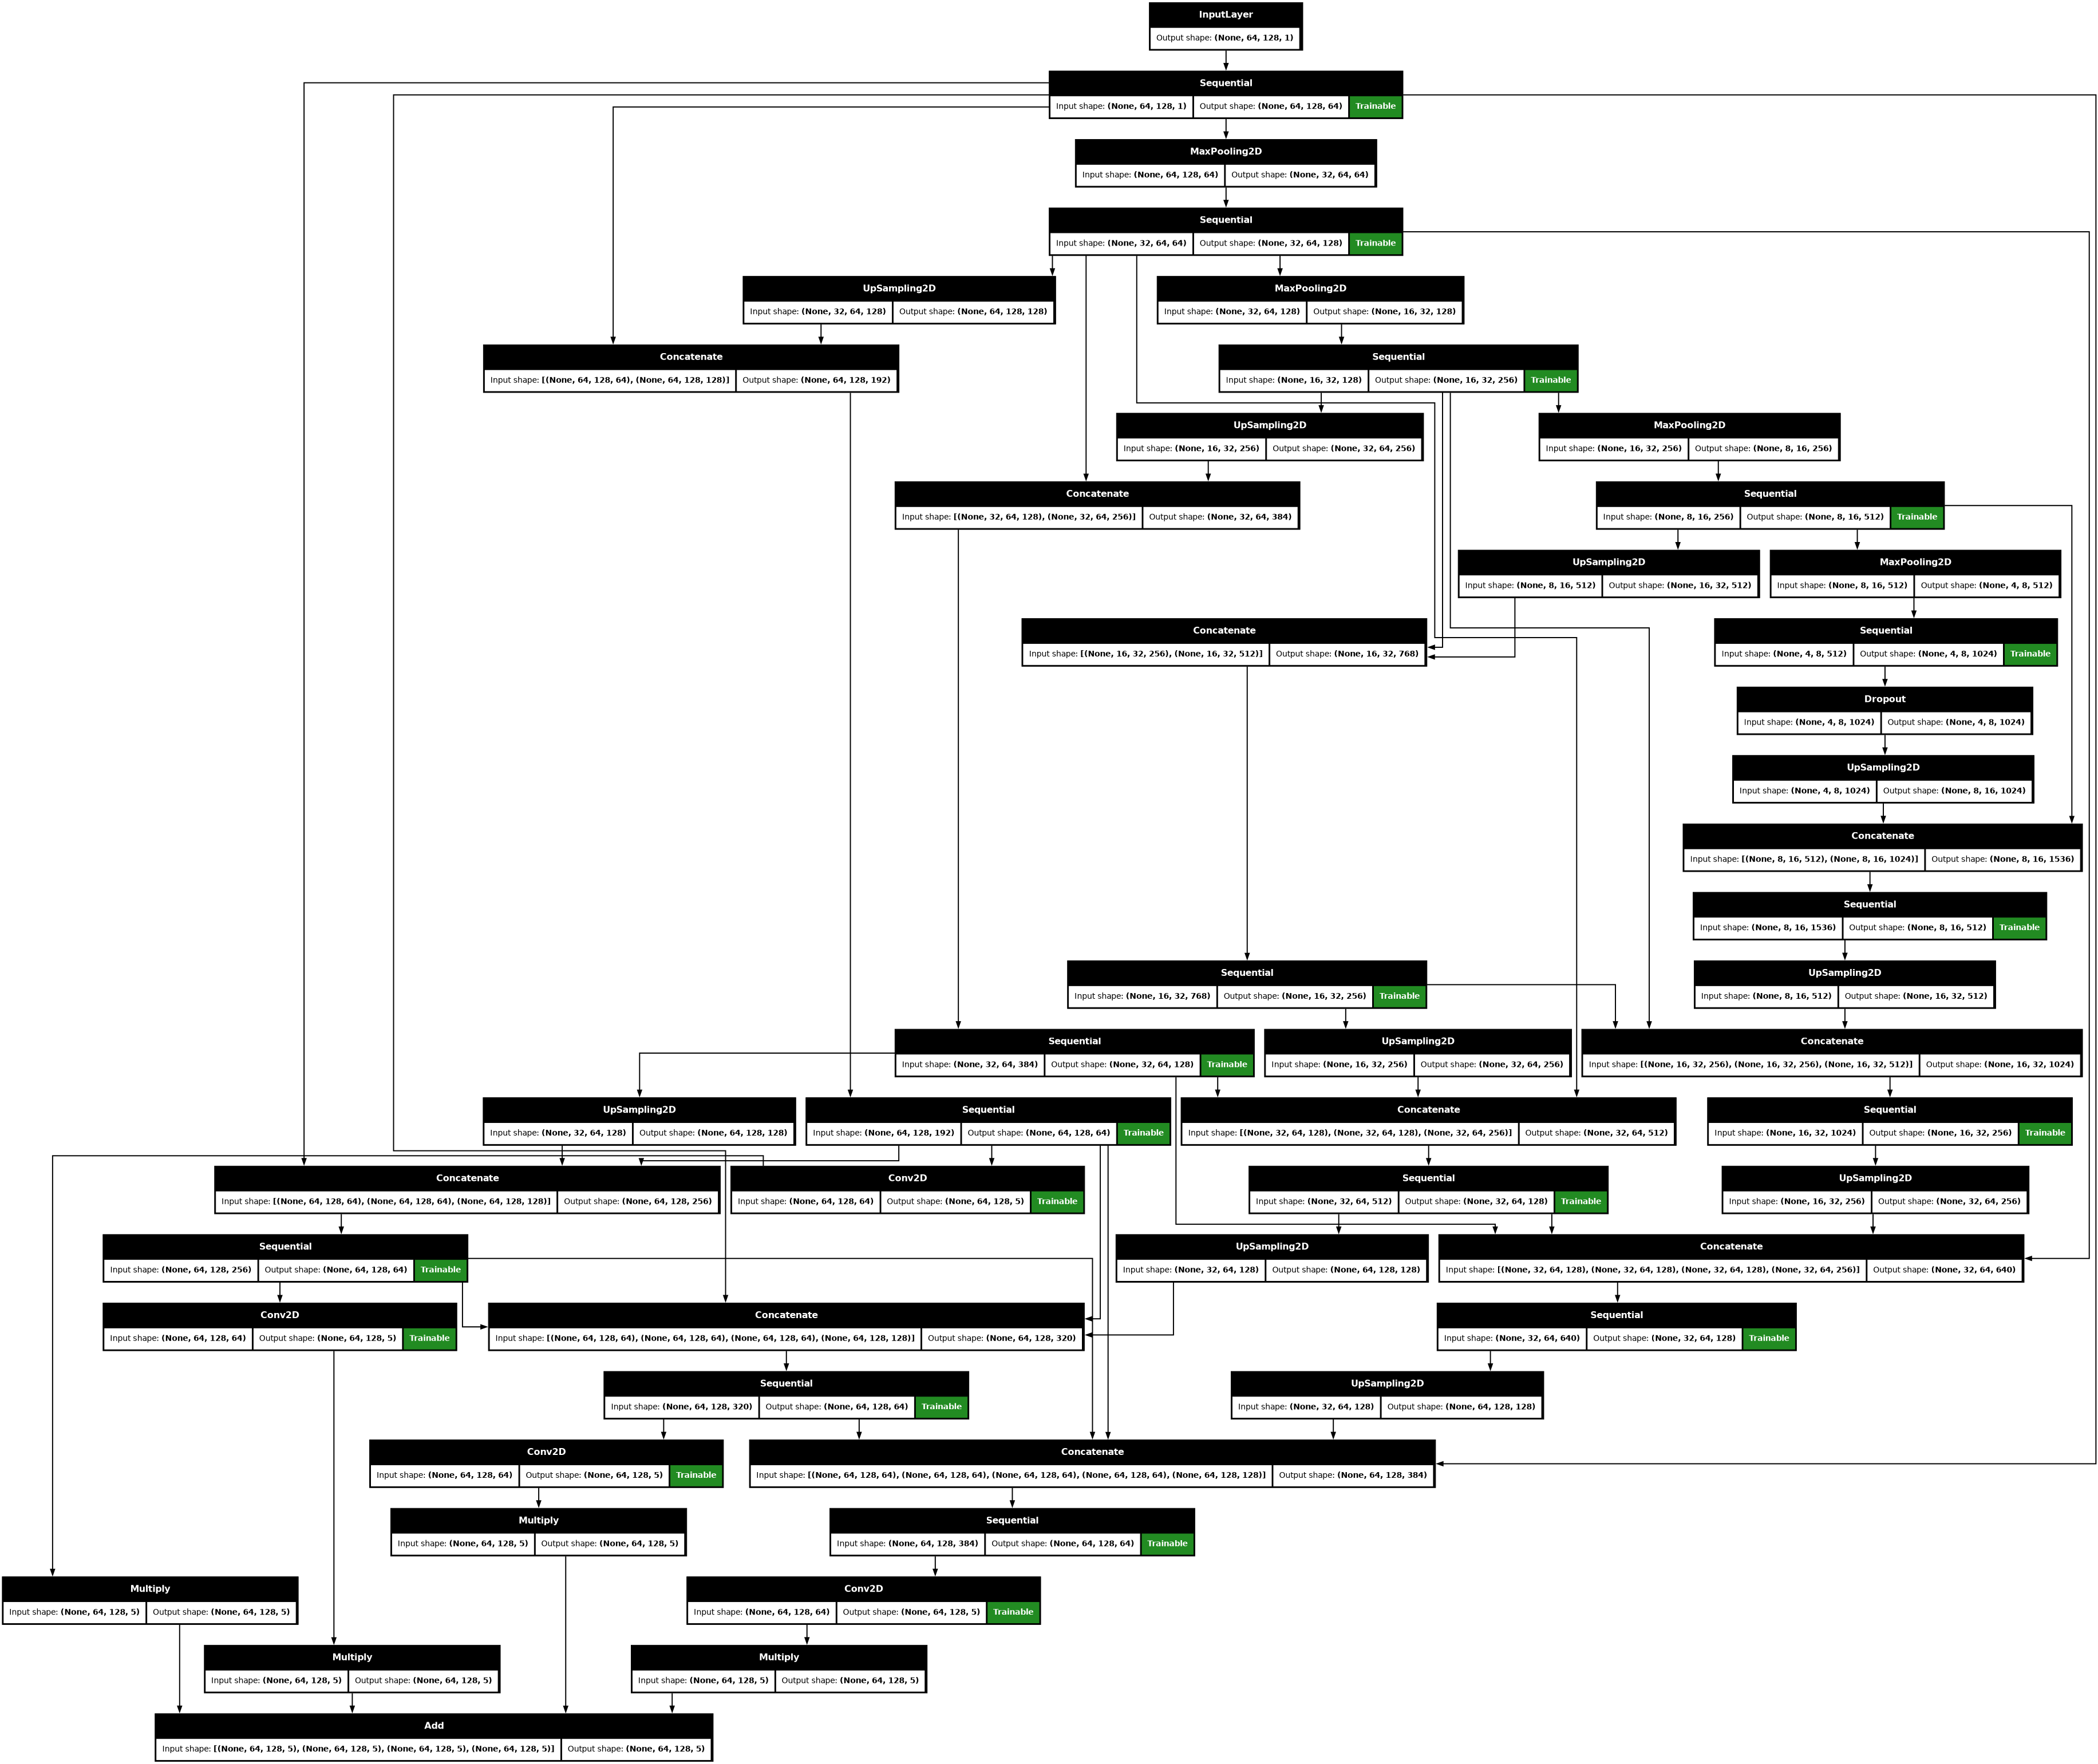

In [45]:


# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=False, show_shapes=True, dpi=70)

In [46]:
# Define the MeanIoU ignoring the background class
mean_iou = MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])
optimizer = tfk.optimizers.AdamW()

model.compile(
    loss=[combined_loss],
    optimizer=optimizer,
    metrics=["accuracy", mean_iou]
)


Showing evolution on image 109
Epoch 1/100


I0000 00:00:1733582627.933452      96 service.cc:145] XLA service 0x7c2d18003a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733582627.933503      96 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733582674.268524      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 444 bytes spill stores, 824 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1733582674.315077      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.3615 - loss: 0.8255 - mean_iou: 0.1813

I0000 00:00:1733582730.171796      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_53', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_35', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_43', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_1', 444 bytes spill stores, 824 bytes spill loads
ptxas warning : Registers are spilled to local memory in function '__cuda_sm3x_div_rn_noftz_f32_slowpath', 24 bytes spill stores, 24 bytes spill loads



63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - accuracy: 0.3619 - loss: 0.8250 - mean_iou: 0.1817

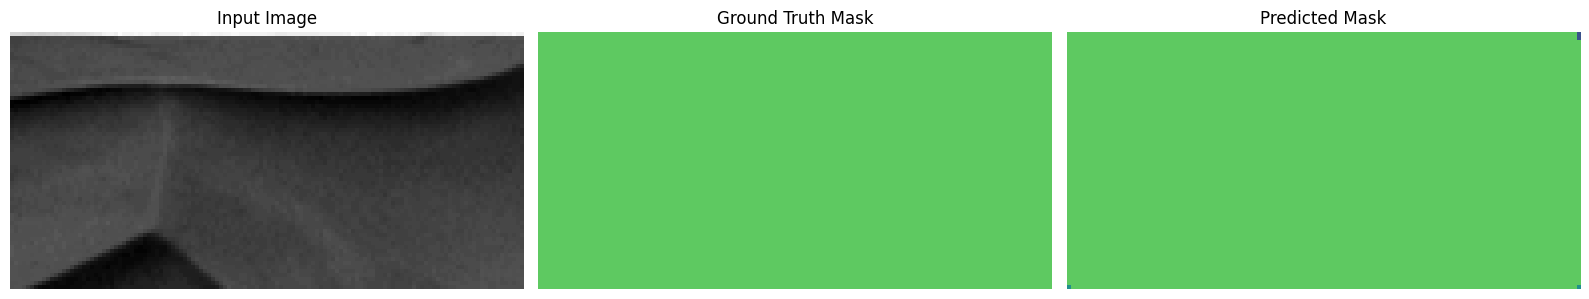

63/63 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.3622 - loss: 0.8245 - mean_iou: 0.1820 - val_accuracy: 0.1979 - val_loss: 1.4473 - val_mean_iou: 0.0657 - learning_rate: 0.0010
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4194 - loss: 0.7653 - mean_iou: 0.2420

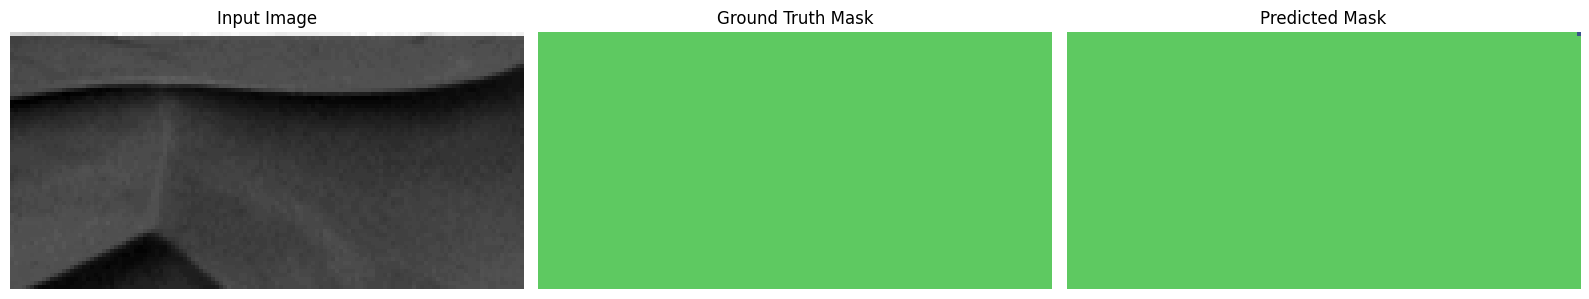

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.4195 - loss: 0.7653 - mean_iou: 0.2420 - val_accuracy: 0.1979 - val_loss: 2.2349 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4400 - loss: 0.7632 - mean_iou: 0.3056

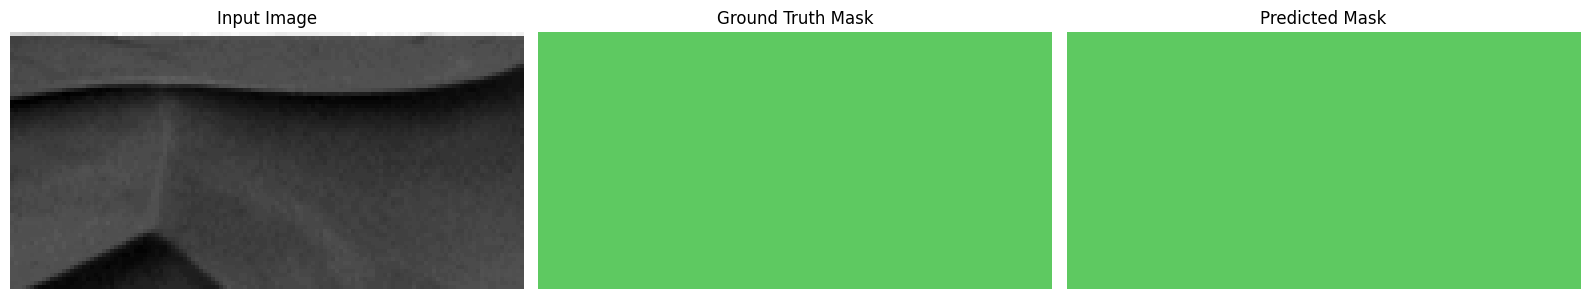

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.4402 - loss: 0.7631 - mean_iou: 0.3058 - val_accuracy: 0.1979 - val_loss: 2.1410 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4533 - loss: 0.7555 - mean_iou: 0.3141

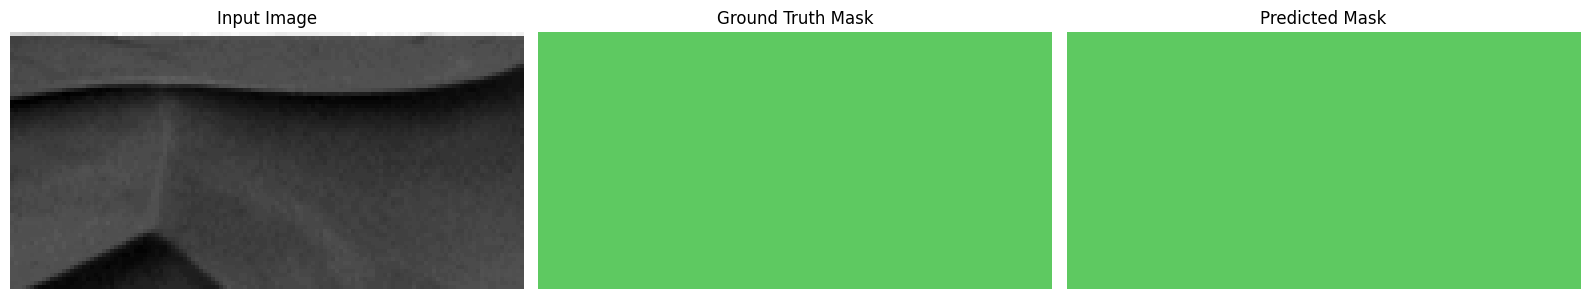

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.4533 - loss: 0.7554 - mean_iou: 0.3143 - val_accuracy: 0.1979 - val_loss: 1.1900 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4921 - loss: 0.7462 - mean_iou: 0.3661

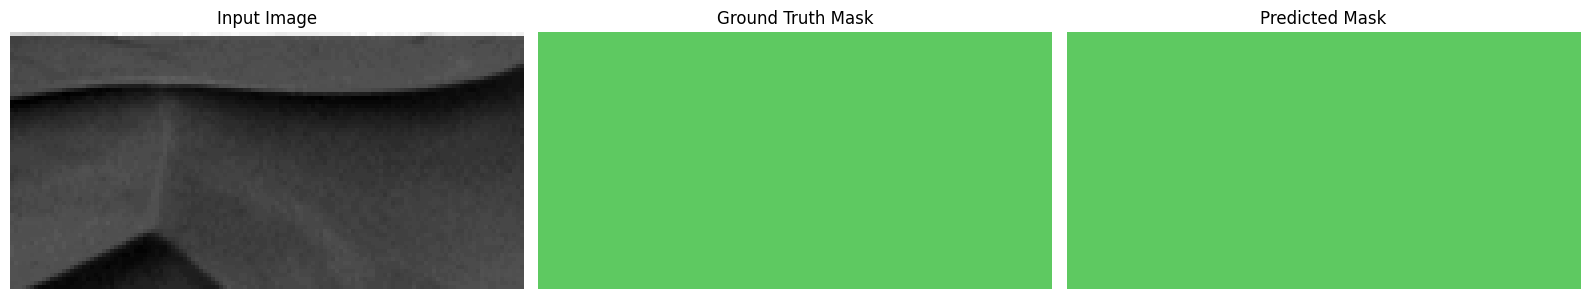

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 370ms/step - accuracy: 0.4920 - loss: 0.7462 - mean_iou: 0.3662 - val_accuracy: 0.1979 - val_loss: 1.0343 - val_mean_iou: 0.0656 - learning_rate: 0.0010
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.4952 - loss: 0.7457 - mean_iou: 0.3724

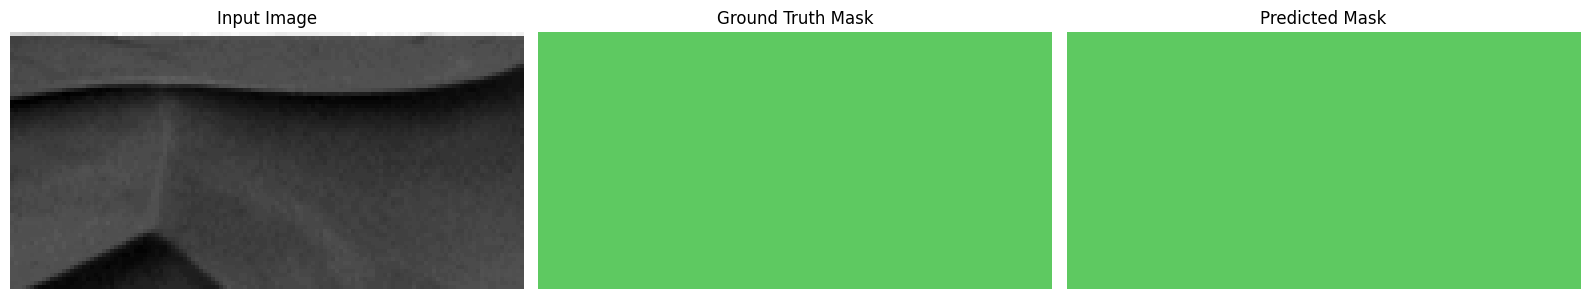

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.4953 - loss: 0.7456 - mean_iou: 0.3726 - val_accuracy: 0.2194 - val_loss: 1.0313 - val_mean_iou: 0.0833 - learning_rate: 0.0010
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5016 - loss: 0.7459 - mean_iou: 0.3744

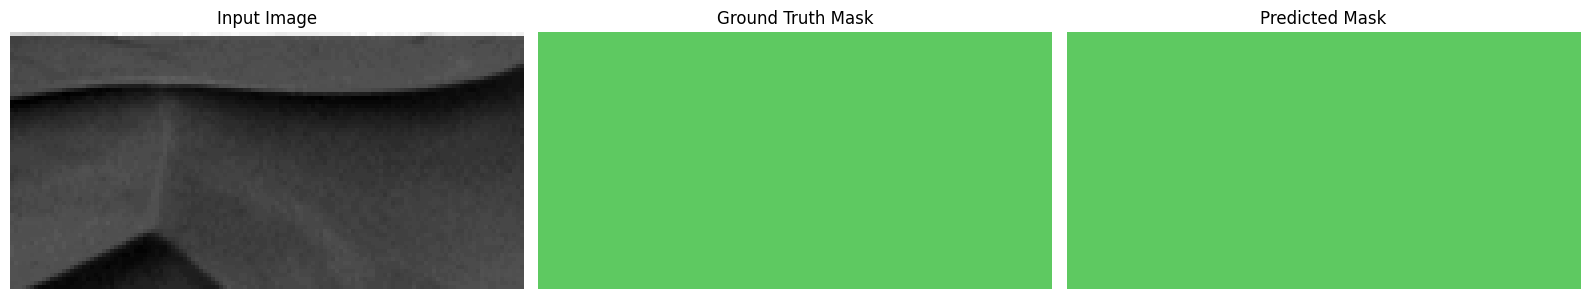

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 376ms/step - accuracy: 0.5019 - loss: 0.7458 - mean_iou: 0.3746 - val_accuracy: 0.3699 - val_loss: 0.8690 - val_mean_iou: 0.2026 - learning_rate: 0.0010
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5504 - loss: 0.7396 - mean_iou: 0.4273

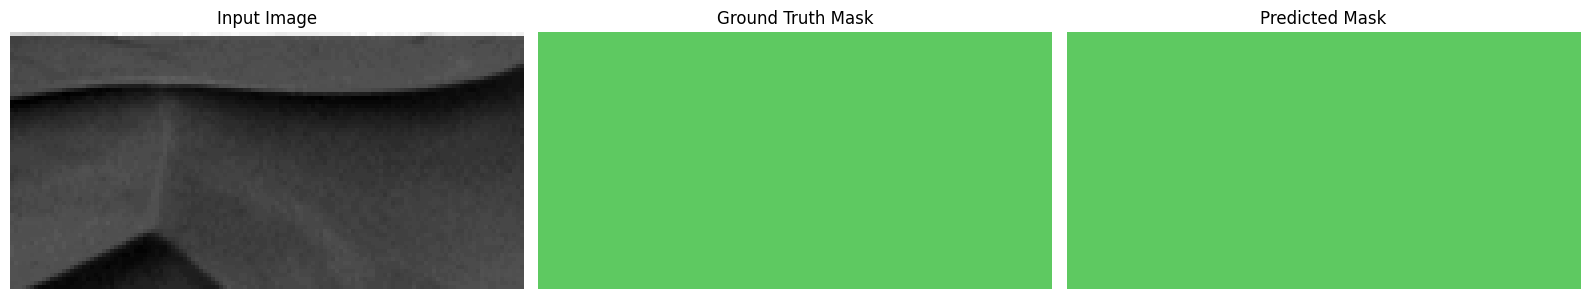

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.5504 - loss: 0.7395 - mean_iou: 0.4273 - val_accuracy: 0.2617 - val_loss: 0.8870 - val_mean_iou: 0.1351 - learning_rate: 0.0010
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5460 - loss: 0.7388 - mean_iou: 0.4234

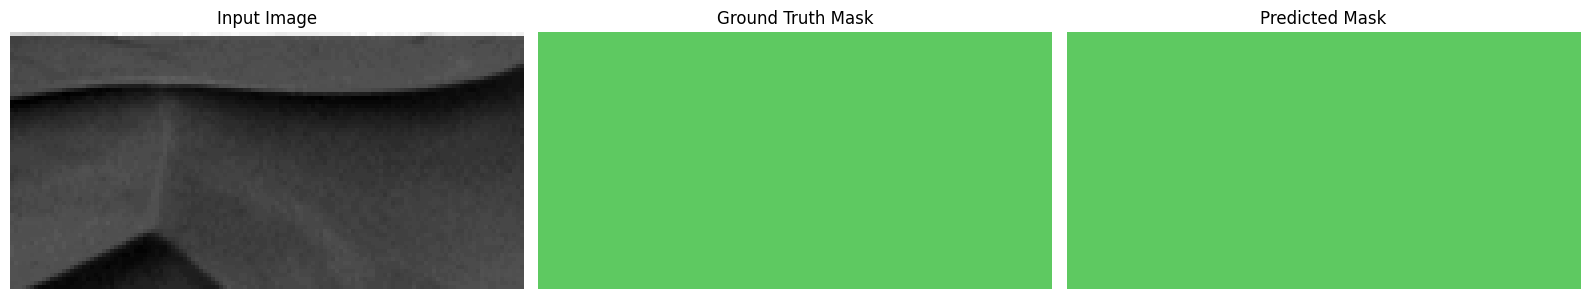

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.5462 - loss: 0.7386 - mean_iou: 0.4238 - val_accuracy: 0.3629 - val_loss: 0.8408 - val_mean_iou: 0.2554 - learning_rate: 0.0010
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5761 - loss: 0.7322 - mean_iou: 0.4609

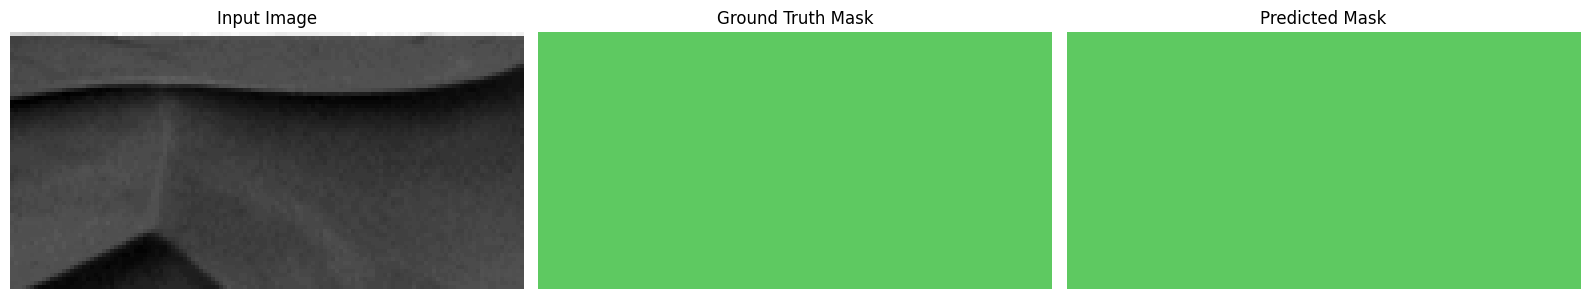

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 376ms/step - accuracy: 0.5761 - loss: 0.7321 - mean_iou: 0.4610 - val_accuracy: 0.5466 - val_loss: 0.7505 - val_mean_iou: 0.4243 - learning_rate: 0.0010
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5936 - loss: 0.7239 - mean_iou: 0.4830

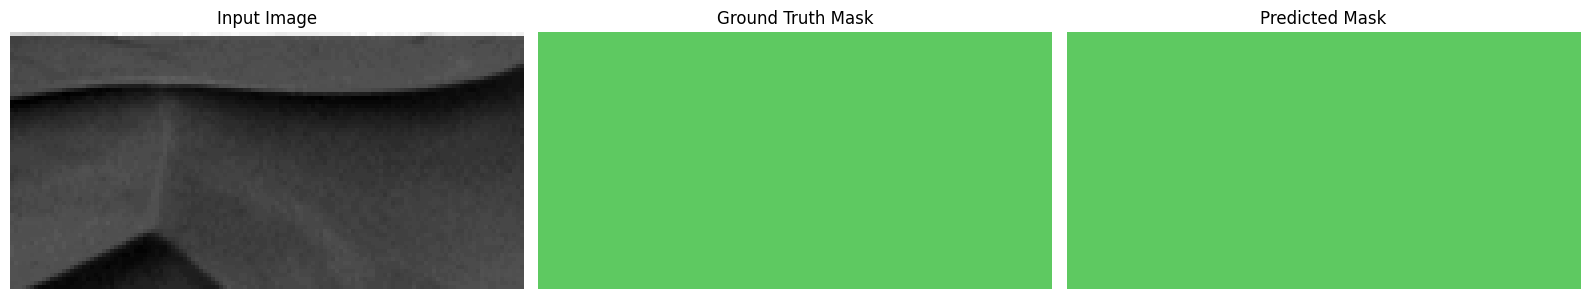

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.5936 - loss: 0.7238 - mean_iou: 0.4833 - val_accuracy: 0.3973 - val_loss: 0.8016 - val_mean_iou: 0.2925 - learning_rate: 0.0010
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5796 - loss: 0.7285 - mean_iou: 0.4723

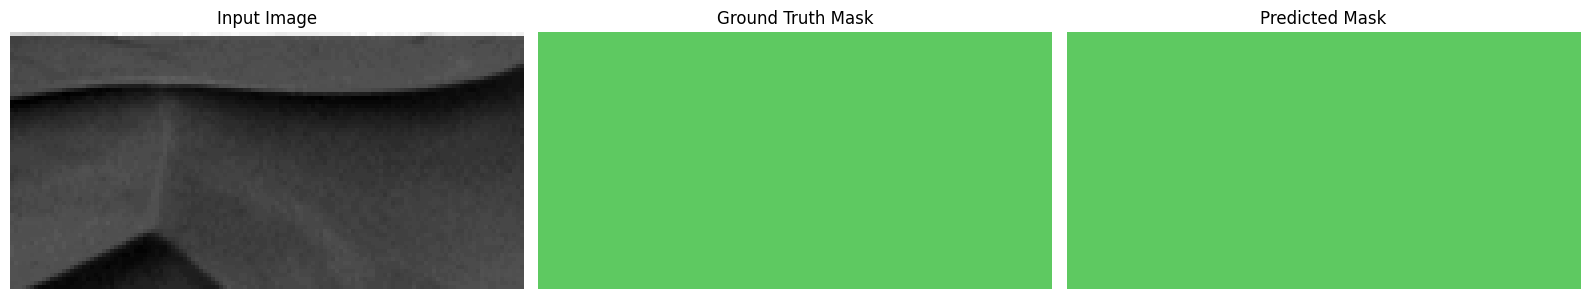

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.5796 - loss: 0.7284 - mean_iou: 0.4724 - val_accuracy: 0.5413 - val_loss: 0.7674 - val_mean_iou: 0.4419 - learning_rate: 0.0010
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5941 - loss: 0.7261 - mean_iou: 0.4880

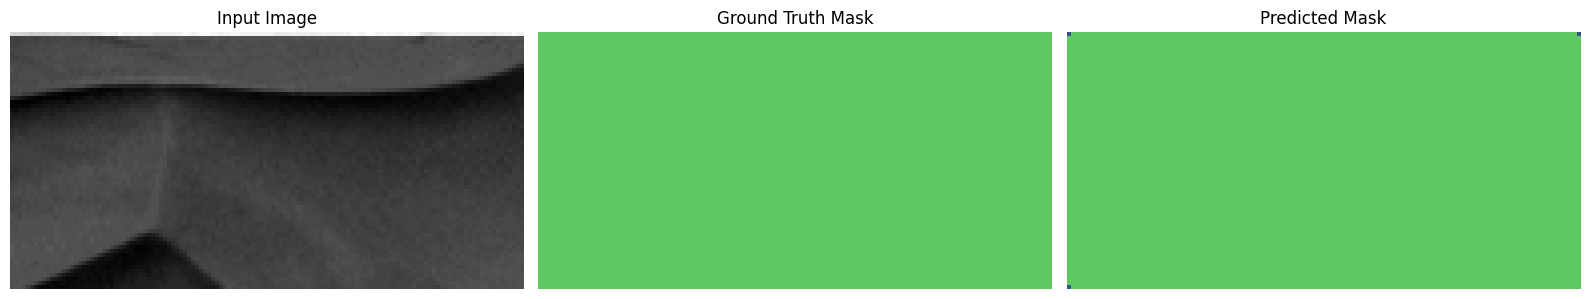

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.5941 - loss: 0.7260 - mean_iou: 0.4881 - val_accuracy: 0.4481 - val_loss: 0.7568 - val_mean_iou: 0.3483 - learning_rate: 0.0010
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5945 - loss: 0.7213 - mean_iou: 0.4905

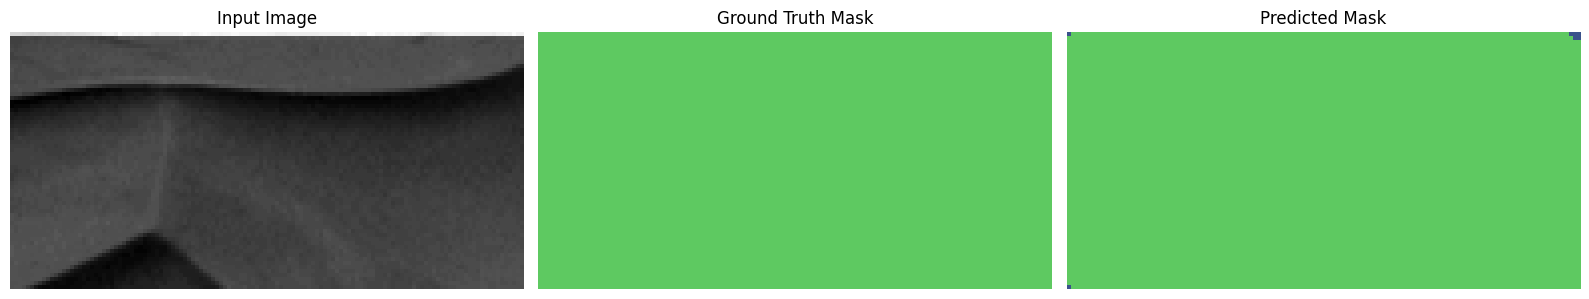

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 376ms/step - accuracy: 0.5946 - loss: 0.7213 - mean_iou: 0.4907 - val_accuracy: 0.5921 - val_loss: 0.7329 - val_mean_iou: 0.4822 - learning_rate: 0.0010
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6077 - loss: 0.7229 - mean_iou: 0.5004

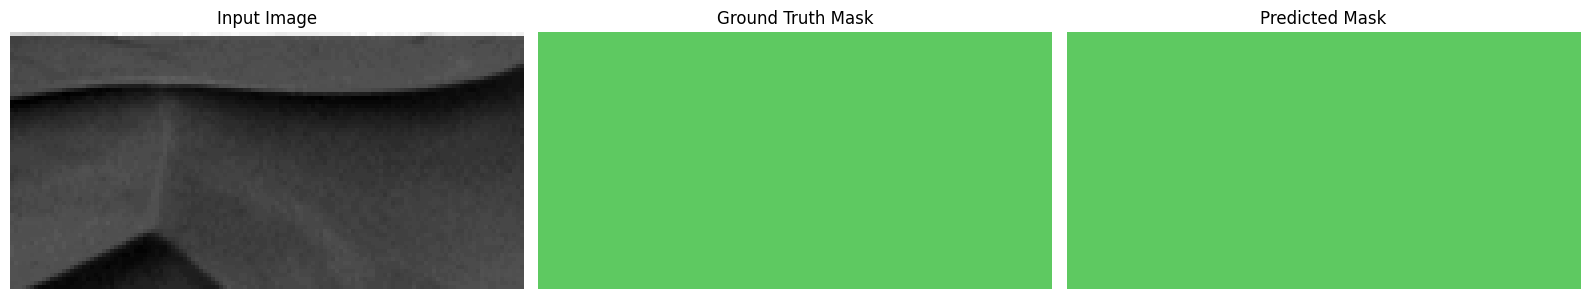

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6078 - loss: 0.7229 - mean_iou: 0.5006 - val_accuracy: 0.5300 - val_loss: 0.7519 - val_mean_iou: 0.4129 - learning_rate: 0.0010
Epoch 16/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6128 - loss: 0.7224 - mean_iou: 0.5063

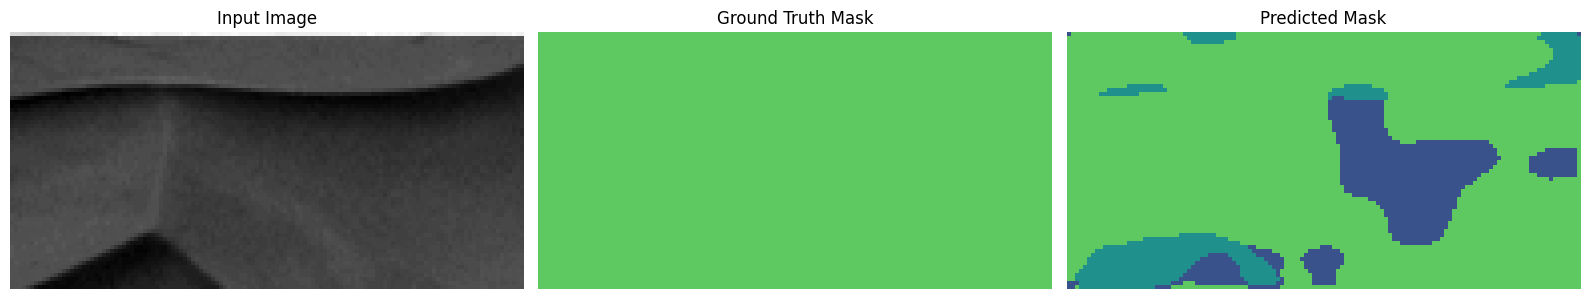

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6129 - loss: 0.7223 - mean_iou: 0.5066 - val_accuracy: 0.5189 - val_loss: 0.7538 - val_mean_iou: 0.3930 - learning_rate: 0.0010
Epoch 17/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6277 - loss: 0.7183 - mean_iou: 0.5247

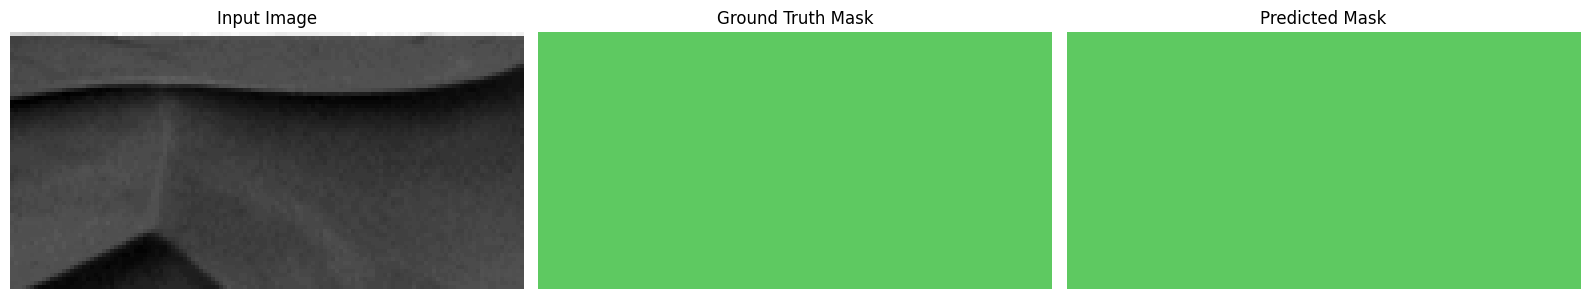

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6277 - loss: 0.7183 - mean_iou: 0.5248 - val_accuracy: 0.5749 - val_loss: 0.7339 - val_mean_iou: 0.4505 - learning_rate: 0.0010
Epoch 18/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6179 - loss: 0.7178 - mean_iou: 0.5136

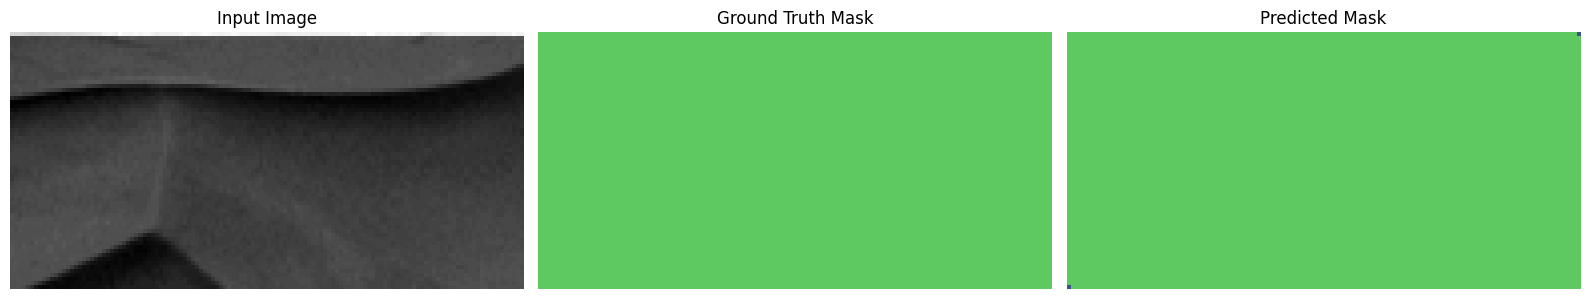

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6179 - loss: 0.7177 - mean_iou: 0.5138 - val_accuracy: 0.5962 - val_loss: 0.7210 - val_mean_iou: 0.5074 - learning_rate: 0.0010
Epoch 19/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5873 - loss: 0.7233 - mean_iou: 0.4826

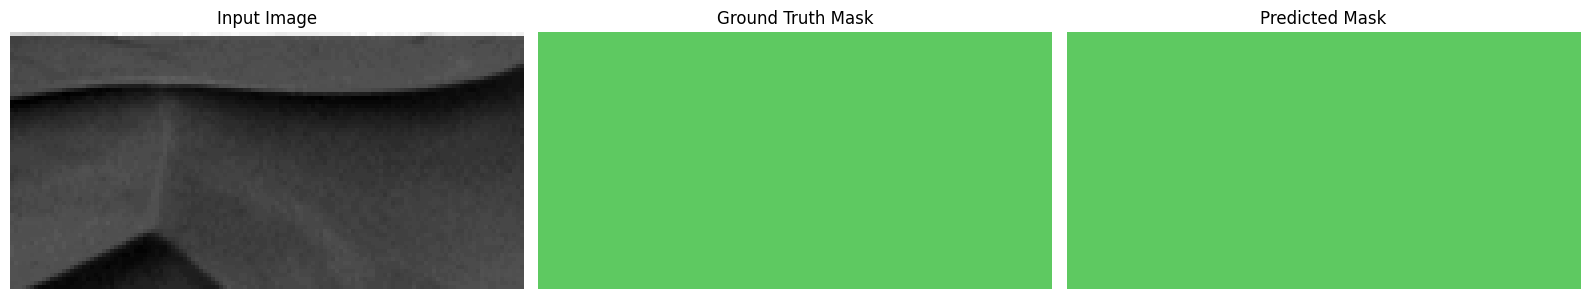

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.5873 - loss: 0.7231 - mean_iou: 0.4828 - val_accuracy: 0.5409 - val_loss: 0.7525 - val_mean_iou: 0.4408 - learning_rate: 0.0010
Epoch 20/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5903 - loss: 0.7225 - mean_iou: 0.4856

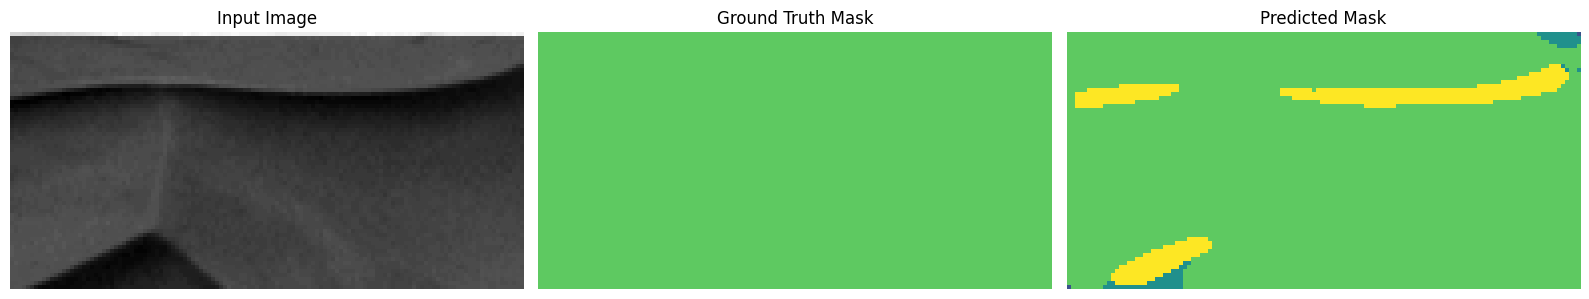

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.5906 - loss: 0.7222 - mean_iou: 0.4861 - val_accuracy: 0.4652 - val_loss: 0.8250 - val_mean_iou: 0.3762 - learning_rate: 0.0010
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6008 - loss: 0.7189 - mean_iou: 0.5003

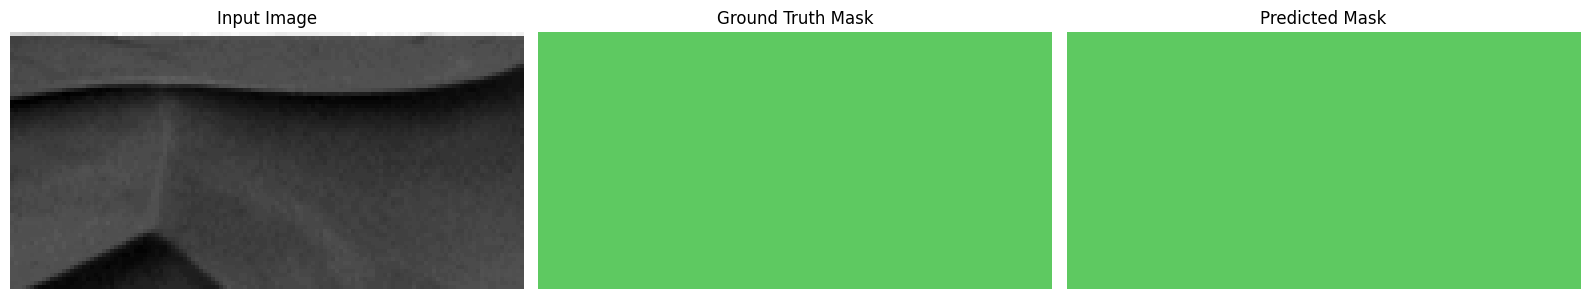

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6010 - loss: 0.7186 - mean_iou: 0.5007 - val_accuracy: 0.4891 - val_loss: 0.7342 - val_mean_iou: 0.4089 - learning_rate: 0.0010
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6221 - loss: 0.7096 - mean_iou: 0.5290

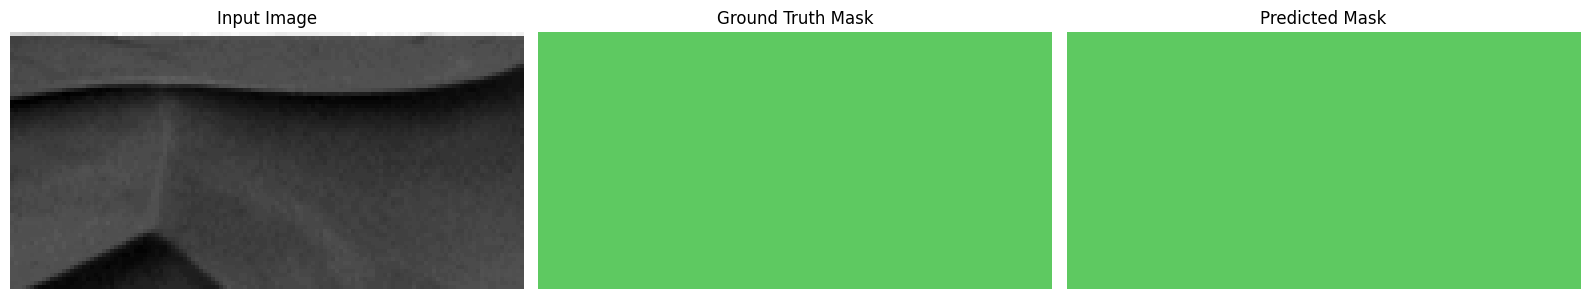

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6221 - loss: 0.7096 - mean_iou: 0.5291 - val_accuracy: 0.5343 - val_loss: 0.7510 - val_mean_iou: 0.4158 - learning_rate: 0.0010
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6254 - loss: 0.7152 - mean_iou: 0.5259

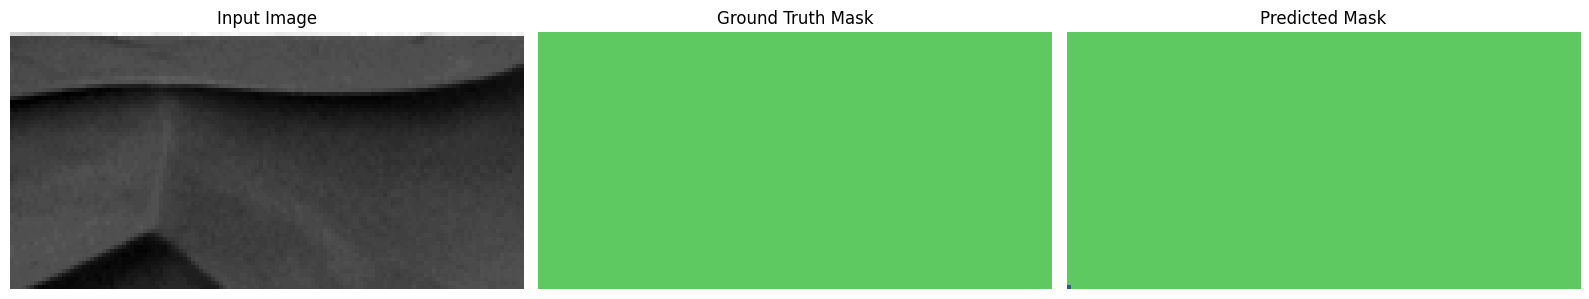

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6253 - loss: 0.7151 - mean_iou: 0.5260 - val_accuracy: 0.4561 - val_loss: 0.7479 - val_mean_iou: 0.3586 - learning_rate: 0.0010
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6148 - loss: 0.7111 - mean_iou: 0.5198

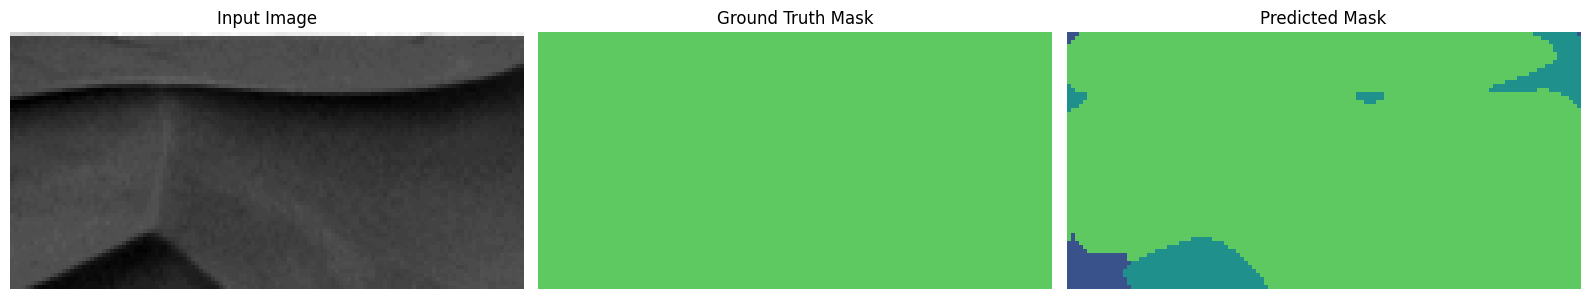

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6148 - loss: 0.7109 - mean_iou: 0.5200 - val_accuracy: 0.5051 - val_loss: 0.7660 - val_mean_iou: 0.3690 - learning_rate: 0.0010
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6017 - loss: 0.7148 - mean_iou: 0.5015

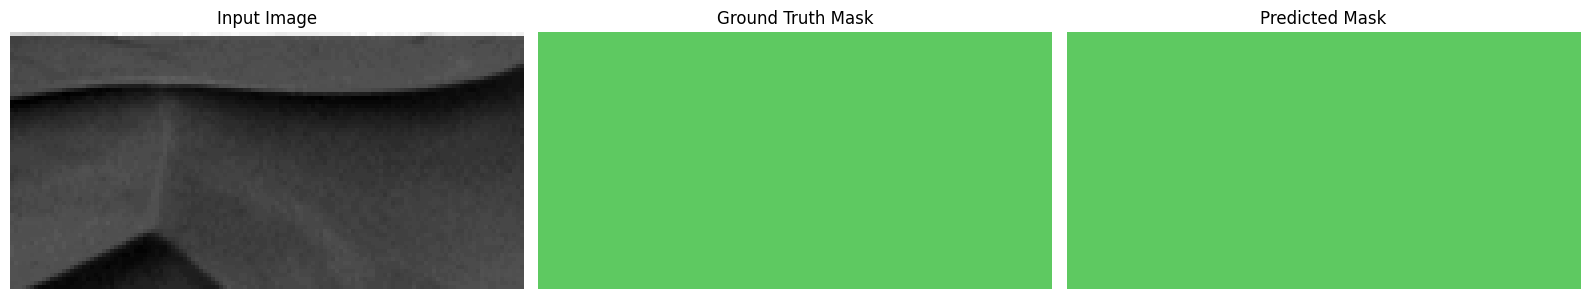

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6019 - loss: 0.7147 - mean_iou: 0.5018 - val_accuracy: 0.5695 - val_loss: 0.7169 - val_mean_iou: 0.4708 - learning_rate: 0.0010
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6157 - loss: 0.7078 - mean_iou: 0.5236

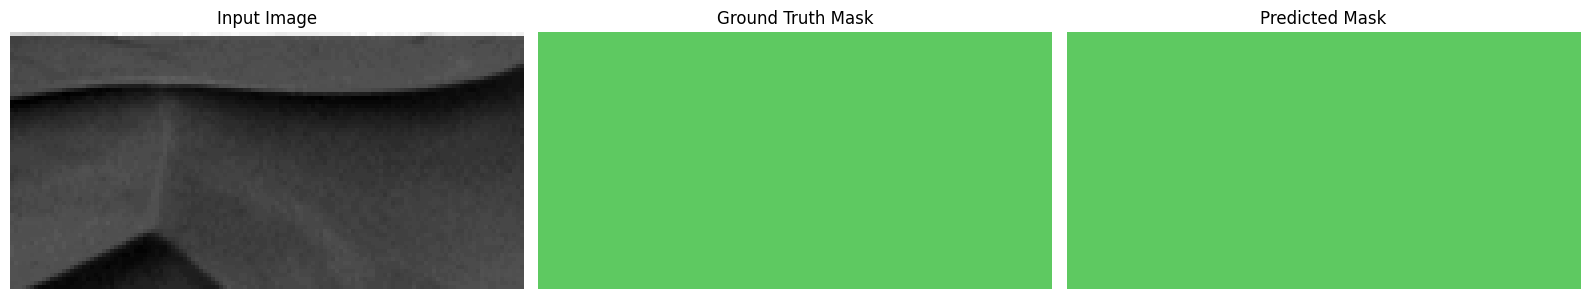

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6159 - loss: 0.7077 - mean_iou: 0.5240 - val_accuracy: 0.4978 - val_loss: 0.7309 - val_mean_iou: 0.3709 - learning_rate: 0.0010
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6303 - loss: 0.7042 - mean_iou: 0.5377

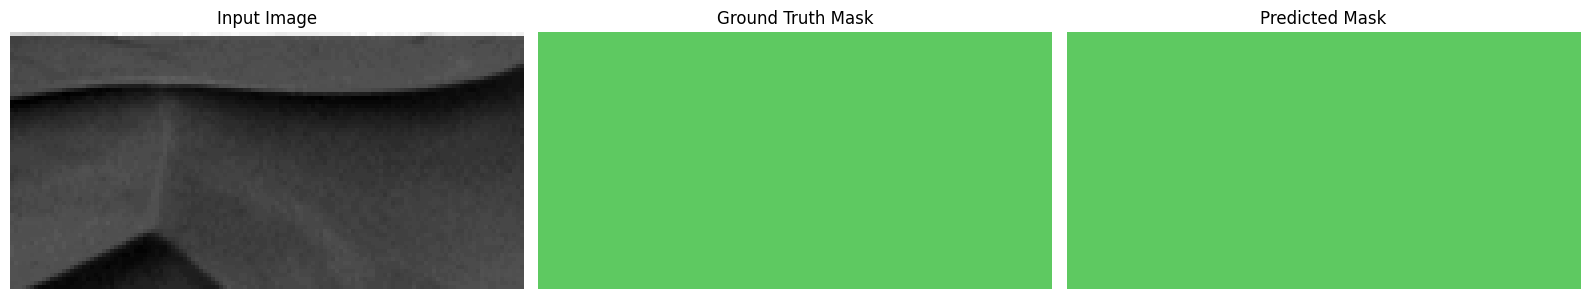

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6303 - loss: 0.7041 - mean_iou: 0.5379 - val_accuracy: 0.4868 - val_loss: 0.7888 - val_mean_iou: 0.3814 - learning_rate: 0.0010
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6214 - loss: 0.7088 - mean_iou: 0.5294

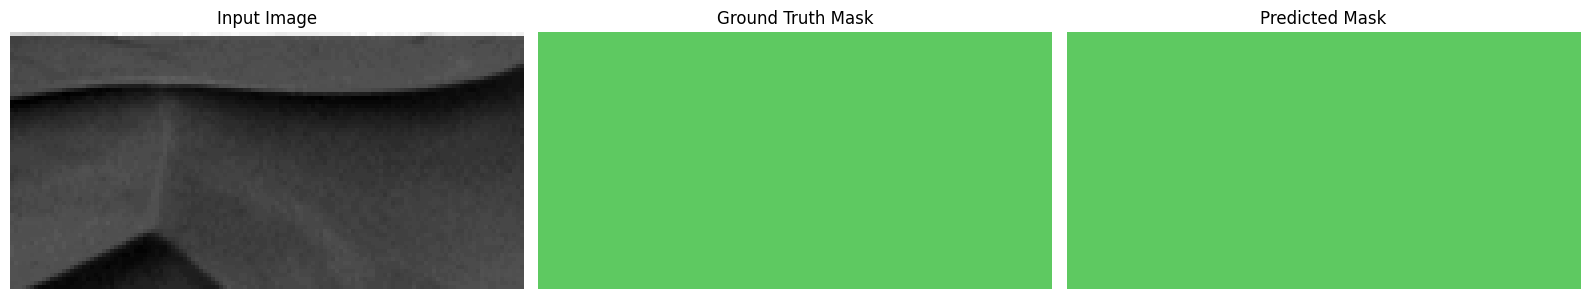

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6214 - loss: 0.7086 - mean_iou: 0.5296 - val_accuracy: 0.4040 - val_loss: 0.8036 - val_mean_iou: 0.3166 - learning_rate: 0.0010
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6285 - loss: 0.7039 - mean_iou: 0.5393

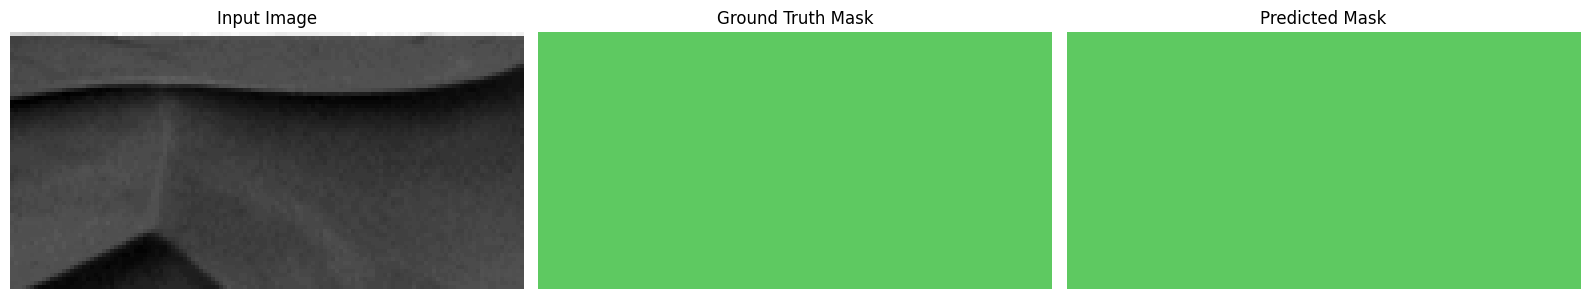

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.6286 - loss: 0.7037 - mean_iou: 0.5395 - val_accuracy: 0.4094 - val_loss: 0.7839 - val_mean_iou: 0.3072 - learning_rate: 0.0010
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6333 - loss: 0.6947 - mean_iou: 0.5500

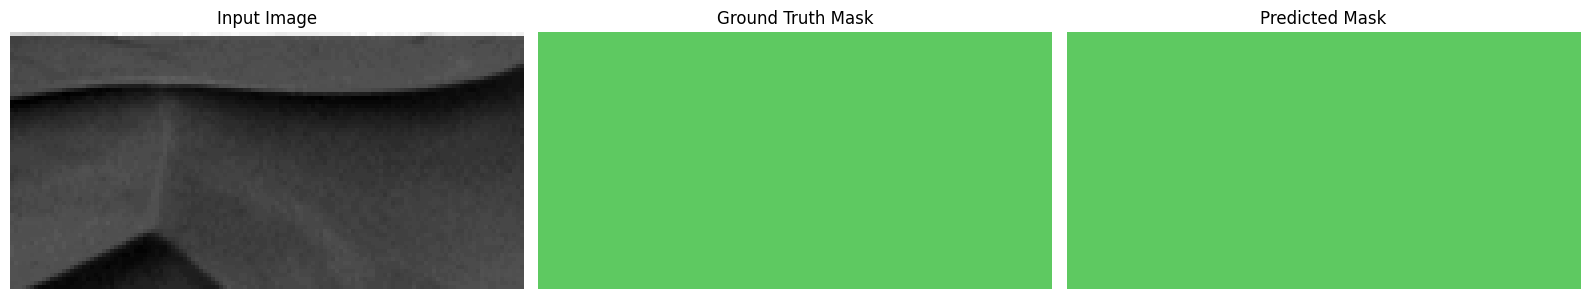

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6333 - loss: 0.6946 - mean_iou: 0.5502 - val_accuracy: 0.4937 - val_loss: 0.7469 - val_mean_iou: 0.3636 - learning_rate: 0.0010
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6254 - loss: 0.6971 - mean_iou: 0.5392

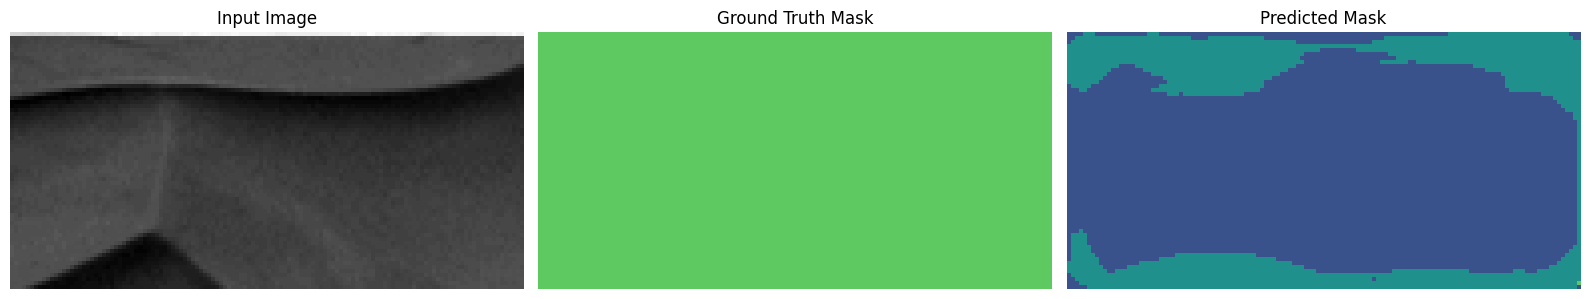

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.6255 - loss: 0.6970 - mean_iou: 0.5395 - val_accuracy: 0.4002 - val_loss: 0.8830 - val_mean_iou: 0.2181 - learning_rate: 0.0010
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6346 - loss: 0.6998 - mean_iou: 0.5492

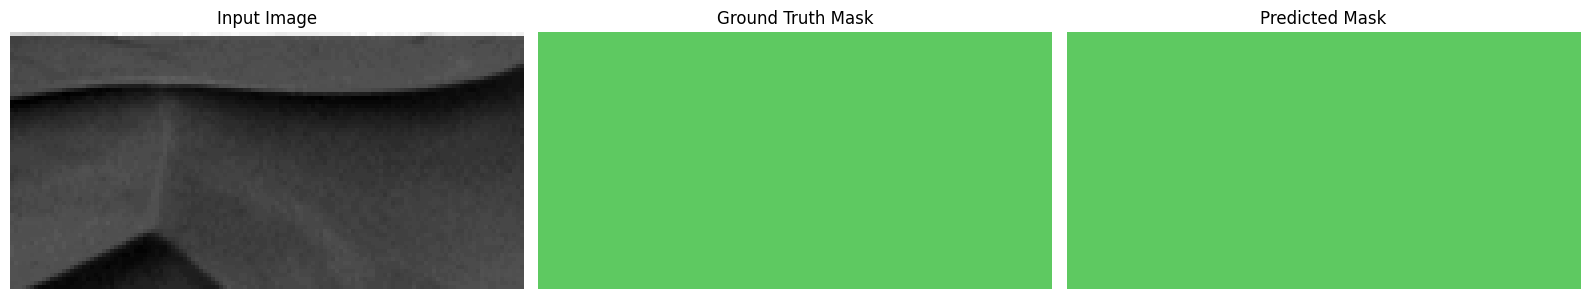

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6346 - loss: 0.6996 - mean_iou: 0.5494 - val_accuracy: 0.5525 - val_loss: 0.7249 - val_mean_iou: 0.4343 - learning_rate: 0.0010
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6228 - loss: 0.7017 - mean_iou: 0.5330

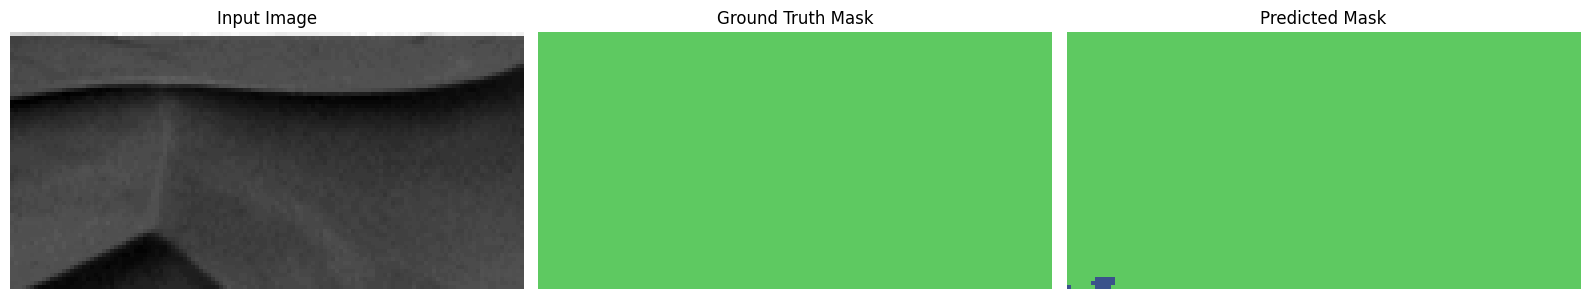

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 383ms/step - accuracy: 0.6228 - loss: 0.7016 - mean_iou: 0.5332 - val_accuracy: 0.5306 - val_loss: 0.8105 - val_mean_iou: 0.4467 - learning_rate: 0.0010
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6283 - loss: 0.6989 - mean_iou: 0.5378

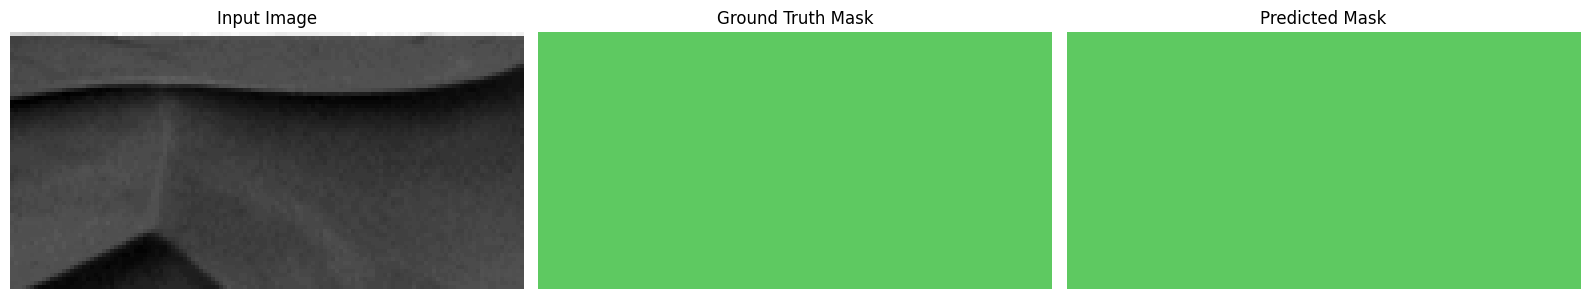

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6283 - loss: 0.6987 - mean_iou: 0.5380 - val_accuracy: 0.5033 - val_loss: 0.7271 - val_mean_iou: 0.3880 - learning_rate: 0.0010
Epoch 35/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6325 - loss: 0.6859 - mean_iou: 0.5495

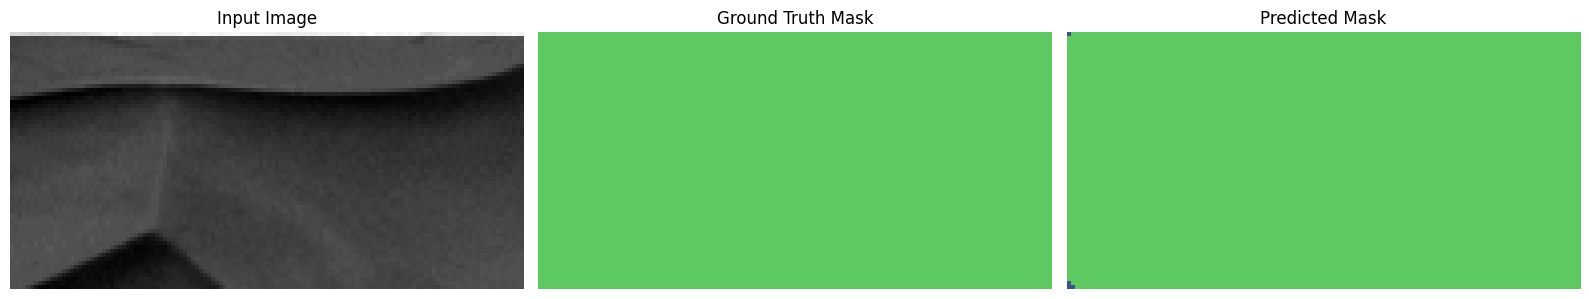

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6326 - loss: 0.6859 - mean_iou: 0.5496 - val_accuracy: 0.4615 - val_loss: 0.7860 - val_mean_iou: 0.3497 - learning_rate: 0.0010
Epoch 36/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6367 - loss: 0.6855 - mean_iou: 0.5557

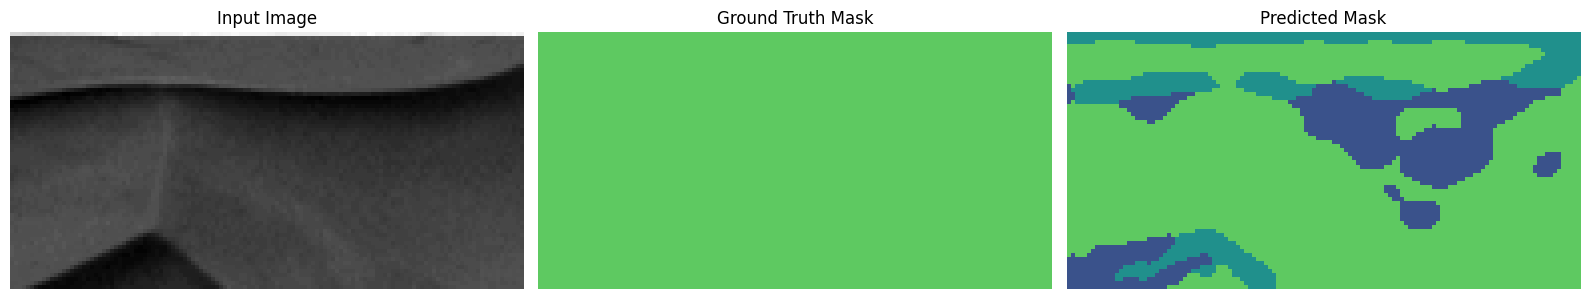

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6367 - loss: 0.6854 - mean_iou: 0.5558 - val_accuracy: 0.4209 - val_loss: 0.7895 - val_mean_iou: 0.2702 - learning_rate: 0.0010
Epoch 37/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6214 - loss: 0.6852 - mean_iou: 0.5360

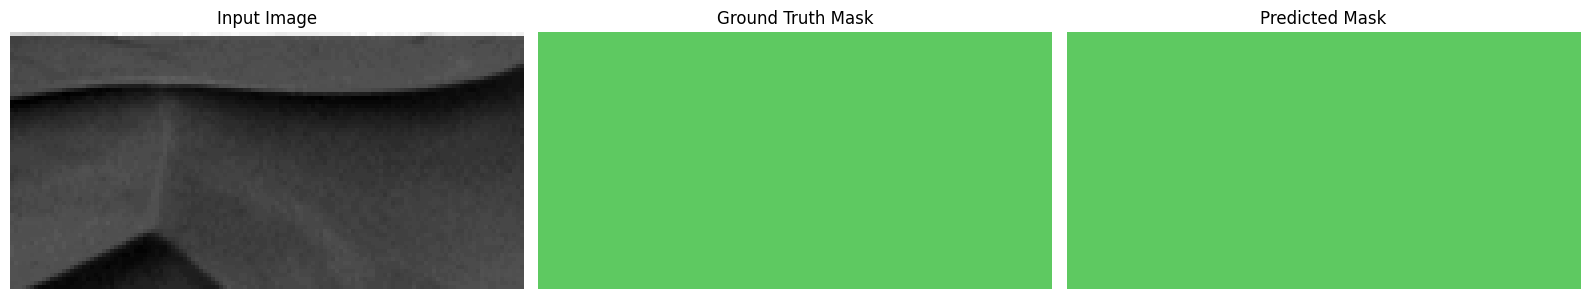

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6216 - loss: 0.6852 - mean_iou: 0.5363 - val_accuracy: 0.5936 - val_loss: 0.7176 - val_mean_iou: 0.4854 - learning_rate: 0.0010
Epoch 38/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6364 - loss: 0.6726 - mean_iou: 0.5597

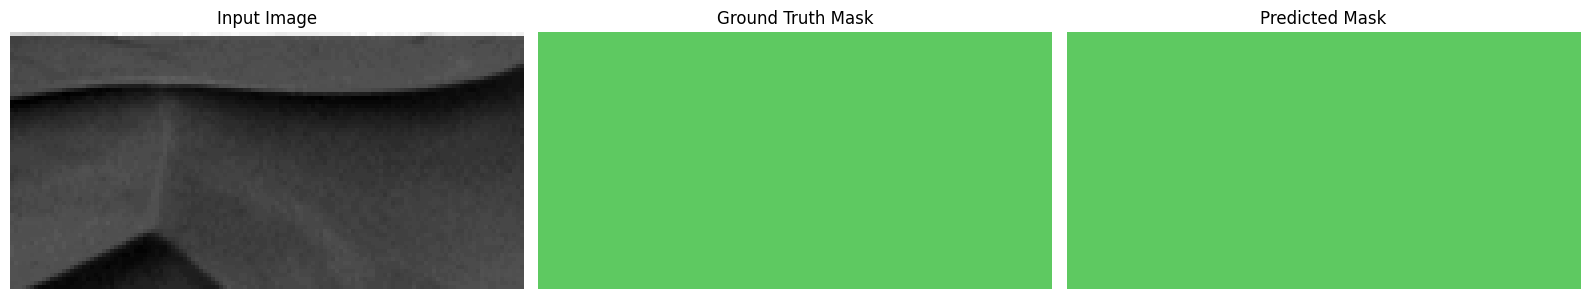

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6365 - loss: 0.6726 - mean_iou: 0.5599 - val_accuracy: 0.5124 - val_loss: 0.7673 - val_mean_iou: 0.4021 - learning_rate: 0.0010
Epoch 39/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6444 - loss: 0.6618 - mean_iou: 0.5673

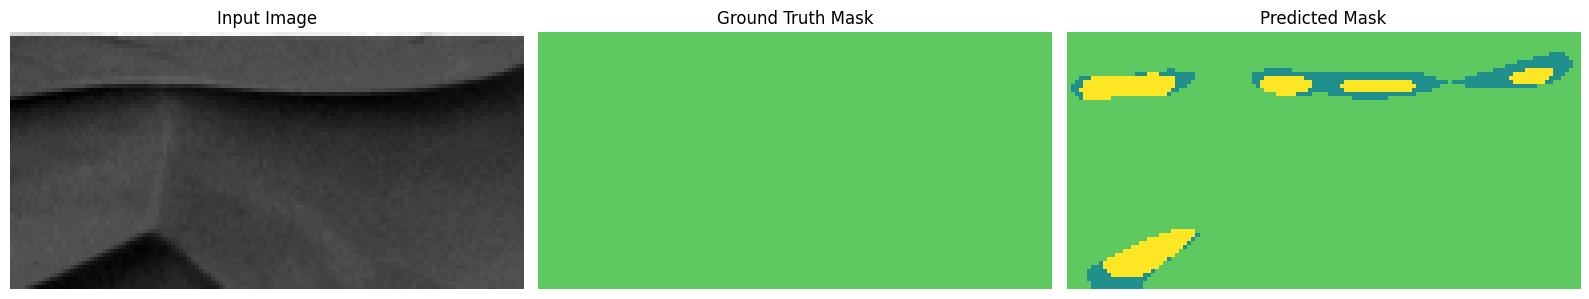

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6444 - loss: 0.6619 - mean_iou: 0.5673 - val_accuracy: 0.4447 - val_loss: 0.7880 - val_mean_iou: 0.3558 - learning_rate: 0.0010
Epoch 40/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6444 - loss: 0.6575 - mean_iou: 0.5763

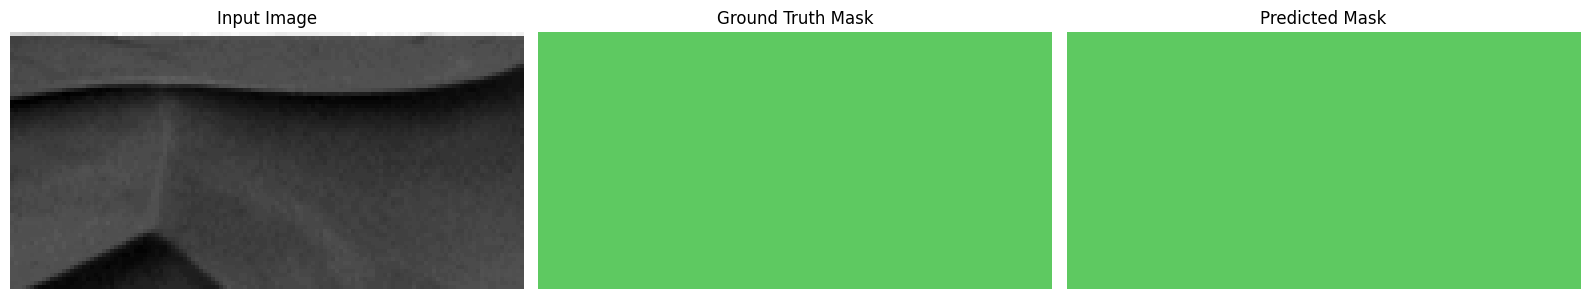

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6445 - loss: 0.6576 - mean_iou: 0.5765 - val_accuracy: 0.5201 - val_loss: 0.7261 - val_mean_iou: 0.4423 - learning_rate: 0.0010
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6510 - loss: 0.6480 - mean_iou: 0.5892

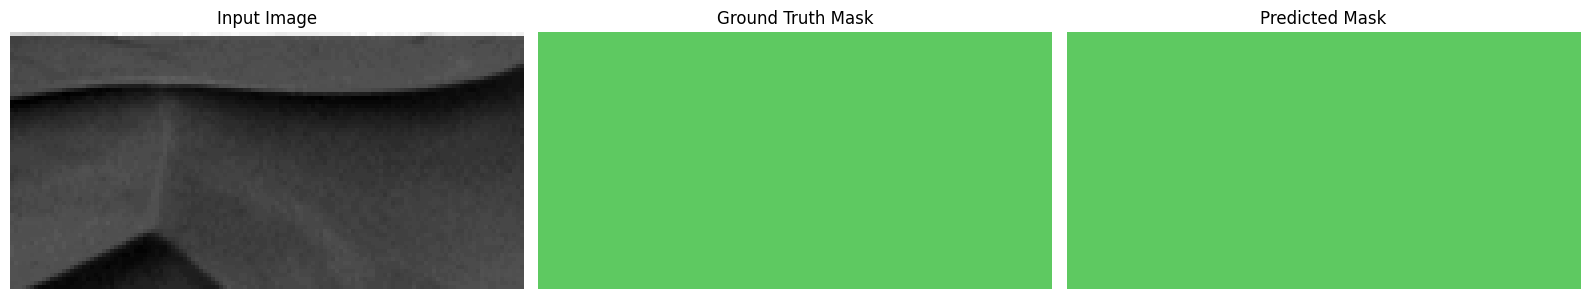

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.6511 - loss: 0.6483 - mean_iou: 0.5892 - val_accuracy: 0.5541 - val_loss: 0.7131 - val_mean_iou: 0.4760 - learning_rate: 0.0010
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6486 - loss: 0.6542 - mean_iou: 0.5827

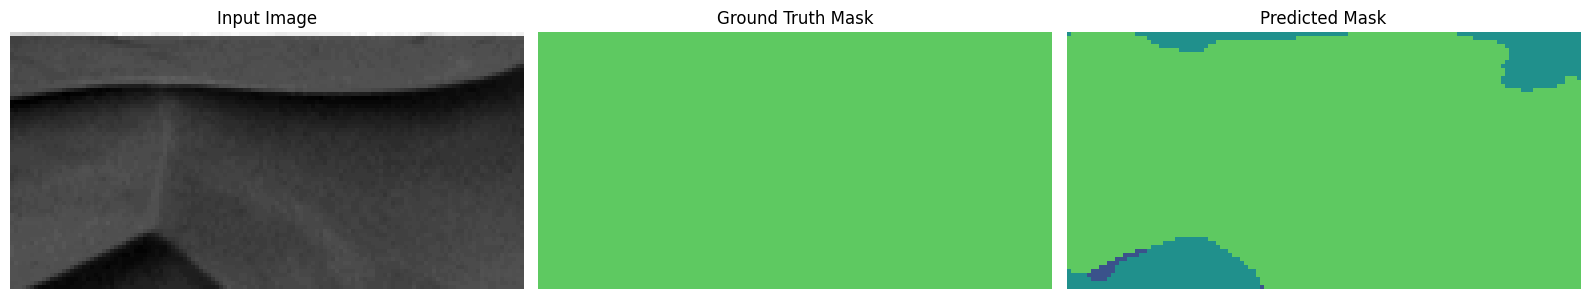

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6485 - loss: 0.6545 - mean_iou: 0.5826 - val_accuracy: 0.5172 - val_loss: 0.7365 - val_mean_iou: 0.3946 - learning_rate: 0.0010
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6287 - loss: 0.6611 - mean_iou: 0.5588

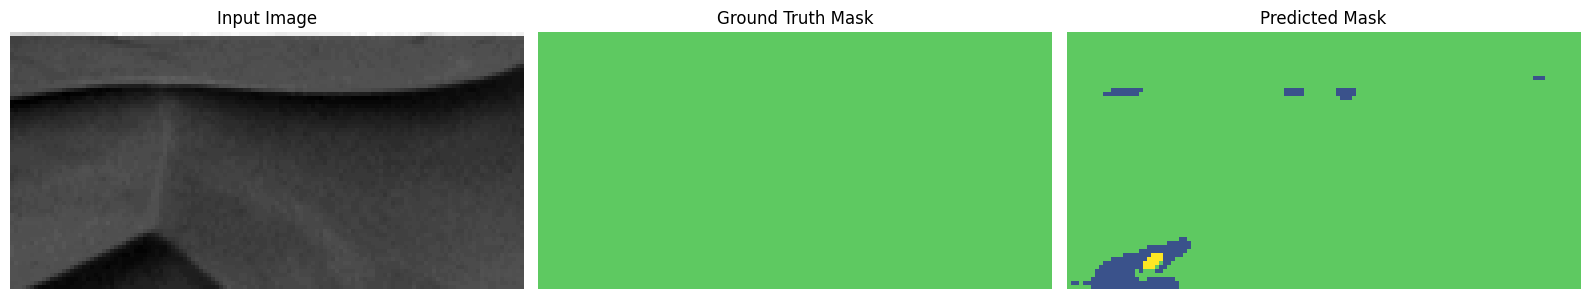

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6287 - loss: 0.6612 - mean_iou: 0.5590 - val_accuracy: 0.4347 - val_loss: 1.0372 - val_mean_iou: 0.3684 - learning_rate: 0.0010
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6407 - loss: 0.6703 - mean_iou: 0.5711

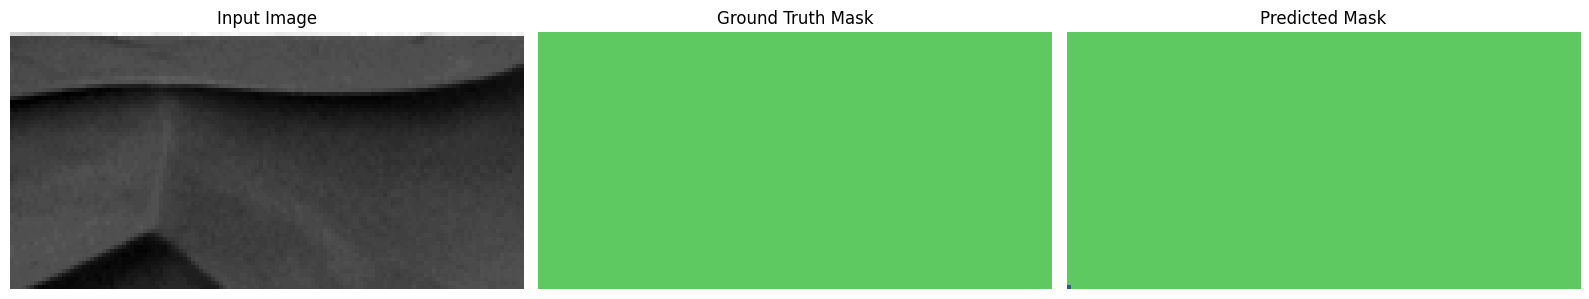

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 377ms/step - accuracy: 0.6408 - loss: 0.6703 - mean_iou: 0.5713 - val_accuracy: 0.6203 - val_loss: 0.6994 - val_mean_iou: 0.5561 - learning_rate: 0.0010
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6439 - loss: 0.6361 - mean_iou: 0.5845

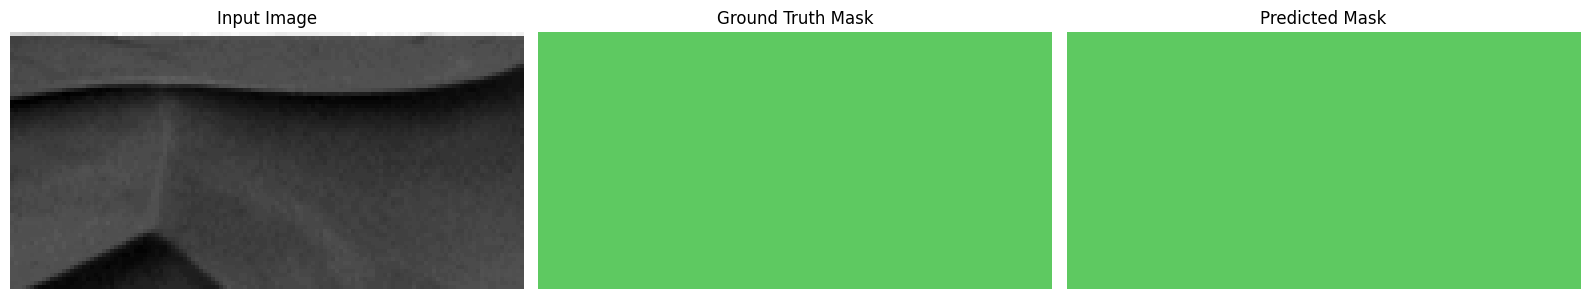

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.6440 - loss: 0.6364 - mean_iou: 0.5846 - val_accuracy: 0.5918 - val_loss: 0.7163 - val_mean_iou: 0.5137 - learning_rate: 0.0010
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6282 - loss: 0.6397 - mean_iou: 0.5636

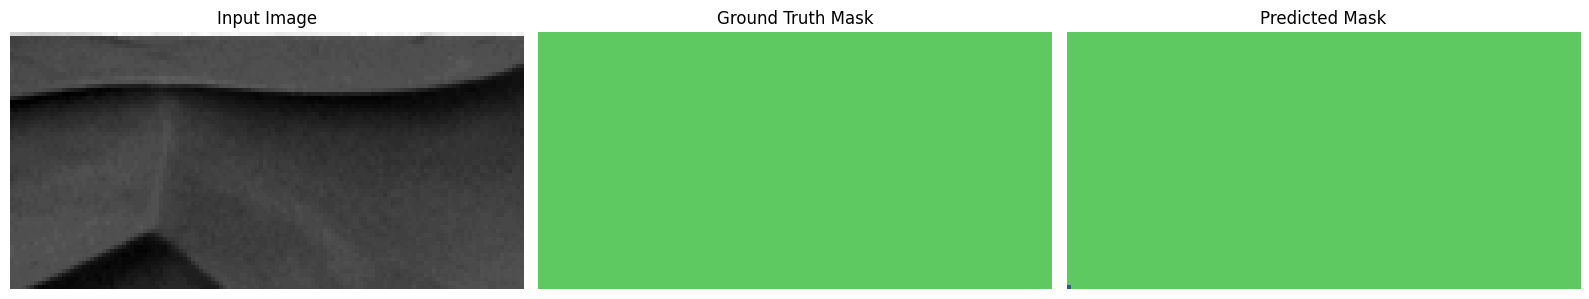

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6283 - loss: 0.6398 - mean_iou: 0.5639 - val_accuracy: 0.6116 - val_loss: 0.7025 - val_mean_iou: 0.5472 - learning_rate: 0.0010
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6381 - loss: 0.6311 - mean_iou: 0.5838

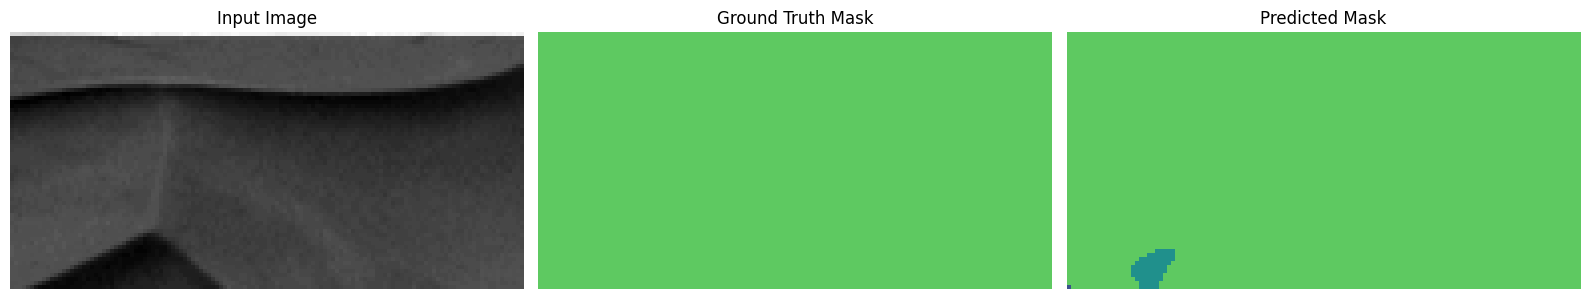

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6382 - loss: 0.6313 - mean_iou: 0.5841 - val_accuracy: 0.5738 - val_loss: 0.7165 - val_mean_iou: 0.5019 - learning_rate: 0.0010
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6521 - loss: 0.6217 - mean_iou: 0.6028

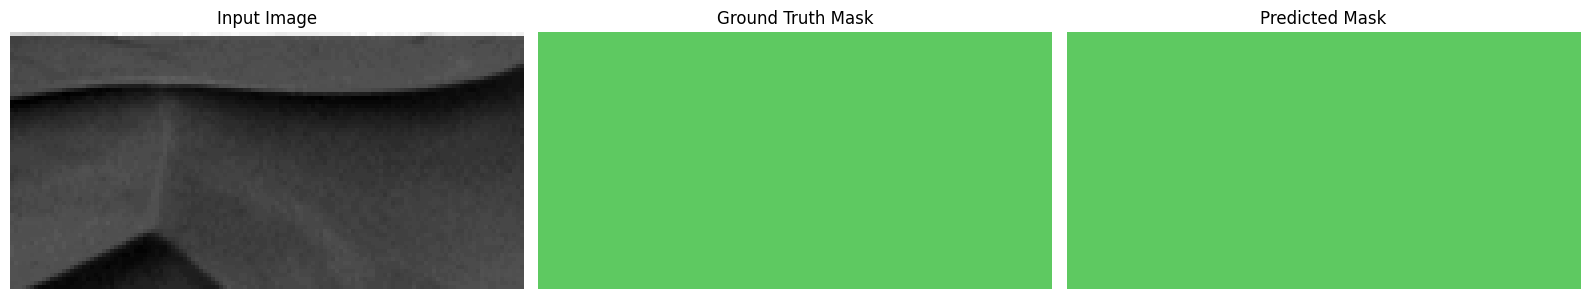

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6521 - loss: 0.6219 - mean_iou: 0.6030 - val_accuracy: 0.5848 - val_loss: 0.7010 - val_mean_iou: 0.5024 - learning_rate: 0.0010
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6527 - loss: 0.6186 - mean_iou: 0.6077

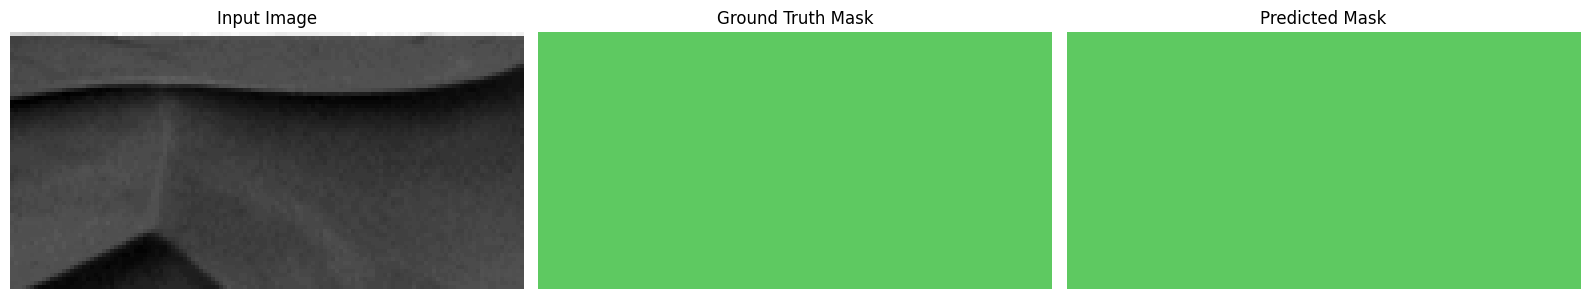

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6528 - loss: 0.6188 - mean_iou: 0.6080 - val_accuracy: 0.6546 - val_loss: 0.6797 - val_mean_iou: 0.6220 - learning_rate: 0.0010
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6596 - loss: 0.6092 - mean_iou: 0.6221

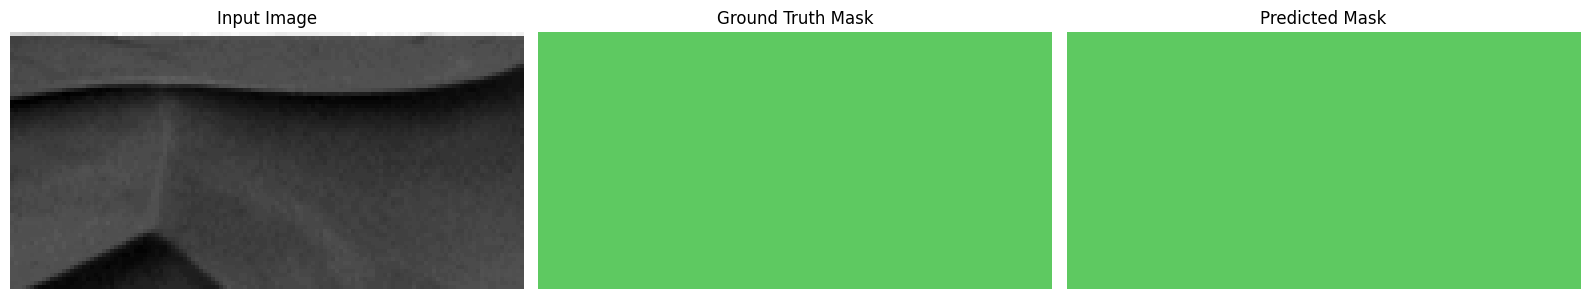

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6597 - loss: 0.6095 - mean_iou: 0.6223 - val_accuracy: 0.6143 - val_loss: 0.6947 - val_mean_iou: 0.5510 - learning_rate: 0.0010
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6607 - loss: 0.6021 - mean_iou: 0.6280

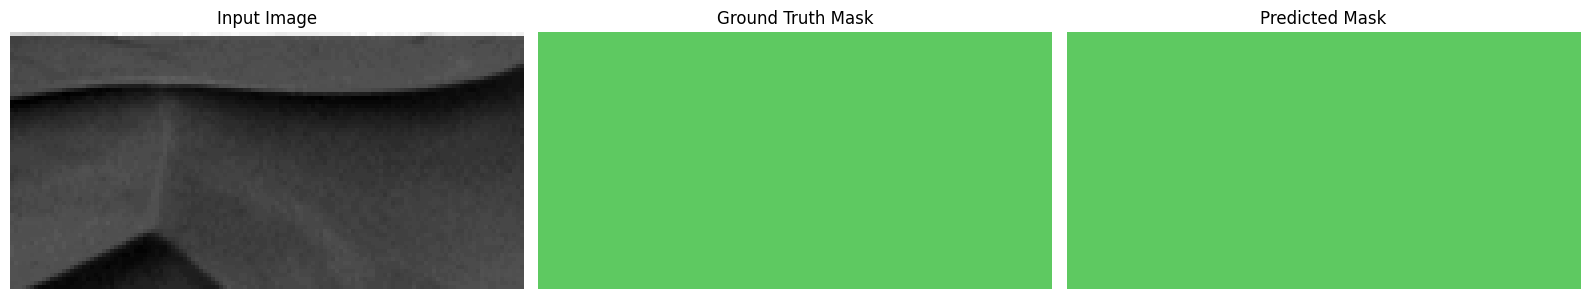

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6608 - loss: 0.6024 - mean_iou: 0.6281 - val_accuracy: 0.6187 - val_loss: 0.6825 - val_mean_iou: 0.5604 - learning_rate: 0.0010
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6612 - loss: 0.5979 - mean_iou: 0.6334

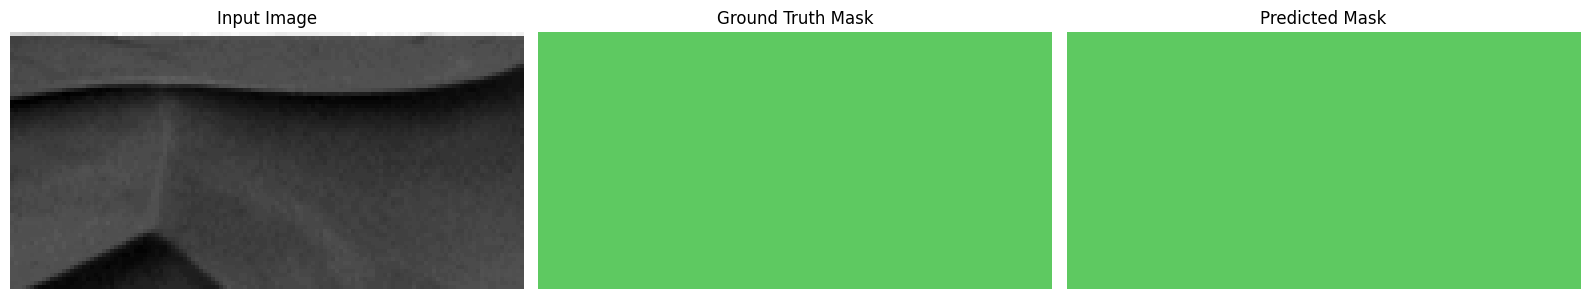

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6612 - loss: 0.5982 - mean_iou: 0.6334 - val_accuracy: 0.6279 - val_loss: 0.6787 - val_mean_iou: 0.5764 - learning_rate: 0.0010
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6582 - loss: 0.6005 - mean_iou: 0.6249

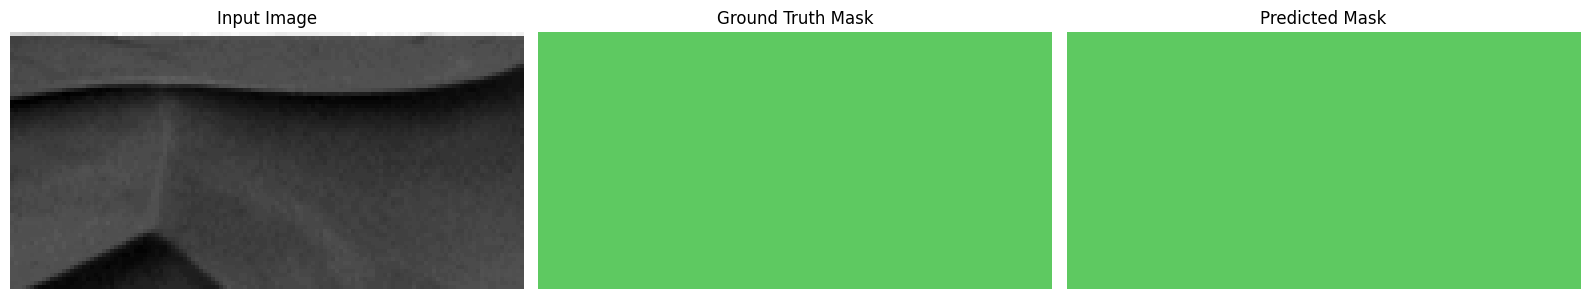

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6582 - loss: 0.6008 - mean_iou: 0.6249 - val_accuracy: 0.6387 - val_loss: 0.6821 - val_mean_iou: 0.5907 - learning_rate: 0.0010
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6610 - loss: 0.6026 - mean_iou: 0.6285

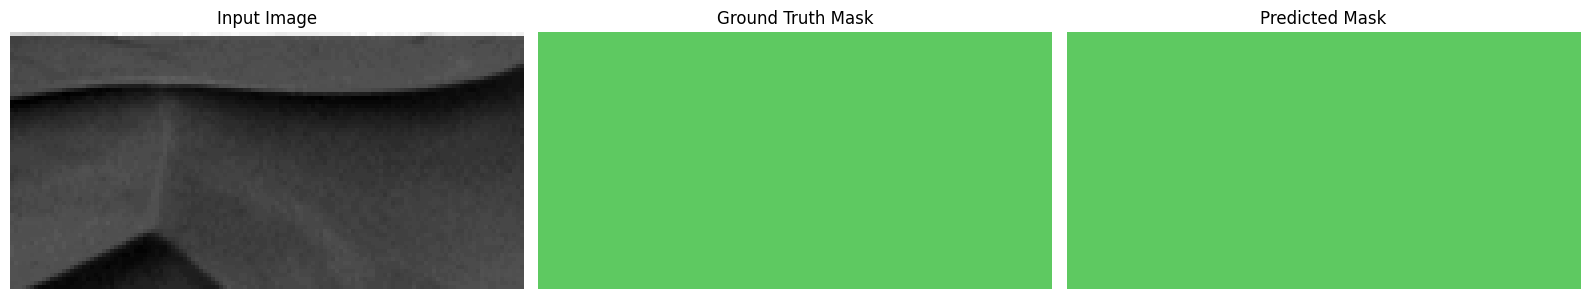

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6610 - loss: 0.6031 - mean_iou: 0.6283 - val_accuracy: 0.6186 - val_loss: 0.7449 - val_mean_iou: 0.5387 - learning_rate: 0.0010
Epoch 55/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6603 - loss: 0.6151 - mean_iou: 0.6207

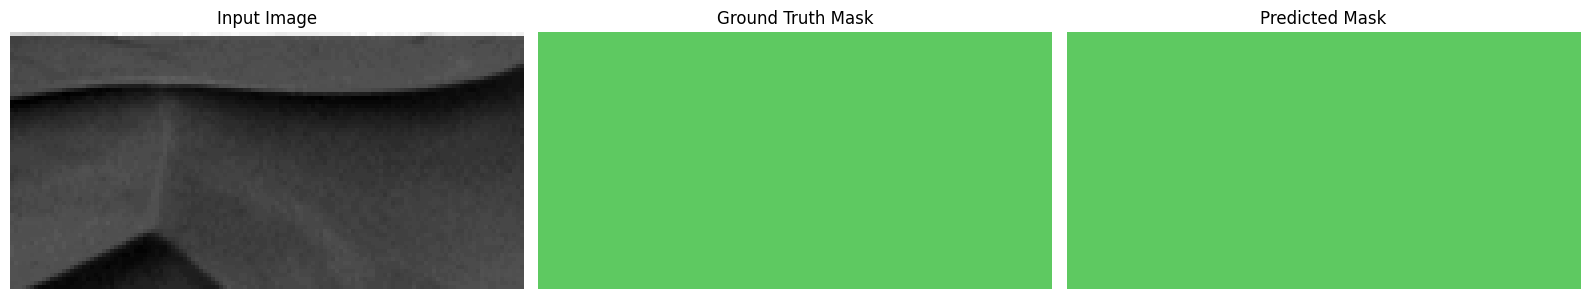

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6603 - loss: 0.6153 - mean_iou: 0.6208 - val_accuracy: 0.6106 - val_loss: 0.6968 - val_mean_iou: 0.5471 - learning_rate: 0.0010
Epoch 56/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6650 - loss: 0.5970 - mean_iou: 0.6339

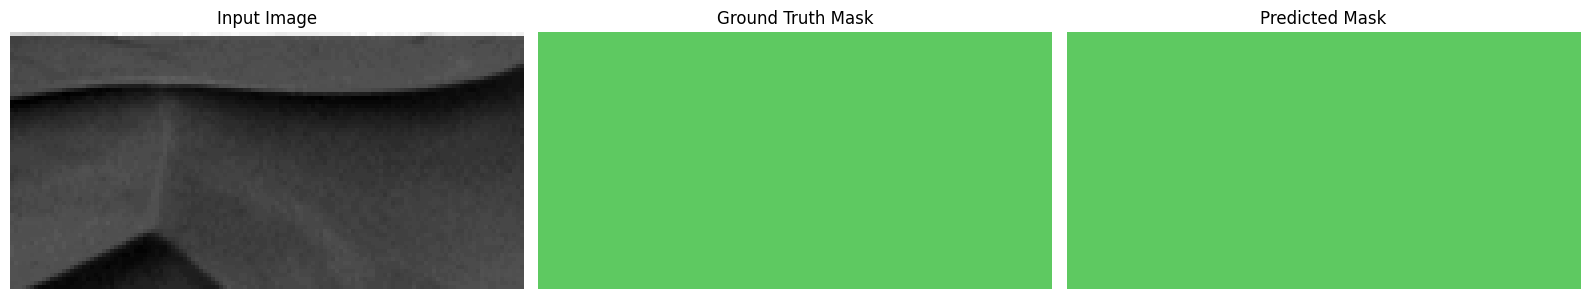

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6649 - loss: 0.5974 - mean_iou: 0.6338 - val_accuracy: 0.6007 - val_loss: 0.6948 - val_mean_iou: 0.5311 - learning_rate: 0.0010
Epoch 57/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6616 - loss: 0.6016 - mean_iou: 0.6259

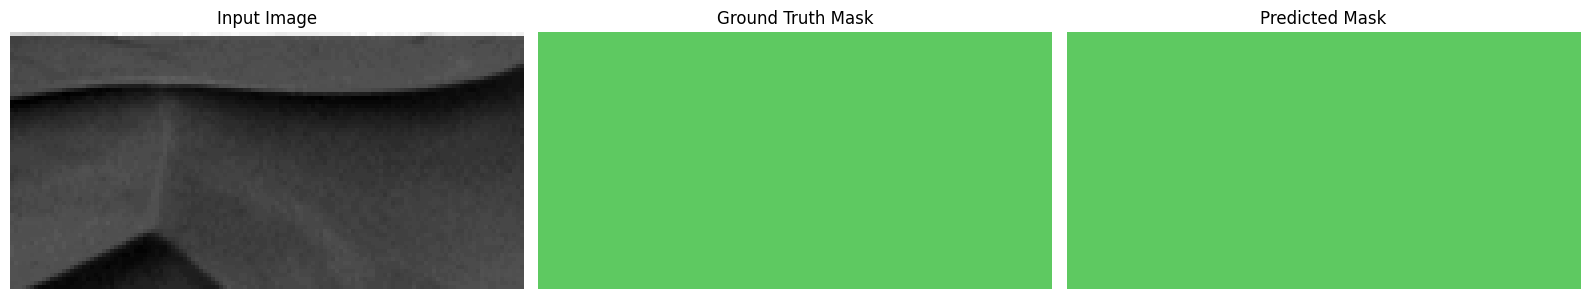

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6616 - loss: 0.6019 - mean_iou: 0.6260 - val_accuracy: 0.6336 - val_loss: 0.6980 - val_mean_iou: 0.5680 - learning_rate: 0.0010
Epoch 58/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6646 - loss: 0.5895 - mean_iou: 0.6373

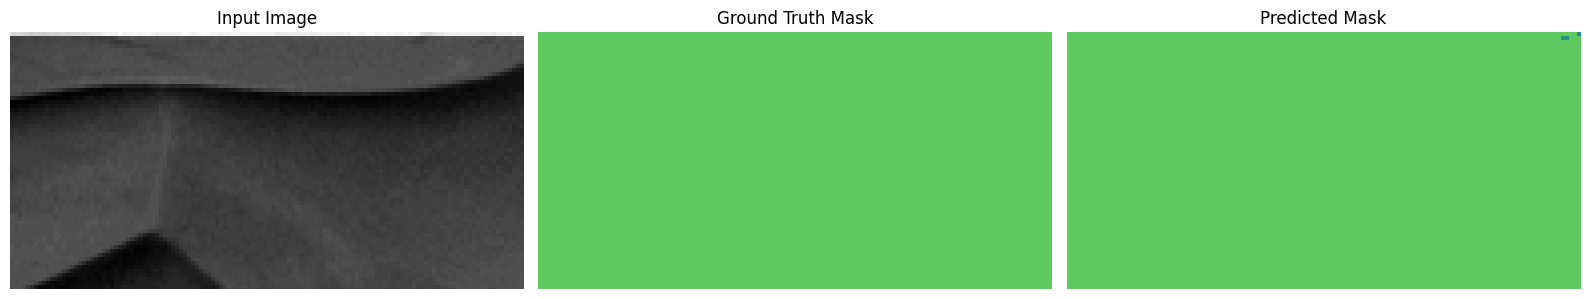

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6645 - loss: 0.5899 - mean_iou: 0.6370 - val_accuracy: 0.5119 - val_loss: 0.7709 - val_mean_iou: 0.3829 - learning_rate: 0.0010
Epoch 59/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6339 - loss: 0.6072 - mean_iou: 0.5945

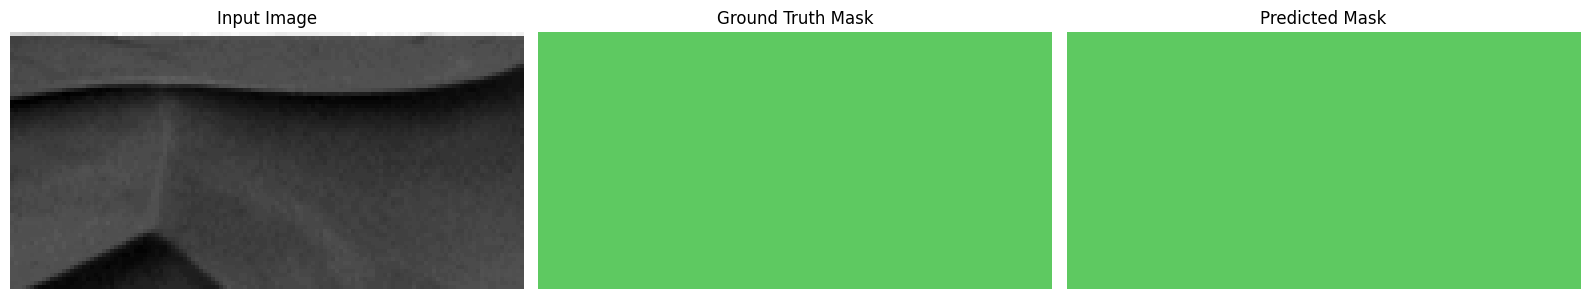

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6341 - loss: 0.6074 - mean_iou: 0.5947 - val_accuracy: 0.5451 - val_loss: 0.7405 - val_mean_iou: 0.4530 - learning_rate: 0.0010
Epoch 60/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6618 - loss: 0.5856 - mean_iou: 0.6364

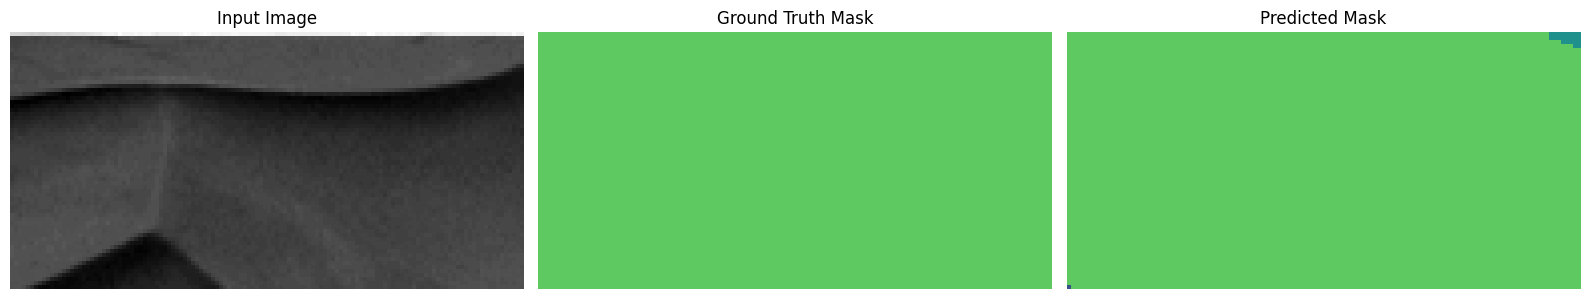

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6617 - loss: 0.5860 - mean_iou: 0.6363 - val_accuracy: 0.5563 - val_loss: 0.7344 - val_mean_iou: 0.4522 - learning_rate: 0.0010
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6566 - loss: 0.6002 - mean_iou: 0.6184

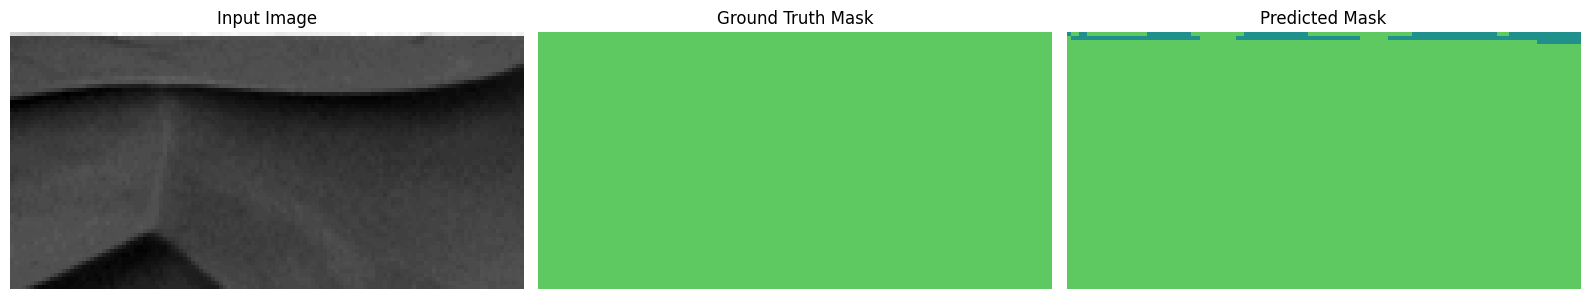

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6566 - loss: 0.6006 - mean_iou: 0.6183 - val_accuracy: 0.5415 - val_loss: 0.7576 - val_mean_iou: 0.4282 - learning_rate: 0.0010
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6579 - loss: 0.6248 - mean_iou: 0.6047

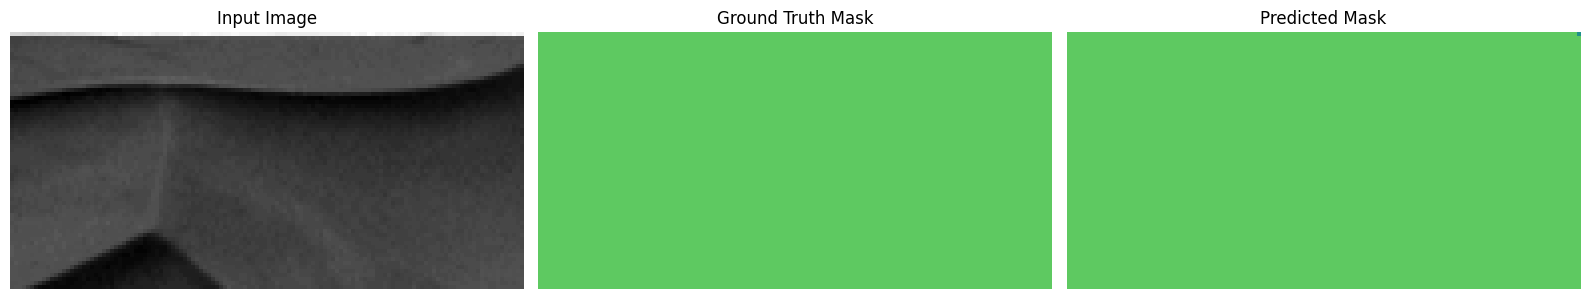

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6579 - loss: 0.6255 - mean_iou: 0.6044 - val_accuracy: 0.6277 - val_loss: 0.7198 - val_mean_iou: 0.5277 - learning_rate: 0.0010
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6632 - loss: 0.6972 - mean_iou: 0.5836

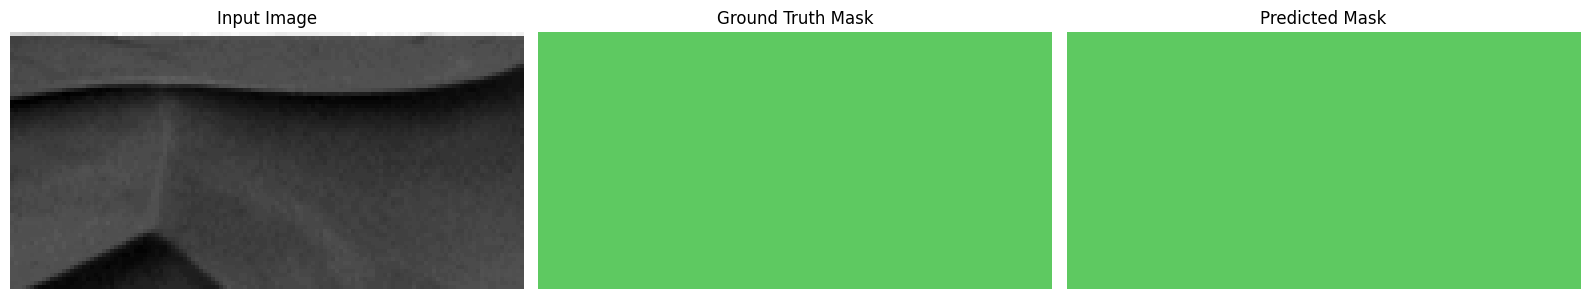

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6632 - loss: 0.6969 - mean_iou: 0.5841 - val_accuracy: 0.6042 - val_loss: 0.7099 - val_mean_iou: 0.5241 - learning_rate: 0.0010
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6594 - loss: 0.6003 - mean_iou: 0.6290

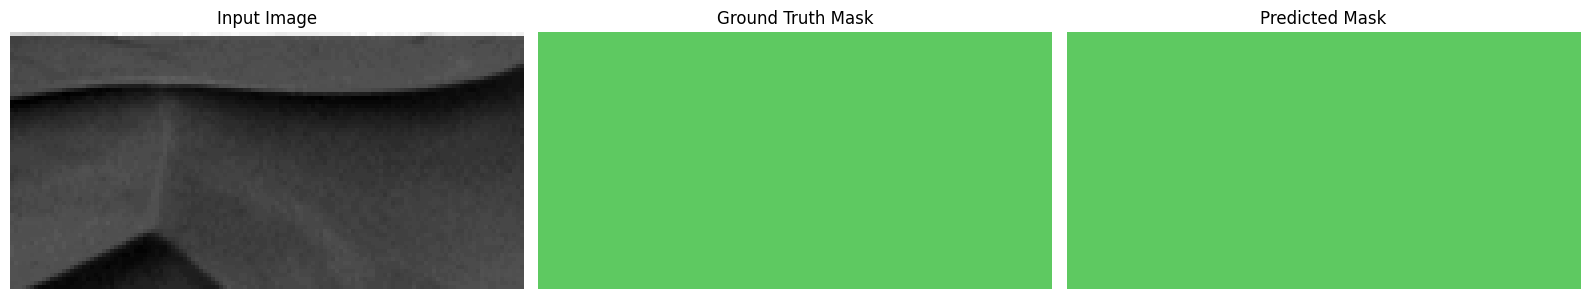

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6594 - loss: 0.6006 - mean_iou: 0.6289 - val_accuracy: 0.4905 - val_loss: 0.7956 - val_mean_iou: 0.3722 - learning_rate: 0.0010
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6611 - loss: 0.5845 - mean_iou: 0.6437

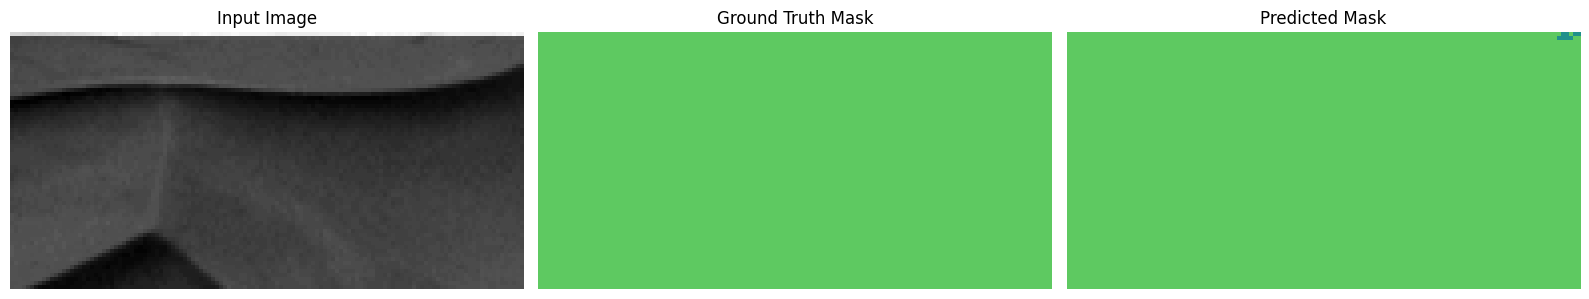

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 384ms/step - accuracy: 0.6611 - loss: 0.5848 - mean_iou: 0.6436 - val_accuracy: 0.6335 - val_loss: 0.7142 - val_mean_iou: 0.5504 - learning_rate: 0.0010
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6605 - loss: 0.5765 - mean_iou: 0.6437

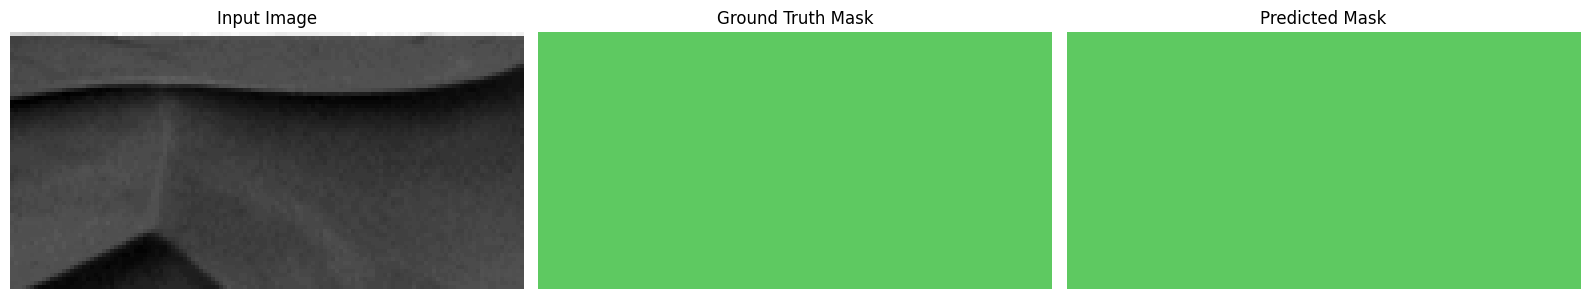

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6605 - loss: 0.5770 - mean_iou: 0.6435 - val_accuracy: 0.6494 - val_loss: 0.7017 - val_mean_iou: 0.5866 - learning_rate: 0.0010
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6710 - loss: 0.5688 - mean_iou: 0.6656

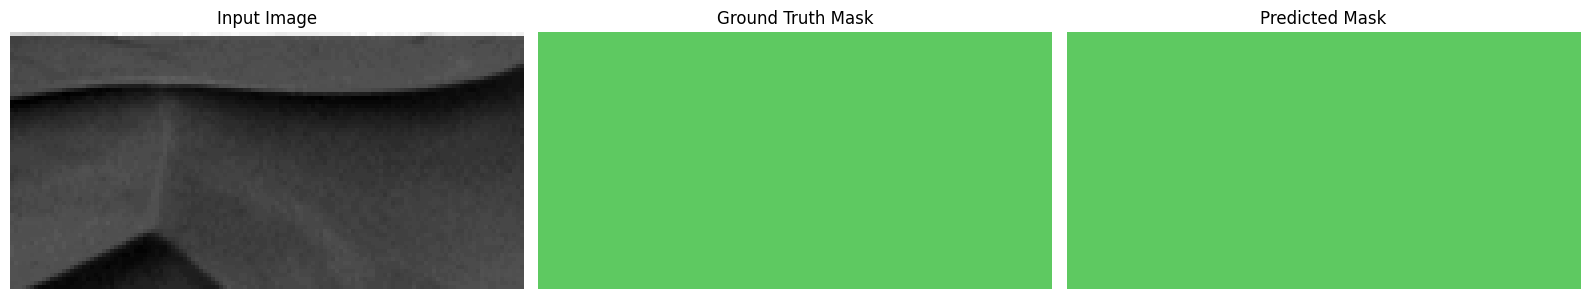

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6711 - loss: 0.5691 - mean_iou: 0.6656 - val_accuracy: 0.5251 - val_loss: 0.7236 - val_mean_iou: 0.4395 - learning_rate: 0.0010
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6496 - loss: 0.5771 - mean_iou: 0.6223

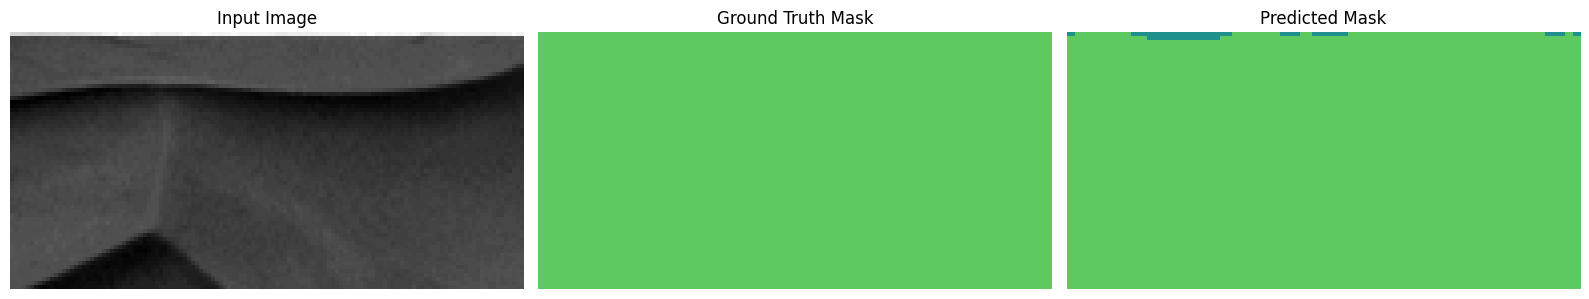

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6497 - loss: 0.5775 - mean_iou: 0.6225 - val_accuracy: 0.6311 - val_loss: 0.7142 - val_mean_iou: 0.5380 - learning_rate: 0.0010
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6664 - loss: 0.5654 - mean_iou: 0.6551

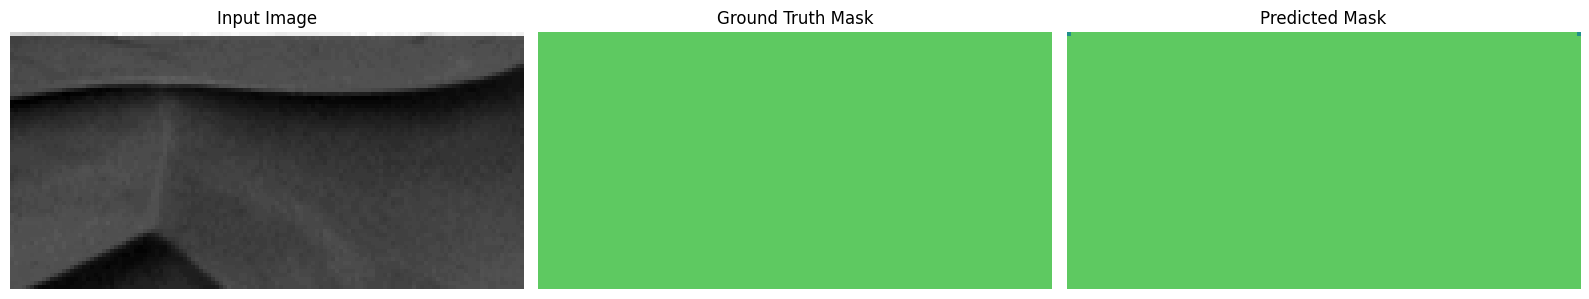

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 373ms/step - accuracy: 0.6664 - loss: 0.5657 - mean_iou: 0.6552 - val_accuracy: 0.6434 - val_loss: 0.7046 - val_mean_iou: 0.5670 - learning_rate: 0.0010
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6685 - loss: 0.5661 - mean_iou: 0.6572

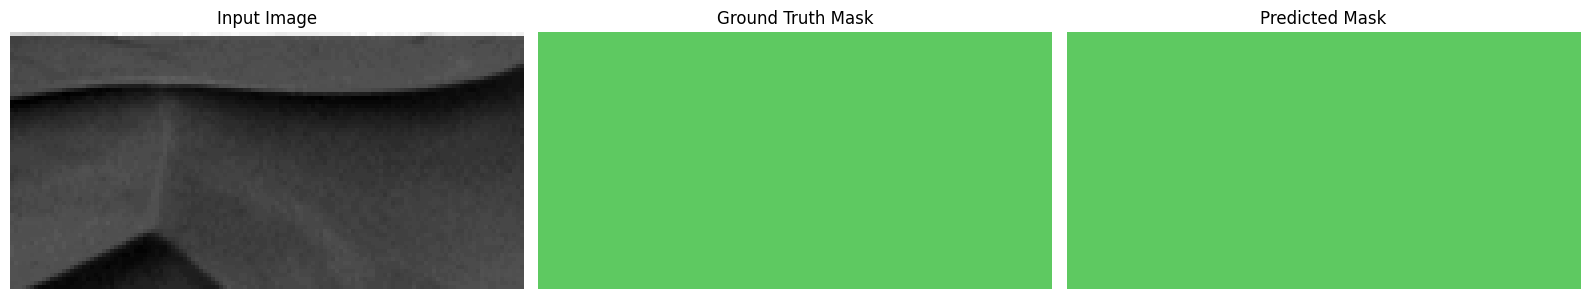

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6684 - loss: 0.5665 - mean_iou: 0.6570 - val_accuracy: 0.5740 - val_loss: 0.7361 - val_mean_iou: 0.4506 - learning_rate: 0.0010
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6668 - loss: 0.5573 - mean_iou: 0.6604

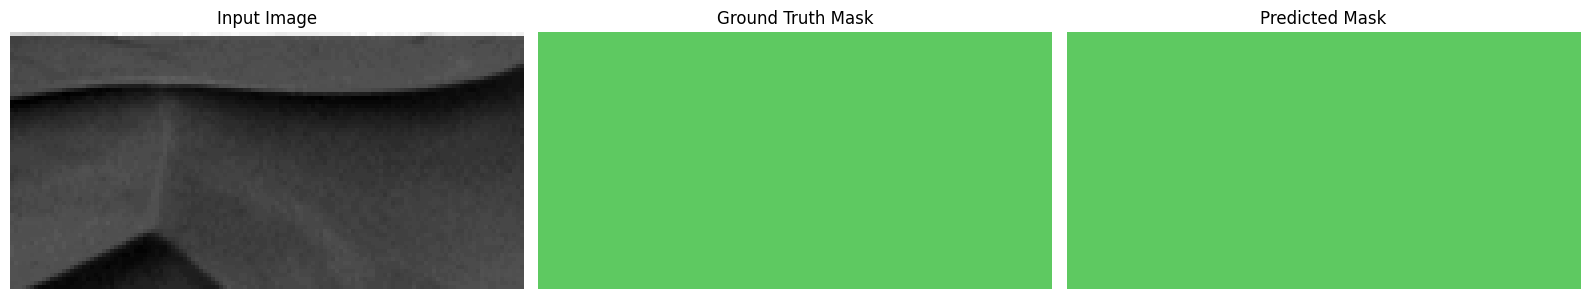

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6669 - loss: 0.5576 - mean_iou: 0.6605 - val_accuracy: 0.6236 - val_loss: 0.7088 - val_mean_iou: 0.5551 - learning_rate: 0.0010
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6638 - loss: 0.5666 - mean_iou: 0.6472

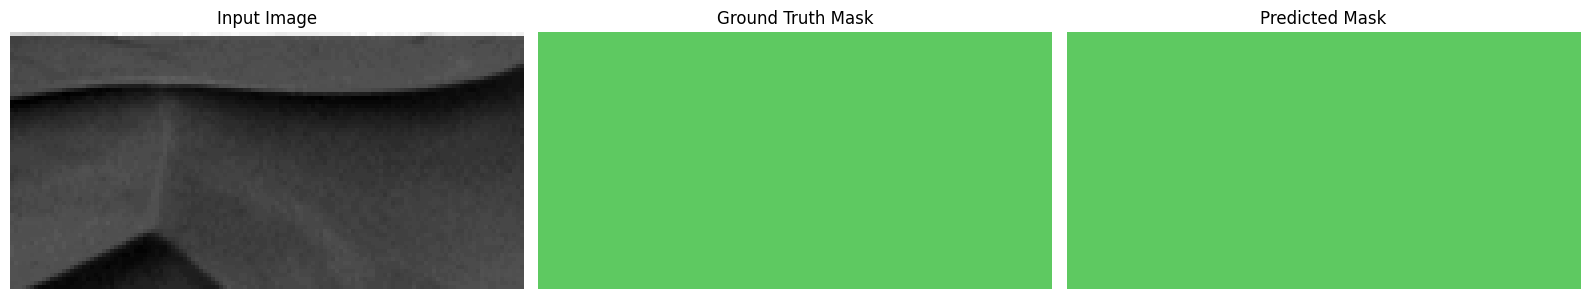

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 371ms/step - accuracy: 0.6638 - loss: 0.5670 - mean_iou: 0.6472 - val_accuracy: 0.5784 - val_loss: 0.7387 - val_mean_iou: 0.4865 - learning_rate: 0.0010
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6740 - loss: 0.5586 - mean_iou: 0.6784

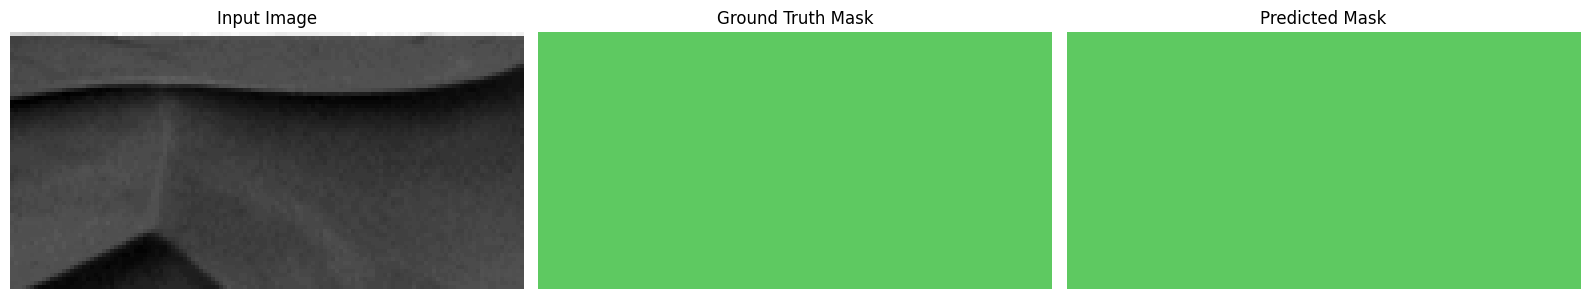

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6740 - loss: 0.5589 - mean_iou: 0.6782 - val_accuracy: 0.6484 - val_loss: 0.7040 - val_mean_iou: 0.5733 - learning_rate: 0.0010
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5428 - loss: 0.6505 - mean_iou: 0.4662

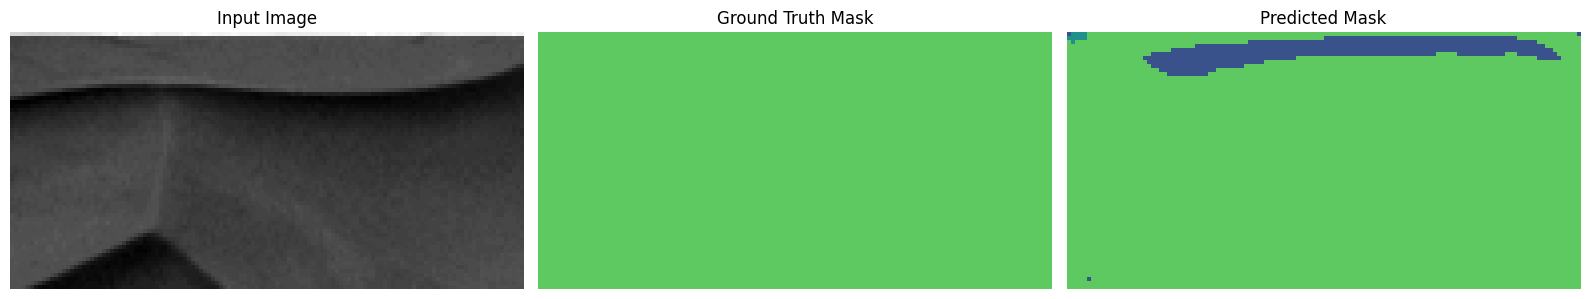

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.5427 - loss: 0.6513 - mean_iou: 0.4656 - val_accuracy: 0.3108 - val_loss: 0.9223 - val_mean_iou: 0.2084 - learning_rate: 0.0010
Epoch 75/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.5999 - loss: 0.6685 - mean_iou: 0.5196

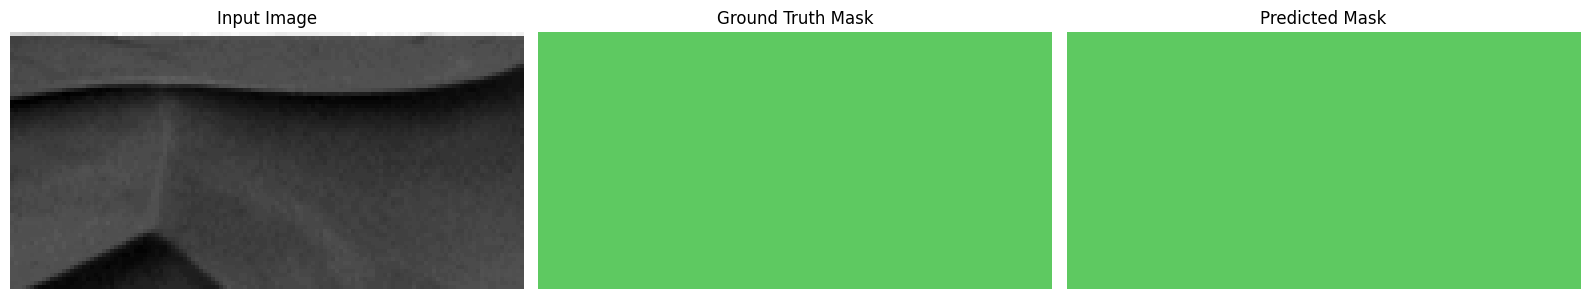

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6000 - loss: 0.6684 - mean_iou: 0.5199 - val_accuracy: 0.5316 - val_loss: 0.7642 - val_mean_iou: 0.4065 - learning_rate: 0.0010
Epoch 76/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6378 - loss: 0.5965 - mean_iou: 0.5973

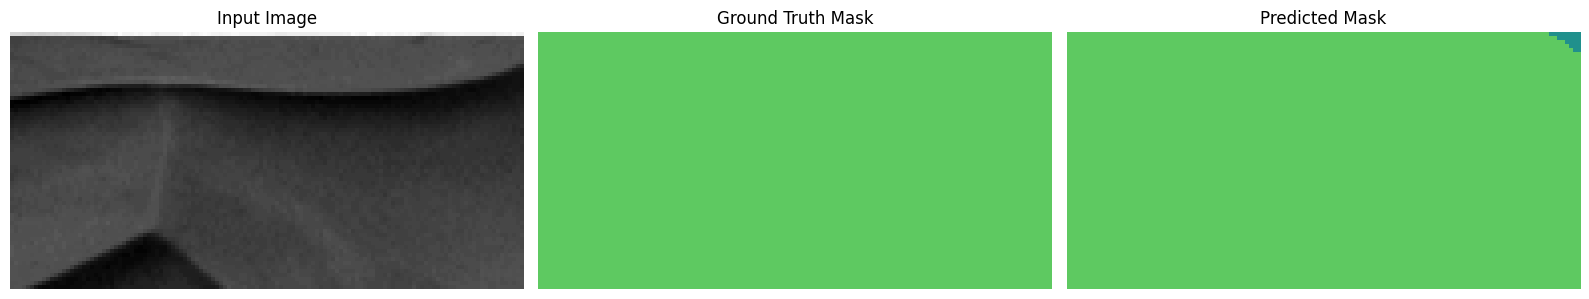

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6379 - loss: 0.5967 - mean_iou: 0.5975 - val_accuracy: 0.6094 - val_loss: 0.7206 - val_mean_iou: 0.5199 - learning_rate: 0.0010
Epoch 77/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6482 - loss: 0.5833 - mean_iou: 0.6222

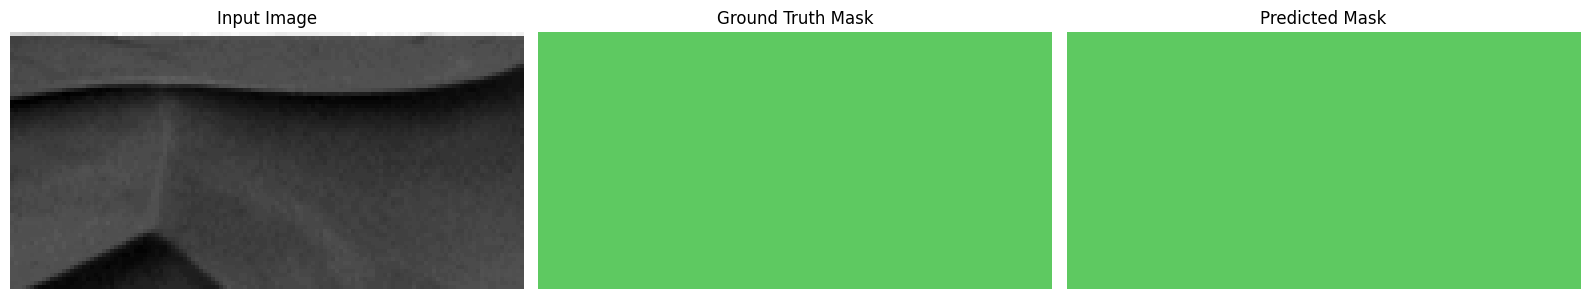

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6483 - loss: 0.5836 - mean_iou: 0.6223 - val_accuracy: 0.6167 - val_loss: 0.7173 - val_mean_iou: 0.5118 - learning_rate: 0.0010
Epoch 78/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6564 - loss: 0.5649 - mean_iou: 0.6487

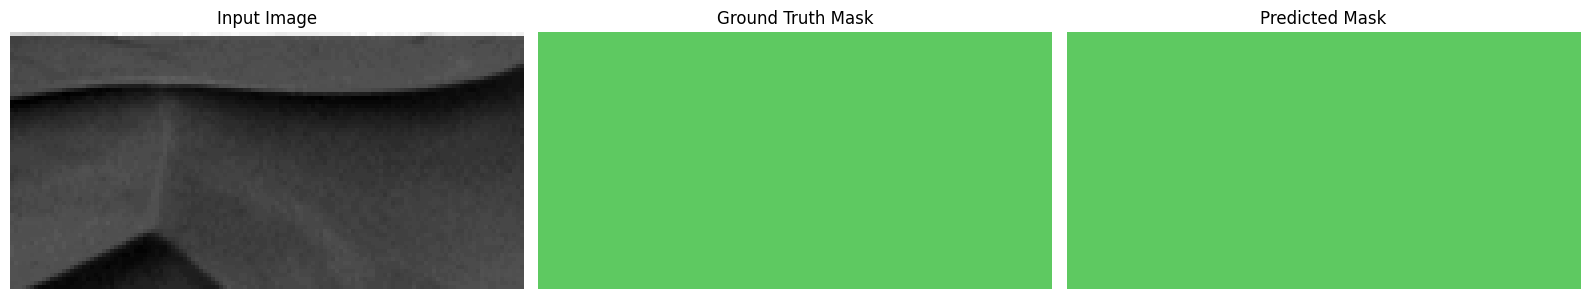

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6565 - loss: 0.5653 - mean_iou: 0.6487 - val_accuracy: 0.6583 - val_loss: 0.7001 - val_mean_iou: 0.5913 - learning_rate: 0.0010
Epoch 79/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6649 - loss: 0.5567 - mean_iou: 0.6565

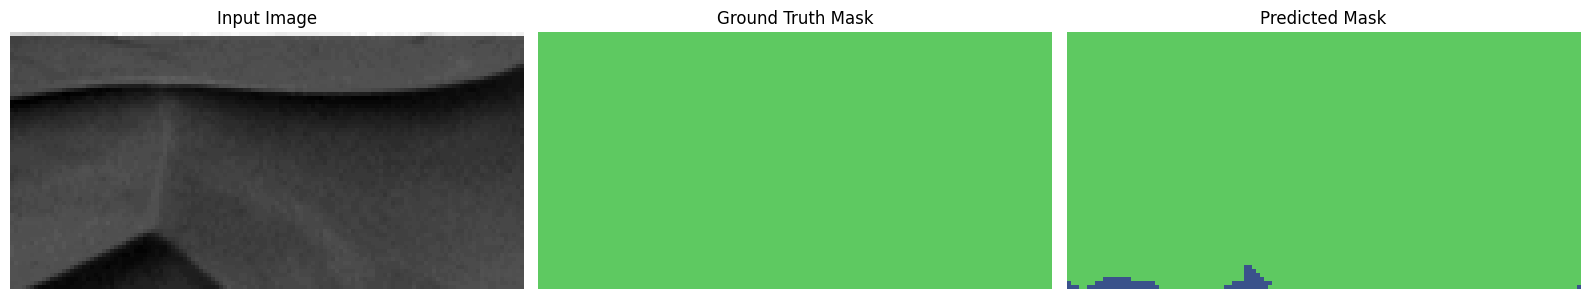

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6649 - loss: 0.5571 - mean_iou: 0.6566 - val_accuracy: 0.6359 - val_loss: 0.6964 - val_mean_iou: 0.5884 - learning_rate: 0.0010
Epoch 80/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6660 - loss: 0.5500 - mean_iou: 0.6638

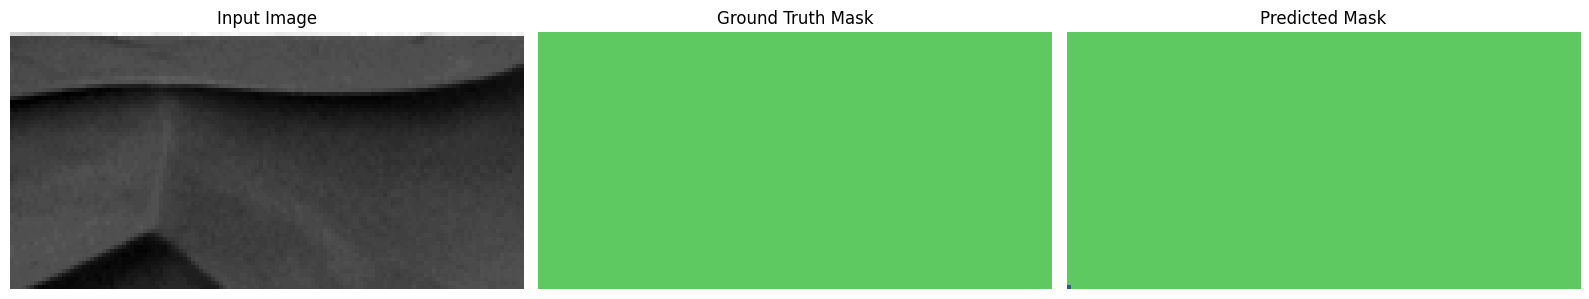

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6660 - loss: 0.5504 - mean_iou: 0.6638 - val_accuracy: 0.6460 - val_loss: 0.7085 - val_mean_iou: 0.5704 - learning_rate: 0.0010
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6623 - loss: 0.5513 - mean_iou: 0.6691

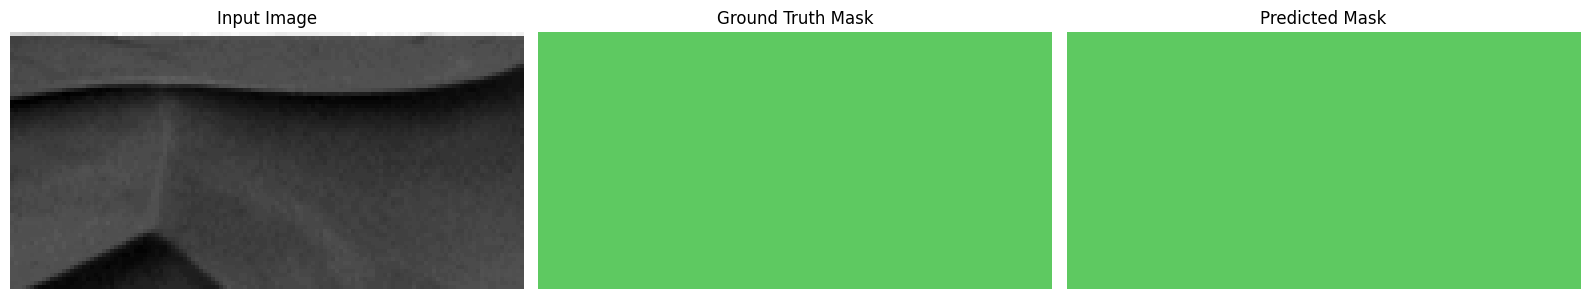

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6623 - loss: 0.5517 - mean_iou: 0.6691 - val_accuracy: 0.6501 - val_loss: 0.6913 - val_mean_iou: 0.5976 - learning_rate: 0.0010
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6616 - loss: 0.5533 - mean_iou: 0.6658

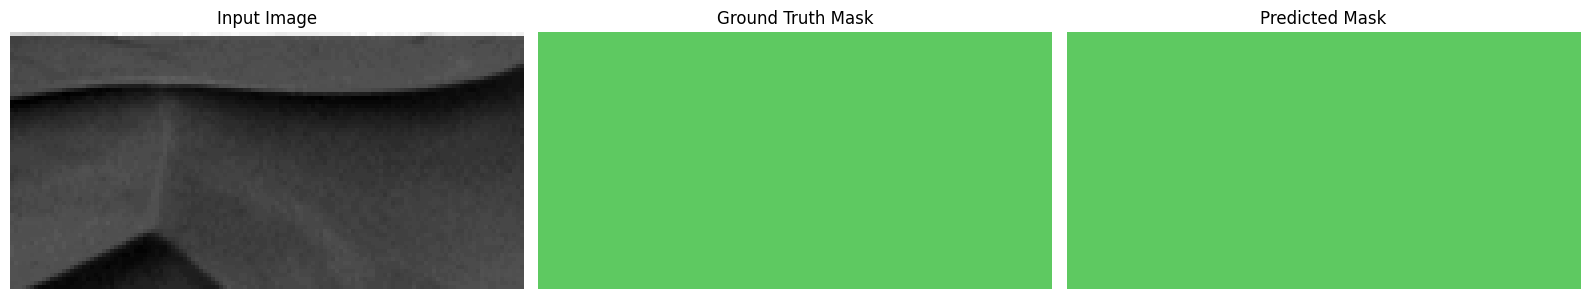

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6616 - loss: 0.5537 - mean_iou: 0.6657 - val_accuracy: 0.6009 - val_loss: 0.7037 - val_mean_iou: 0.5306 - learning_rate: 0.0010
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6758 - loss: 0.5480 - mean_iou: 0.6765

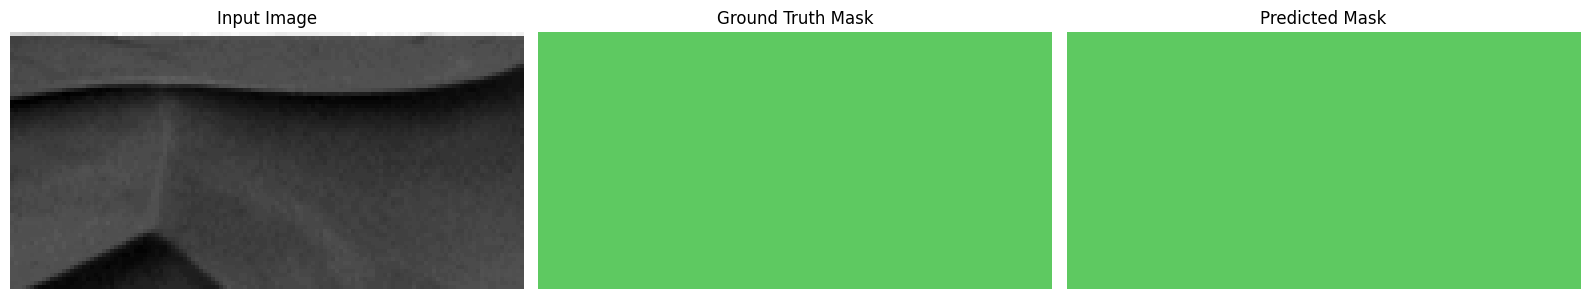

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.6759 - loss: 0.5483 - mean_iou: 0.6767 - val_accuracy: 0.6587 - val_loss: 0.6958 - val_mean_iou: 0.5970 - learning_rate: 5.0000e-04
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6813 - loss: 0.5337 - mean_iou: 0.7013

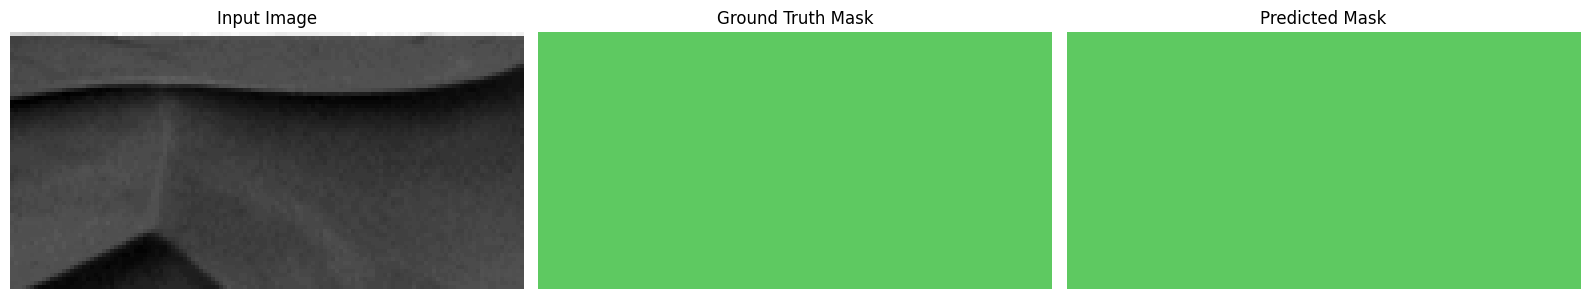

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step - accuracy: 0.6813 - loss: 0.5341 - mean_iou: 0.7014 - val_accuracy: 0.6589 - val_loss: 0.6873 - val_mean_iou: 0.6251 - learning_rate: 5.0000e-04
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6840 - loss: 0.5280 - mean_iou: 0.7166

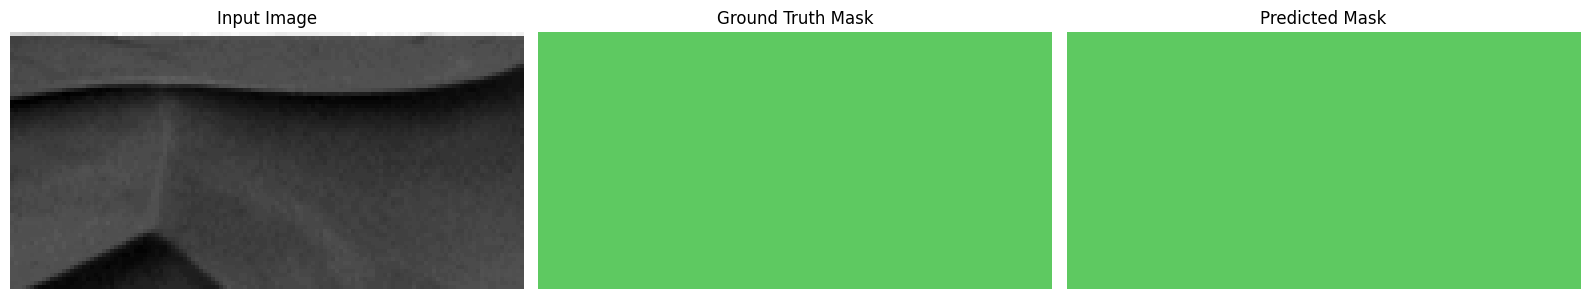

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6841 - loss: 0.5284 - mean_iou: 0.7166 - val_accuracy: 0.6524 - val_loss: 0.6900 - val_mean_iou: 0.6096 - learning_rate: 5.0000e-04
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6820 - loss: 0.5283 - mean_iou: 0.7068

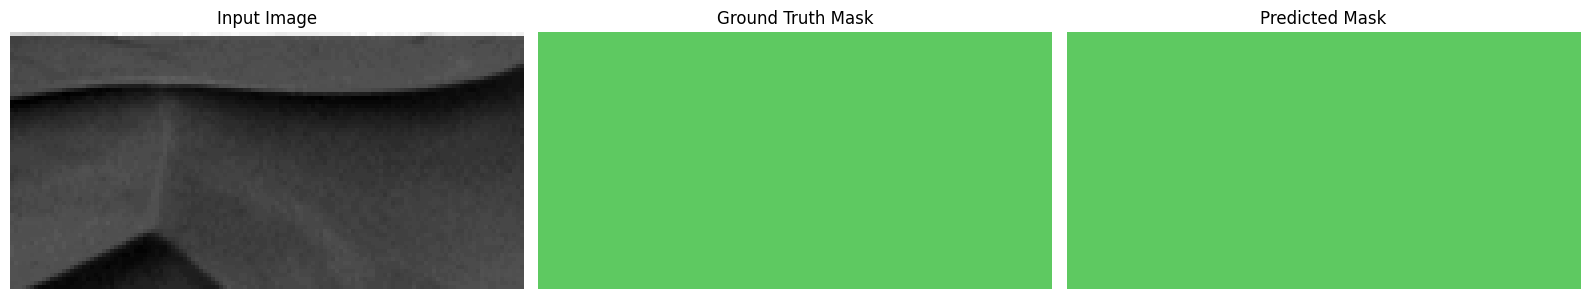

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6820 - loss: 0.5287 - mean_iou: 0.7068 - val_accuracy: 0.6625 - val_loss: 0.6929 - val_mean_iou: 0.6088 - learning_rate: 5.0000e-04
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6819 - loss: 0.5301 - mean_iou: 0.7085

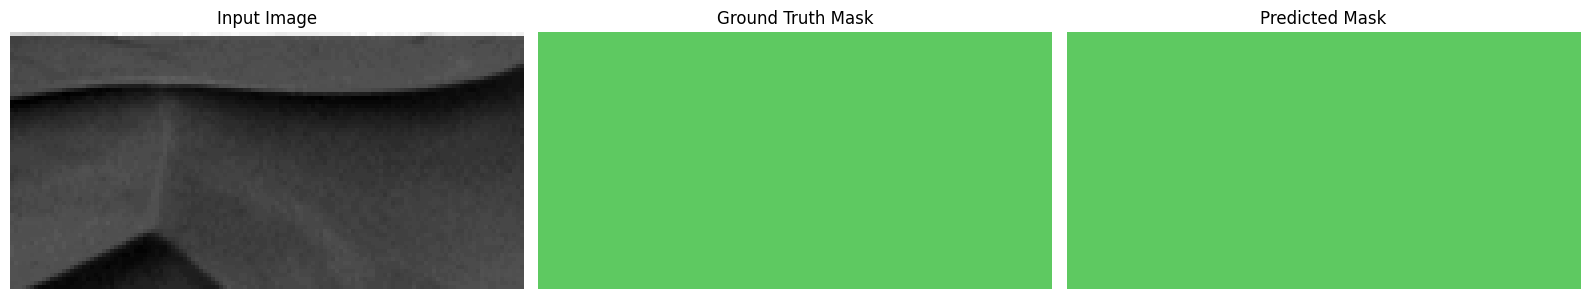

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 378ms/step - accuracy: 0.6819 - loss: 0.5305 - mean_iou: 0.7086 - val_accuracy: 0.6638 - val_loss: 0.6844 - val_mean_iou: 0.6386 - learning_rate: 5.0000e-04
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6840 - loss: 0.5224 - mean_iou: 0.7230

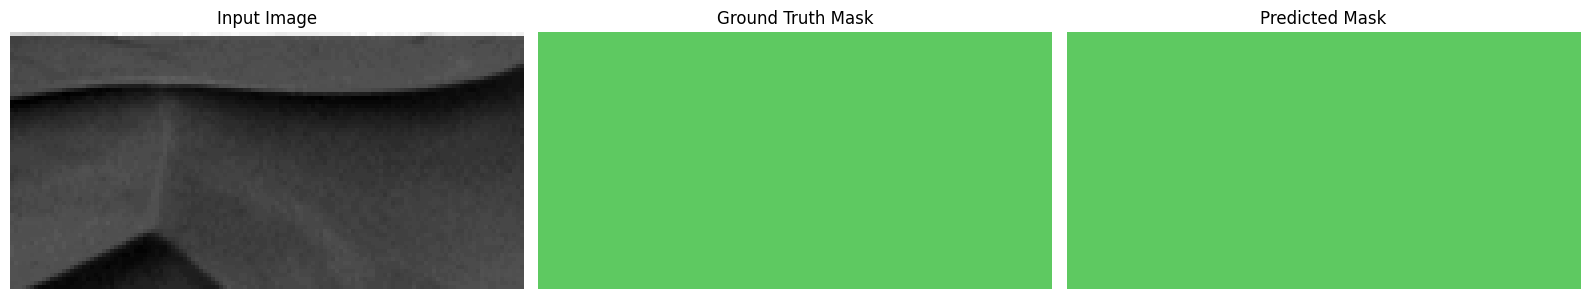

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.6840 - loss: 0.5228 - mean_iou: 0.7231 - val_accuracy: 0.6687 - val_loss: 0.6814 - val_mean_iou: 0.6516 - learning_rate: 5.0000e-04
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6850 - loss: 0.5234 - mean_iou: 0.7280

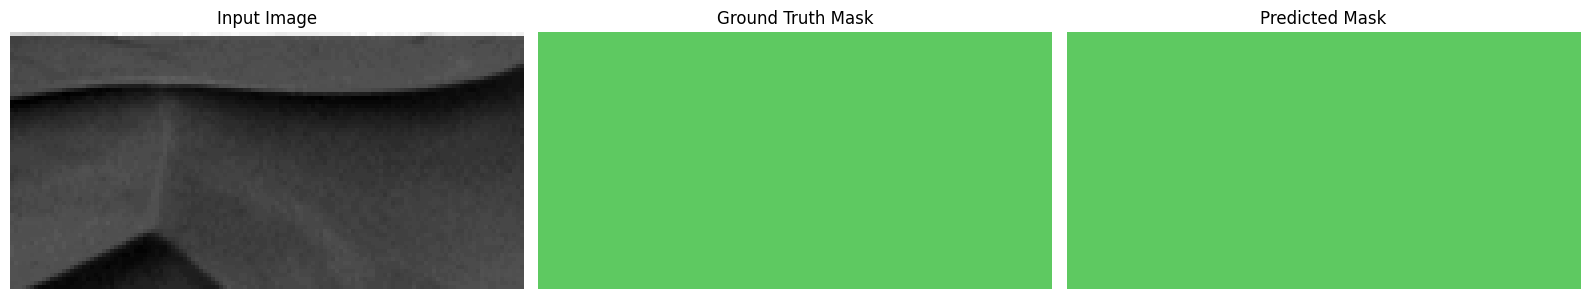

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6850 - loss: 0.5238 - mean_iou: 0.7279 - val_accuracy: 0.6715 - val_loss: 0.6866 - val_mean_iou: 0.6401 - learning_rate: 5.0000e-04
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6756 - loss: 0.5350 - mean_iou: 0.6928

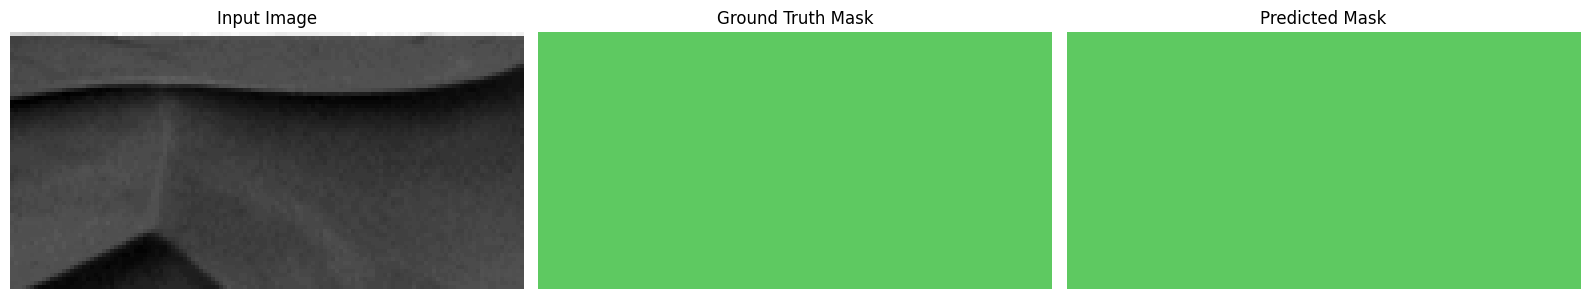

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6756 - loss: 0.5354 - mean_iou: 0.6928 - val_accuracy: 0.6059 - val_loss: 0.7017 - val_mean_iou: 0.5440 - learning_rate: 5.0000e-04
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6851 - loss: 0.5234 - mean_iou: 0.7175

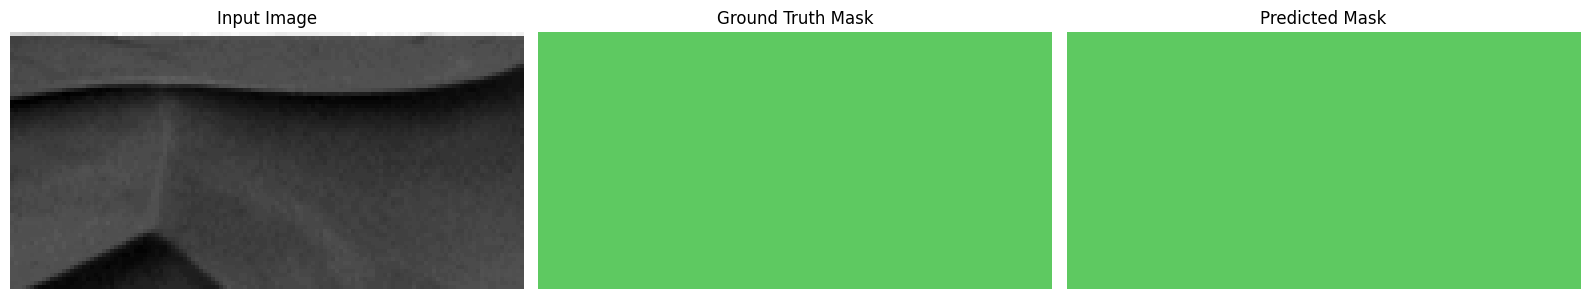

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6852 - loss: 0.5238 - mean_iou: 0.7175 - val_accuracy: 0.6690 - val_loss: 0.6981 - val_mean_iou: 0.6082 - learning_rate: 5.0000e-04
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6854 - loss: 0.5174 - mean_iou: 0.7232

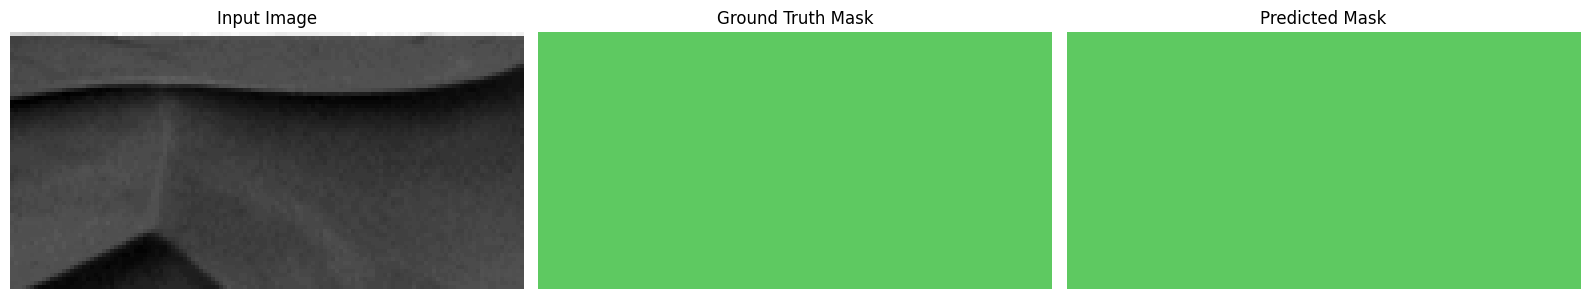

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6854 - loss: 0.5178 - mean_iou: 0.7231 - val_accuracy: 0.6686 - val_loss: 0.7013 - val_mean_iou: 0.5979 - learning_rate: 5.0000e-04
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6865 - loss: 0.5204 - mean_iou: 0.7222

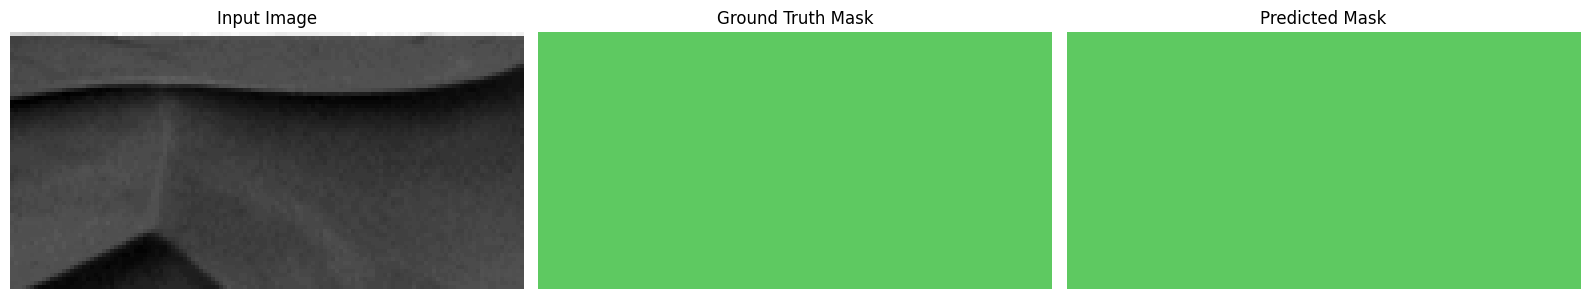

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6865 - loss: 0.5208 - mean_iou: 0.7222 - val_accuracy: 0.6550 - val_loss: 0.6933 - val_mean_iou: 0.6178 - learning_rate: 5.0000e-04
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6912 - loss: 0.5229 - mean_iou: 0.7153

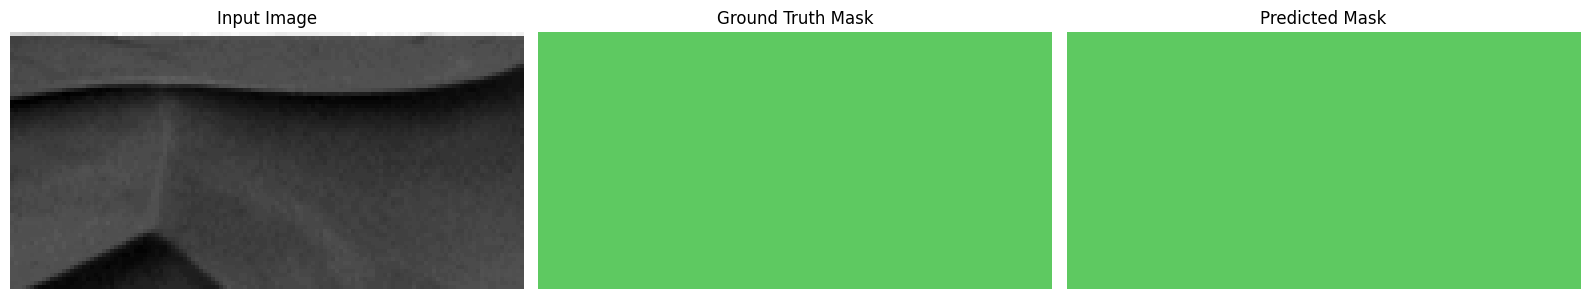

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6912 - loss: 0.5233 - mean_iou: 0.7153 - val_accuracy: 0.6694 - val_loss: 0.6972 - val_mean_iou: 0.6062 - learning_rate: 5.0000e-04
Epoch 95/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6906 - loss: 0.5193 - mean_iou: 0.7265

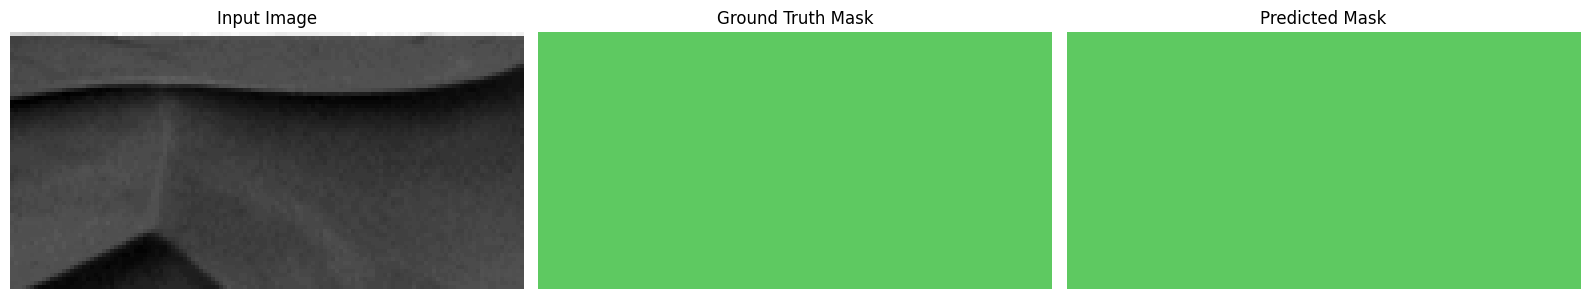

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6906 - loss: 0.5197 - mean_iou: 0.7263 - val_accuracy: 0.6528 - val_loss: 0.6937 - val_mean_iou: 0.6025 - learning_rate: 5.0000e-04
Epoch 96/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6897 - loss: 0.5151 - mean_iou: 0.7332

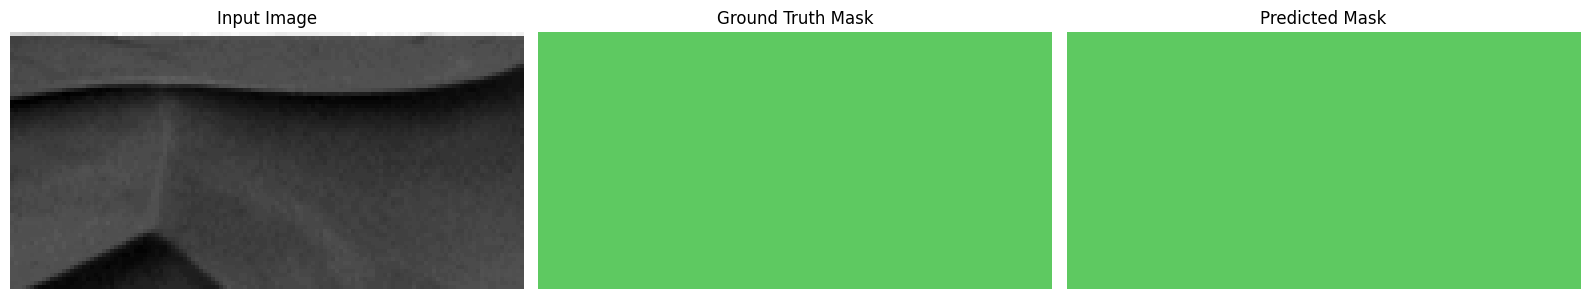

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6896 - loss: 0.5156 - mean_iou: 0.7332 - val_accuracy: 0.6695 - val_loss: 0.6981 - val_mean_iou: 0.6095 - learning_rate: 5.0000e-04
Epoch 97/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6916 - loss: 0.5136 - mean_iou: 0.7361

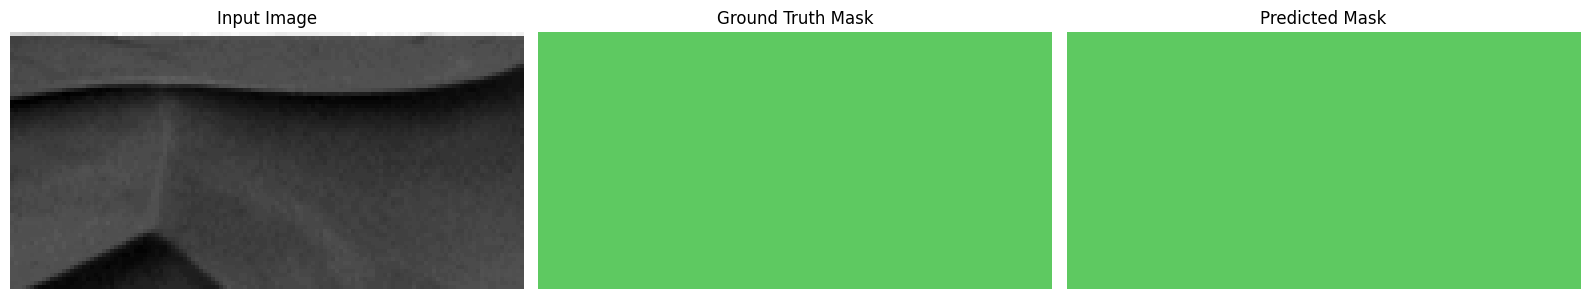

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 372ms/step - accuracy: 0.6916 - loss: 0.5140 - mean_iou: 0.7361 - val_accuracy: 0.6774 - val_loss: 0.6894 - val_mean_iou: 0.6292 - learning_rate: 5.0000e-04
Epoch 98/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6919 - loss: 0.5063 - mean_iou: 0.7505

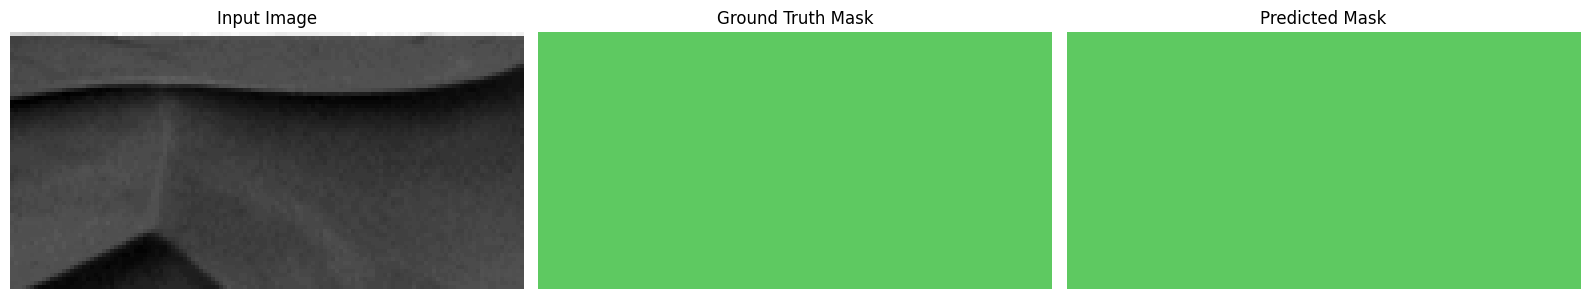

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 385ms/step - accuracy: 0.6919 - loss: 0.5068 - mean_iou: 0.7502 - val_accuracy: 0.6624 - val_loss: 0.6964 - val_mean_iou: 0.6018 - learning_rate: 5.0000e-04
Epoch 99/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6890 - loss: 0.5184 - mean_iou: 0.7304

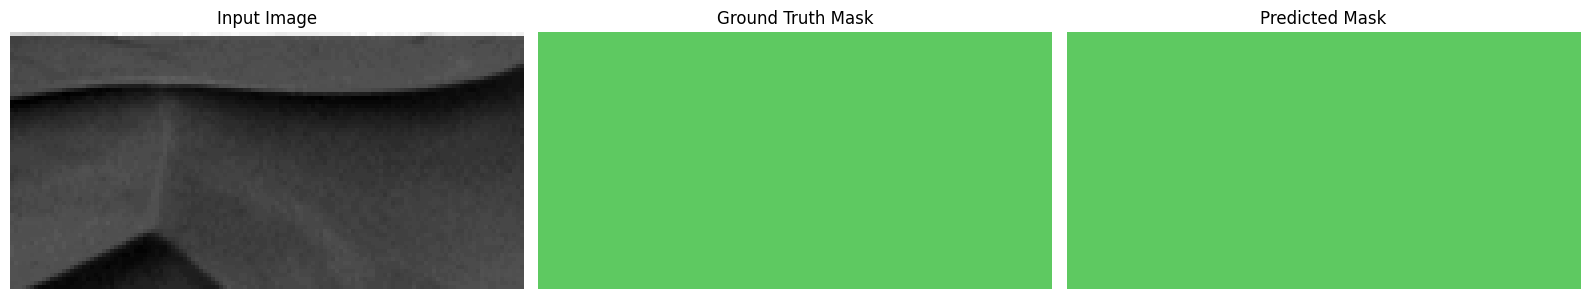

63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 373ms/step - accuracy: 0.6889 - loss: 0.5189 - mean_iou: 0.7302 - val_accuracy: 0.6175 - val_loss: 0.7312 - val_mean_iou: 0.5243 - learning_rate: 5.0000e-04
Epoch 100/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6857 - loss: 0.5367 - mean_iou: 0.7162

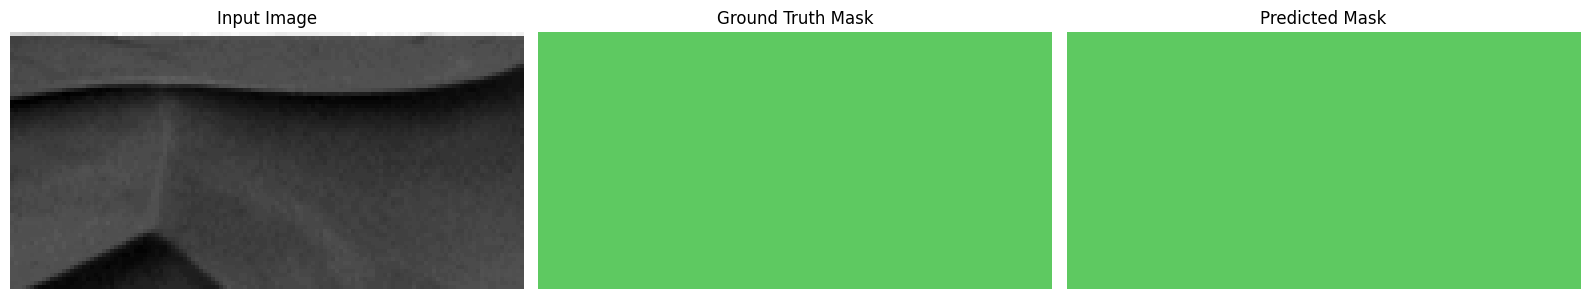

63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.6858 - loss: 0.5369 - mean_iou: 0.7163 - val_accuracy: 0.6396 - val_loss: 0.6994 - val_mean_iou: 0.5773 - learning_rate: 5.0000e-04
Final validation Mean Intersection Over Union: 65.16%


In [47]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping (
    monitor='val_mean_iou',
    mode='max',
    patience=40,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau (
    monitor='val_loss',
    mode='min',
    patience=30,
    factor=0.5,
    min_lr=1e-6
) 

random_viz = np.random.randint(0, X_val.shape[0])
print("Showing evolution on image", random_viz)
viz_callback = VizCallback(X_val[random_viz], y_val[random_viz], num_classes)

callbacks = [early_stopping, reduce_lr, viz_callback]

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [48]:
history.keys()

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou', 'learning_rate'])

In [49]:
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 65.16%


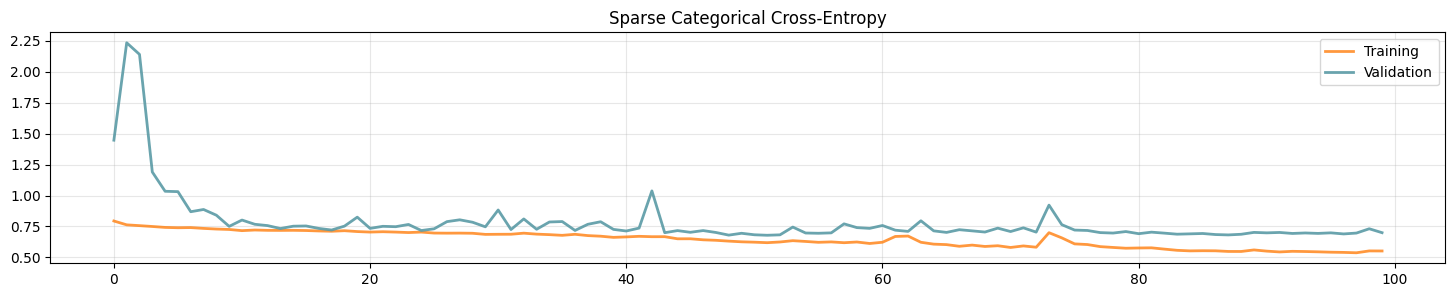

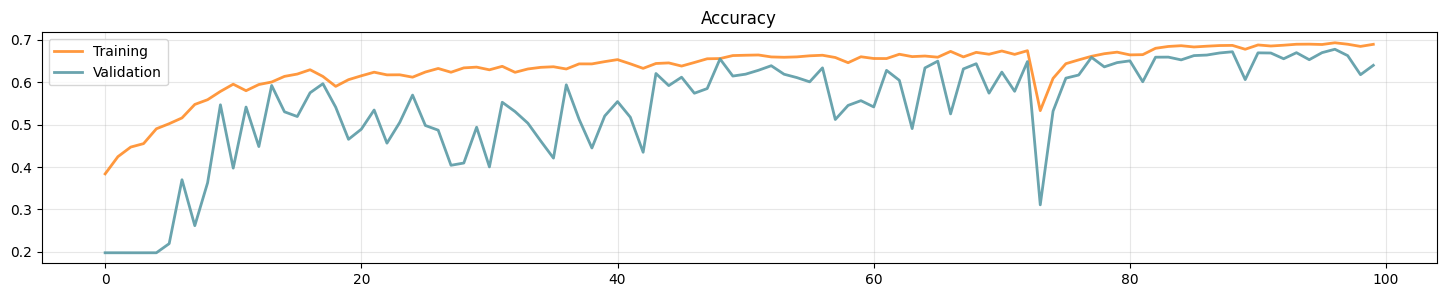

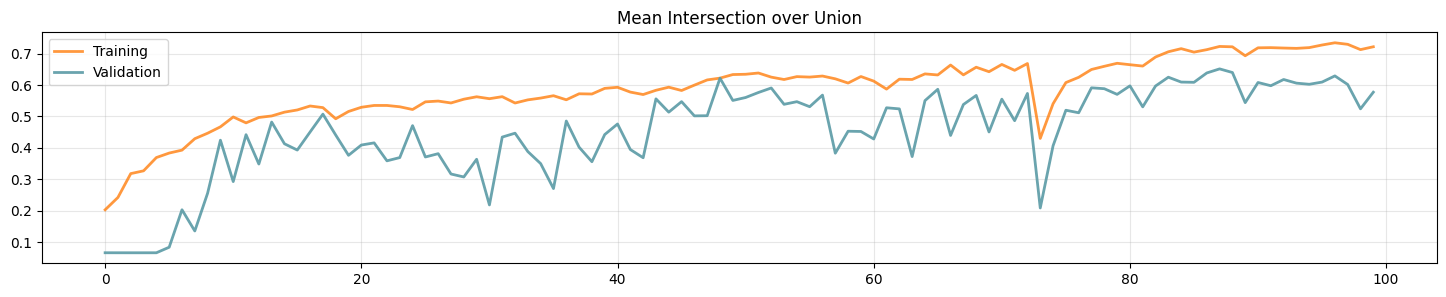

In [50]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Sparse Categorical Cross-Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [51]:
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241207_152443.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.

In [52]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [53]:
model = tfk.models.load_model(model_filename, compile=False)
print(f"Model loaded from {model_filename}")

Model loaded from model_241207_152443.keras


In [54]:
# Custom compiling due to custom metric MeanIOU defined
# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(learning_rate),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
)

In [55]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 41s 122ms/step
Predictions shape: (10022, 64, 128)


In [56]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [57]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print("CSV created in the output folder: ", submission_filename)

CSV created in the output folder:  submission_241207_152443.csv
